# Библиотеки

In [ ]:
import os
import random
from keras import backend as K
import numpy as np
import tensorflow
from tensorflow.keras.backend import clear_session

# для кераса недостаточно просто задать рандом сид,
# поэтому сделаем ф-ию для воспроизводимости рез-в
def reset_seeds(seed_value = 1108):
    clear_session()
    tensorflow.compat.v1.reset_default_graph()
    
    tensorflow.keras.utils.set_random_seed(seed_value)
    os.environ['PYTHONHASHSEED']=str(seed_value)

    session_conf = tensorflow.compat.v1.ConfigProto(intra_op_parallelism_threads=1, 
                                                    inter_op_parallelism_threads=1)
    sess = tensorflow.compat.v1.Session(graph=tensorflow.compat.v1.get_default_graph(), 
                                        config=session_conf)
    K.set_session(sess)

reset_seeds(seed_value = 1108)

In [ ]:
# Для работы с данными
import pandas as pd
import glob
# Метрики качества
from sklearn.metrics import r2_score, mean_absolute_percentage_error
# Визуализация
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
import matplotlib # colormap, lines
import seaborn as sns
# Процесс выполнения
from tqdm.notebook import tqdm,trange
from tqdm.keras import TqdmCallback
# Tensorflow
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Dense, concatenate, Dropout, LSTM
# PyTorch
import torch
import torch.nn as nn

# Отдельные модули
import preprocessing
import micro_model_functions
import micro_help_functions
import macro_model_functions
import macro_help_functions

# Загрузка данных

In [ ]:
path_to_dataset = 'transact_18_22.csv'
df = pd.read_csv(path_to_dataset)

print('df shape: ', df.shape)
df.head()

df shape:  (19262668, 7)


client     card        date     amt   mcc group             value
0   390989  3048567  2018-01-01   878.0  5814  food          survival
1  1309946  3226559  2018-01-01   249.0  5411  food          survival
2  1386278  2715990  2018-01-01    50.0  5499  food          survival
3   475694  2884069  2018-01-01  2564.0  5941   fun  self_realization
4   710293  3396065  2018-01-01   464.9  5814  food          survival

Посмотрим на кол-во клиентов, МСС и транзакций в категориях

In [ ]:
df.client.nunique()

10000

In [ ]:
df.mcc.nunique()

390

In [ ]:
df.value.value_counts()

survival            11898943
socialization        3462139
money                1968121
self_realization     1697659
5300                   47735
                      ...   
3050                       1
3512                       1
8734                       1
3589                       1
3542                       1
Name: value, Length: 279, dtype: int64

In [ ]:
# не будем учитывать категорию деньги
df = df[df['value'].isin(['survival','socialization','self_realization'])]

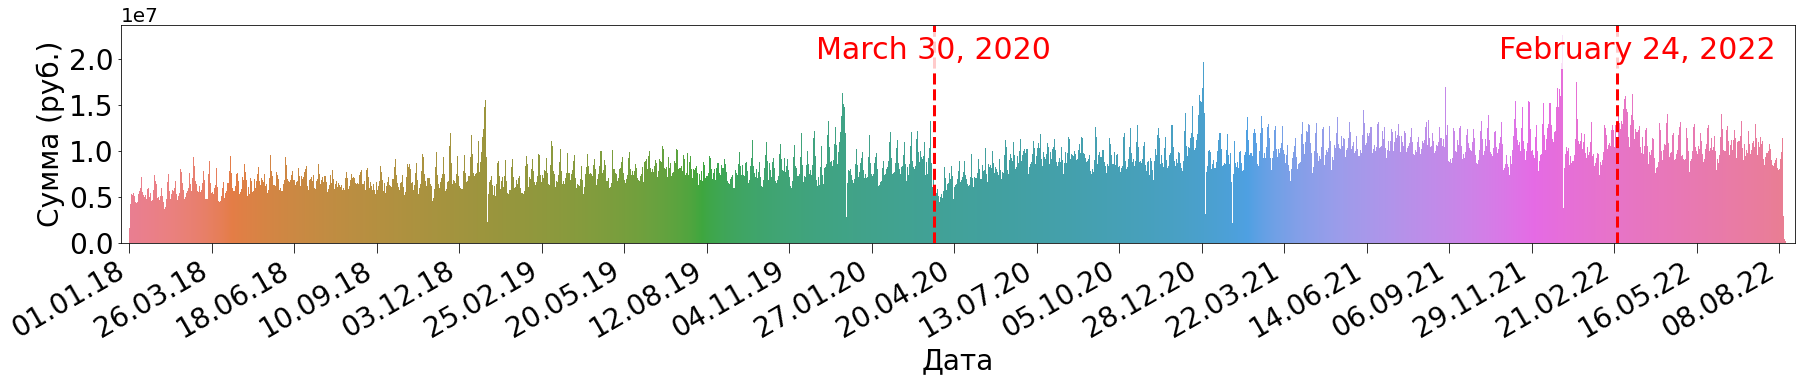

In [ ]:
import matplotlib.dates as md
fig, ax = plt.subplots(figsize = (30, 4))

# specify the position of the major ticks at the beginning of the week
ax.xaxis.set_major_formatter(md.DateFormatter('%d.%m.%y'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)

grouped = df.sort_values(by = 'date').groupby('date')['amt'].sum().reset_index(name='amt')
dates = pd.Series(pd.date_range(df.date.min(),df.date.max())).dt.strftime('%d.%m.%y')
plot = plt.bar(grouped.date, grouped.amt, 
               color=sns.color_palette('husl',len(grouped.date),desat=0.8), width=1);

ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 1, interval=2))
# specify the format of the labels as 'year-month-day'
# set ticks length
ax.tick_params(axis = 'x', which = 'major', length = 10)
ax.tick_params(axis = 'x', which = 'minor', length = 5)

font_size = 28
# for scale's font size ('e7')
plt.rc('axes', titlesize=font_size) 
# set axes labels
plt.xlabel('Дата', fontsize=font_size)
plt.ylabel('Сумма (руб.)', fontsize=font_size)
plt.margins(x=0.005)
plt.xticks(grouped.date[::84], dates[::84], rotation=30, 
           ha='right', fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.axvline(dates[dates=='30.03.20'].index[0], ls='--', lw=3, color='red')
plt.text(dates[dates=='30.03.20'].index[0]-120, 20000000,'March 30, 2020',
         c='red', fontsize=font_size+2, bbox = dict(facecolor='white', alpha=0.8, linewidth=0))

plt.axvline(dates[dates=='24.02.22'].index[0], ls='--', lw=3, color='red')
plt.text(dates[dates=='24.02.22'].index[0]-120, 20000000,'February 24, 2022',
         c='red', fontsize=font_size+2, bbox = dict(facecolor='white', alpha=0.8, linewidth=0))

# show the plot
plt.show();

In [ ]:
df = df[df.client.isin(df.client.value_counts().iloc[:3000].index)]
df.shape

(8265305, 7)

In [ ]:
df.amt = df.amt.astype('int')
df.dtypes

client     int64
card       int64
date      object
amt        int32
mcc        int64
group     object
value     object
dtype: object

Лишний раз убедимся, в каком порядке идут базовые ценности

In [ ]:
pivot_money_tr = pd.pivot_table(df, index='client', columns=['date','value'],
                                    values='amt', aggfunc='sum', fill_value=0)
# Используем следующую конструкцию, чтобы были учтены все дни (даже если там не было транзакций)
pivot_money_tr = pivot_money_tr.stack()
pivot_money_tr = pivot_money_tr.reindex(pd.MultiIndex.from_product(pivot_money_tr.index.levels, 
                                                                       names=pivot_money_tr.index.names), fill_value=0)

In [ ]:
pivot_money_tr

date                      2018-01-01  2018-01-02  2018-01-03  2018-01-04  \
client  value                                                              
2005    self_realization           0        8145           0           0   
        socialization              0           0           0           0   
        survival                   0           0           0           0   
2213    self_realization           0           0           0           0   
        socialization              0           0           0           0   
...                              ...         ...         ...         ...   
3562613 socialization              0           0           0           0   
        survival                   0           0           0           0   
3564569 self_realization           0           0           0           0   
        socialization              0           0           0           0   
        survival                   0           0           0           0   

date                      2018-01-05  2018-01-06  2018-01-07  2018-01-08  \
client  value                                                              
2005    self_realization           0           0           0           0   
        socialization           2491           0           0           0   
        survival                6200           0        1914           0   
2213    self_realization           0           0           0           0   
        socialization              0           0           0           0   
...                              ...         ...         ...         ...   
3562613 socialization              0           0           0           0   
        survival                   0           0           0           0   
3564569 self_realization           0           0           0           0   
        socialization              0           0           0           0   
        survival                   0           0           0           0   

date                      2018-01-09  2018-01-10  ...  2022-08-06  2022-08-07  \
client  value                                     ...                           
2005    self_realization           0         251  ...           0           0   
        socialization              0           0  ...           0           0   
        survival                   0           0  ...           0           0   
2213    self_realization          66           0  ...       19940       24720   
        socialization              0           0  ...         842         590   
...                              ...         ...  ...         ...         ...   
3562613 socialization              0           0  ...          30          30   
        survival                   0           0  ...        1010          59   
3564569 self_realization           0           0  ...        1074           0   
        socialization              0           0  ...           0         125   
        survival                   0           0  ...         708        2087   

date                      2022-08-08  2022-08-09  2022-08-10  2022-08-11  \
client  value                                                              
2005    self_realization           0           0           0           0   
        socialization              0           0           0           0   
        survival                   0           0           0           0   
2213    self_realization         199           0        6000        3000   
        socialization           1061        2606        1584         880   
...                              ...         ...         ...         ...   
3562613 socialization             56          58          28          28   
        survival                   0           0           0           0   
3564569 self_realization           0           0          89           0   
        socialization             96           0           0        2462   
        survival                   0         831        

# Предобработка данных

## Составление датафрейма: факт совершения транзакций, общая сумма за день

In [ ]:
bin_compressed = preprocessing.create_trans_data(df=df, col_clientid='client', col_date='date', 
                                   col_group='value', col_amount='amt')
bin_compressed.head()

bin_trans  \
2005  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,...   
2213  [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...   
3427  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
5044  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...   
5112  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                            money_trans  
2005  [[0, 8145, 0, 0, 0, 0, 0, 0, 0, 251, 0, 0, 632...  
2213  [[0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 0, 0...  
3427  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
5044  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1810,...  
5112  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...

In [ ]:
# Сохраним для того, чтобы получить реальные id клиентов и сумму позже
bin_compressed.to_pickle('1822_real_id_bin_money.pkl')

## Добавление признаков из даты

К данным по транзакциям добавим информацию о дне неделе и месяце, которые были закодированы с помощью синуса и косинуса для обеспечения одинакового расстояния между всеми элементами. 

In [ ]:
feat_df = preprocessing.add_date_features(start_date=df.date.min(), end_date=df.date.max(),
                                          main_feat_trans=bin_compressed['bin_trans'])
feat_df

0       [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [1.0, 0....
1       [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
2       [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
3       [[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
4       [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
                              ...                        
2995    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
2996    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
2997    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
2998    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
2999    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0....
Length: 3000, dtype: object

В итоге, каждый день представляет собой вектор из семи признаков (факт совершения транзакции первой категории, второй, третьей, синус и косинус дня недели, синус и косинус месяца), что дает окончательную размерность признакового пространства для каждого пользователя, равную 546х7.

In [ ]:
feat_df.iloc[0].shape

(1688, 7)

In [ ]:
feat_df.to_pickle("1822_3000_amnt_binclass.pkl", protocol=4)

# Предсказания на микро-уровне (каждый клиент)

## Обучающая и тестовая выборки

Обучаемся на полутора годах(?) 01.01.18-30.06.19. тестируем на 01.07.19 - 31.12.19 (на основе их -- ранняя остановка).

А 2020-2022 года идут на тестовые недели

In [ ]:
days_in_train=365
train_df = feat_df.apply(lambda x: x[ : days_in_train])
test_df = feat_df.apply(lambda x: x[days_in_train : 561])

In [ ]:
np.random.seed(42)

# Зададим порядок клиентов 
clients = list(feat_df.index)
#random_clients = np.random.choice(clients,size=clients.shape[0],replace=False)
#random_clients[:10]
clients[:5]

[0, 1, 2, 3, 4]

## Предсказания для базовой и инкрементальной моделей

In [ ]:
client_dict = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Для каждого клиента отдельная модель

for client_id in tqdm(clients[2:3], desc='clients'):
    b_cats_r = []
    i_cats_r = []
    
    # Получим данные для клиента 
    all_x,all_y,all_test_x,all_test_y = micro_help_functions.get_splits_by_client(client_id, train_df, test_df)
    
    # Для каждой категории отдельная модель
    for cat in range(3):
        
        # Обучаем базовую модель
        cl_model, cl_optimizer, train_losses, test_losses, \
            cl_checkpoint, weights = micro_model_functions.train_model(all_x,all_y,
                                                                       all_test_x,all_test_y, 
                                                                       e_n=1000, lr=0.0005,cat=cat)
        
        # Сохраняем базовую модель, чтобы потом на ее основе сделать инкрементальную модель
        torch.save(cl_checkpoint, f'model_{cat}.pth')
        model_after = micro_model_functions.LSTM_cat_model(input_size=5, hidden_size=64, to_pred=7).to(device)
        checkpoint = torch.load(f'./model_{cat}.pth')
        model_after.load_state_dict(checkpoint['model'])
        
        # Разделим временной интервал тестовой выборки на недели
        days = pd.date_range('2019-01-01','2022-08-08')
        days = np.array(days).reshape(-1,7).astype('datetime64[D]')
        # Получим данные для клиента с указанной датой для дней, которые будут предсказываться
        q = micro_help_functions.get_df_full_y_new(feat_df.loc[client_id][365-28:], 
                                                   min_date='2018-12-04', max_date='2022-08-15')[::7]

        # Результаты базовой модели для тестовых недель
        b_r = micro_model_functions.base_model_data(q,model_after,days,cat=cat)
        b_cats_r.append(b_r)

        # Загружаем базовую модель
        the_checkpoint = torch.load(f'./model_{cat}.pth')
        imodel_after = micro_model_functions.LSTM_cat_model(input_size=5, hidden_size=64, to_pred=7).to(device)
        imodel_after.load_state_dict(the_checkpoint['model'])
        ioptimizer_after = torch.optim.Adam(params=filter(lambda p: p.requires_grad, imodel_after.parameters()),
                                            lr=0.0005)
        ioptimizer_after.load_state_dict(the_checkpoint['optimizer'])
        # Меняем шаг обучения у оптимизатора
        for param_group in ioptimizer_after.param_groups:
            param_group['lr'] = 0.0001
        
        # Результаты инкрементальной модели для тестовых недель
        i_r = micro_model_functions.incr_model_data(q, imodel_after,days,ioptimizer_after, 
                                                    with_weights=False,cat=cat)
        i_cats_r.append(i_r)
    
    # Сохраняем предсказания и реальные значения для двух моделей
    client_dict[client_id] = [b_cats_r,i_cats_r]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
df_2models = pd.DataFrame.from_dict(client_dict).T
#df_2models.to_pickle('/content/drive/MyDrive/master/2nd/the_project/2700-3000_yt_yp_RIGHTV.pkl')
df_2models.columns = [['base','inc']]
df_2models

base  \
2  [[[[0. 0. 0. 0. 0. 0. 0.], [0.541454   0.48680...   

                                                 inc  
2  [[[[0. 0. 0. 0. 0. 0. 0.], [[0.54145396 0.4868...

## Сравнение базовой модели с инкрементальной 

In [ ]:
path_to_2models_data_folder = 'client_data_001_testfrom19/'

# Загрузим данные
df_2models = pd.concat(map(pd.read_pickle, glob.glob(path_to_2models_data_folder+'*.pkl')))
df_2models = df_2models[~df_2models.index.duplicated(keep='first')].sort_index()
df_2models.columns = [['base','inc']]

print(df_2models.shape)
df_2models.head()

(3000, 2)


base  \
0  [[[[0. 1. 0. 1. 0. 0. 1.], [-1.182159   -1.289...   
1  [[[[0. 1. 0. 0. 0. 0. 0.], [1.034886  1.173865...   
2  [[[[0. 0. 0. 0. 0. 0. 0.], [-0.10904915  0.006...   
3  [[[[0. 0. 0. 0. 0. 1. 0.], [0.18922582 0.62491...   
4  [[[[1. 0. 0. 0. 0. 0. 0.], [1.3155253 1.522739...   

                                                 inc  
0  [[[[0. 1. 0. 1. 0. 0. 1.], [[-1.1821591  -1.28...  
1  [[[[0. 1. 0. 0. 0. 0. 0.], [[1.0348861 1.17386...  
2  [[[[0. 0. 0. 0. 0. 0. 0.], [[-0.10904916  0.00...  
3  [[[[0. 0. 0. 0. 0. 1. 0.], [[0.18922582 0.6249...  
4  [[[[1. 0. 0. 0. 0. 0. 0.], [[1.315525  1.52273...

In [ ]:
# Получим значения для каждой модели и "среднее" значение метрики
inc_with_metric, inc_with_metric_3in1, base_with_metric, \
base_with_metric_3in1 = micro_help_functions.get_base_inc_arrays(df_2models, 
                                                                 micro_help_functions.F1metr, n_test_weeks=188)

C:\Users\user\anaconda3\lib\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [ ]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18

font_size = 33
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5])

plt.rc('font', size=font_size)          # controls default text sizes
plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels

plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size)    # legend fontsize
plt.rc('figure', titlesize=font_size)  # fontsize of the figure title

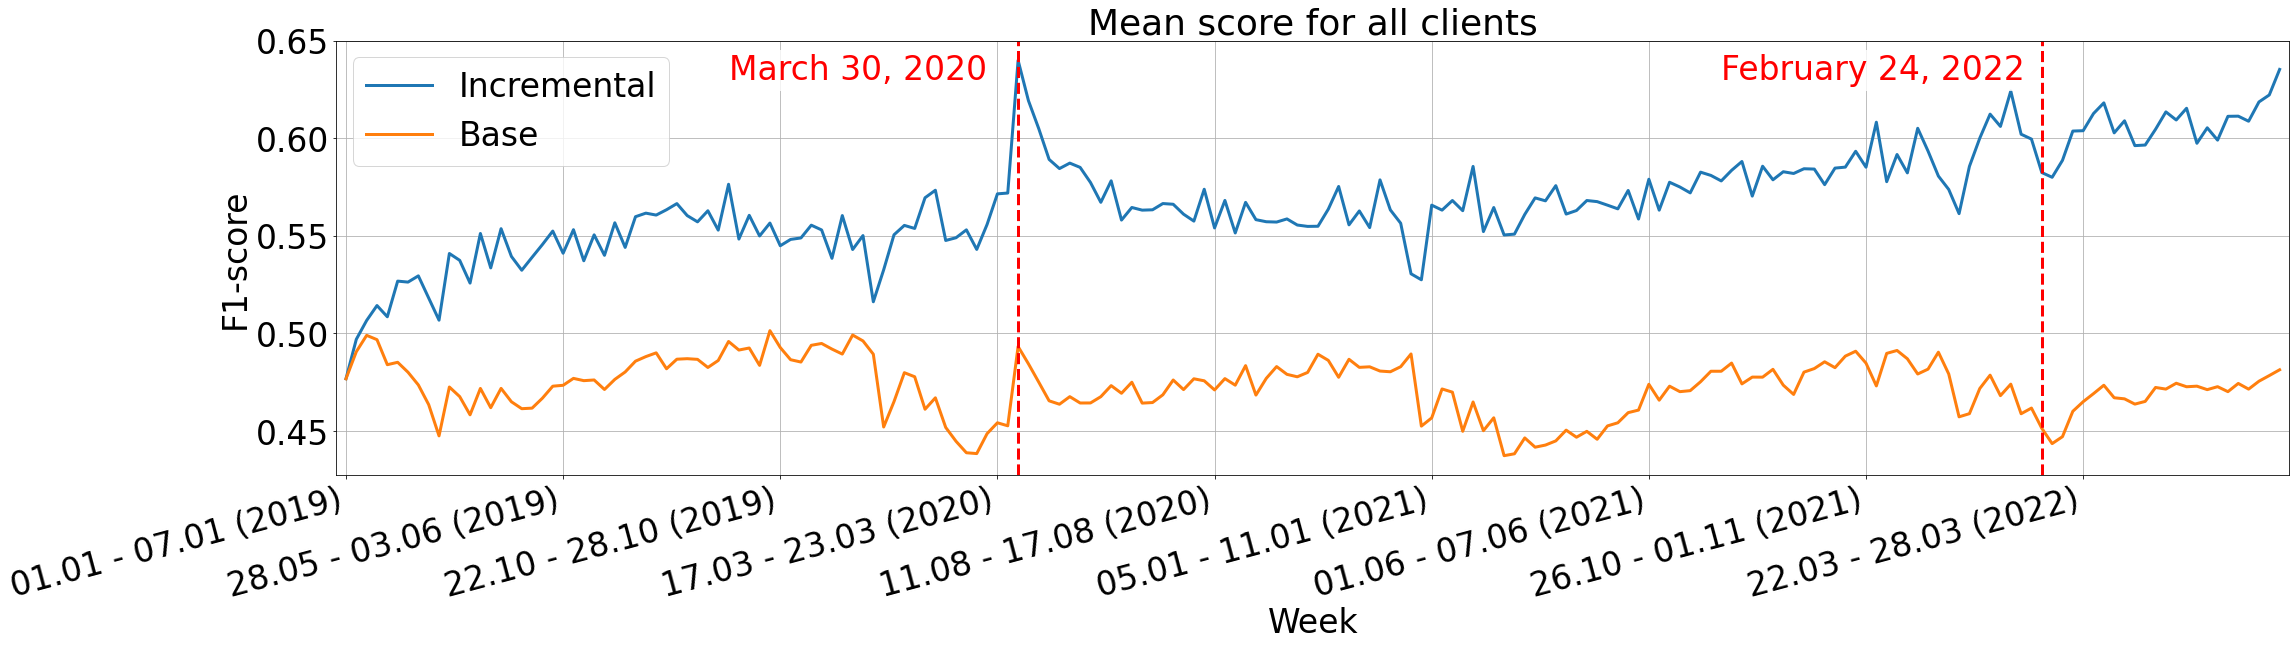

In [ ]:
# Посмотрим на результаты двух моделей на тестовых неделях
plt.rcParams['figure.figsize'] = 35, 8

days_test = pd.date_range('2019-01-01','2022-08-08')
days_test = np.array(days_test).reshape(-1,7).astype('datetime64[D]')
a0 = pd.Series(days_test[:,0]).dt.strftime('%d.%m')
a1 = pd.Series(days_test[:,-1]).dt.strftime('%d.%m (%Y)')

'''
for cat in range(3):
    plt.plot(np.mean(base_with_metric[:,cat,:],0),'r-', alpha=0.1)
    plt.plot(np.mean(inc_with_metric[:,cat,:],0),'b--', alpha=0.15)
'''

plt.plot(a0+' - '+a1, np.mean(inc_with_metric_3in1,0),
         '-',c=cmap.colors[0],label='Incremental',linewidth=3)
plt.plot(a0+' - '+a1, np.mean(base_with_metric_3in1,0),
         '-',c=cmap.colors[1],label='Base',linewidth=3)

plt.xticks((a0+' - '+a1)[::21], rotation=15, ha='right')

plt.axvline(65, ls='--', lw=3, color='red')
plt.text(67-30,0.63,'March 30, 2020',c='red', fontsize=font_size, 
         bbox = dict(facecolor='white', alpha=0.8, linewidth=0))
plt.axvline(164, ls='--', lw=3, color='red')
plt.text(166-33,0.63,'February 24, 2022',c='red', fontsize=font_size, 
         bbox = dict(facecolor='white', alpha=0.8, linewidth=0))

plt.grid()
plt.legend()
plt.margins(x=0.005)

plt.xlabel('Week')
plt.ylabel('F1-score')
plt.title('Mean score for all clients',fontsize=font_size+3);

Средняя разница между результатами двух моделей

In [ ]:
np.mean(np.mean(inc_with_metric_3in1[:,:65],0) - np.mean(base_with_metric_3in1[:,:65],0))

0.06857313276467887

In [ ]:
np.mean(np.mean(inc_with_metric_3in1[:,65:164],0) - np.mean(base_with_metric_3in1[:,65:164],0))

0.10316509524875998

In [ ]:
np.mean(np.mean(inc_with_metric_3in1[:,164:],0) - np.mean(base_with_metric_3in1[:,164:],0))

0.13813069379298928

In [ ]:
np.mean(inc_with_metric_3in1[:,-1],0) - np.mean(base_with_metric_3in1[:,-1],0)

0.15391814585883123

In [ ]:
from scipy.stats import pearsonr, spearmanr
pearsonr(np.mean(base_with_metric_3in1,0),np.mean(inc_with_metric_3in1,0))[0]

-0.021204402622550307

In [ ]:
spearmanr(np.mean(base_with_metric_3in1,0),np.mean(inc_with_metric_3in1,0))[0]

-0.07310364506860126

# Предсказания на мезо- (группы клиентов) и макро- (все клиенты) уровнях 

## Разделение клиентов по группам предсказуемости

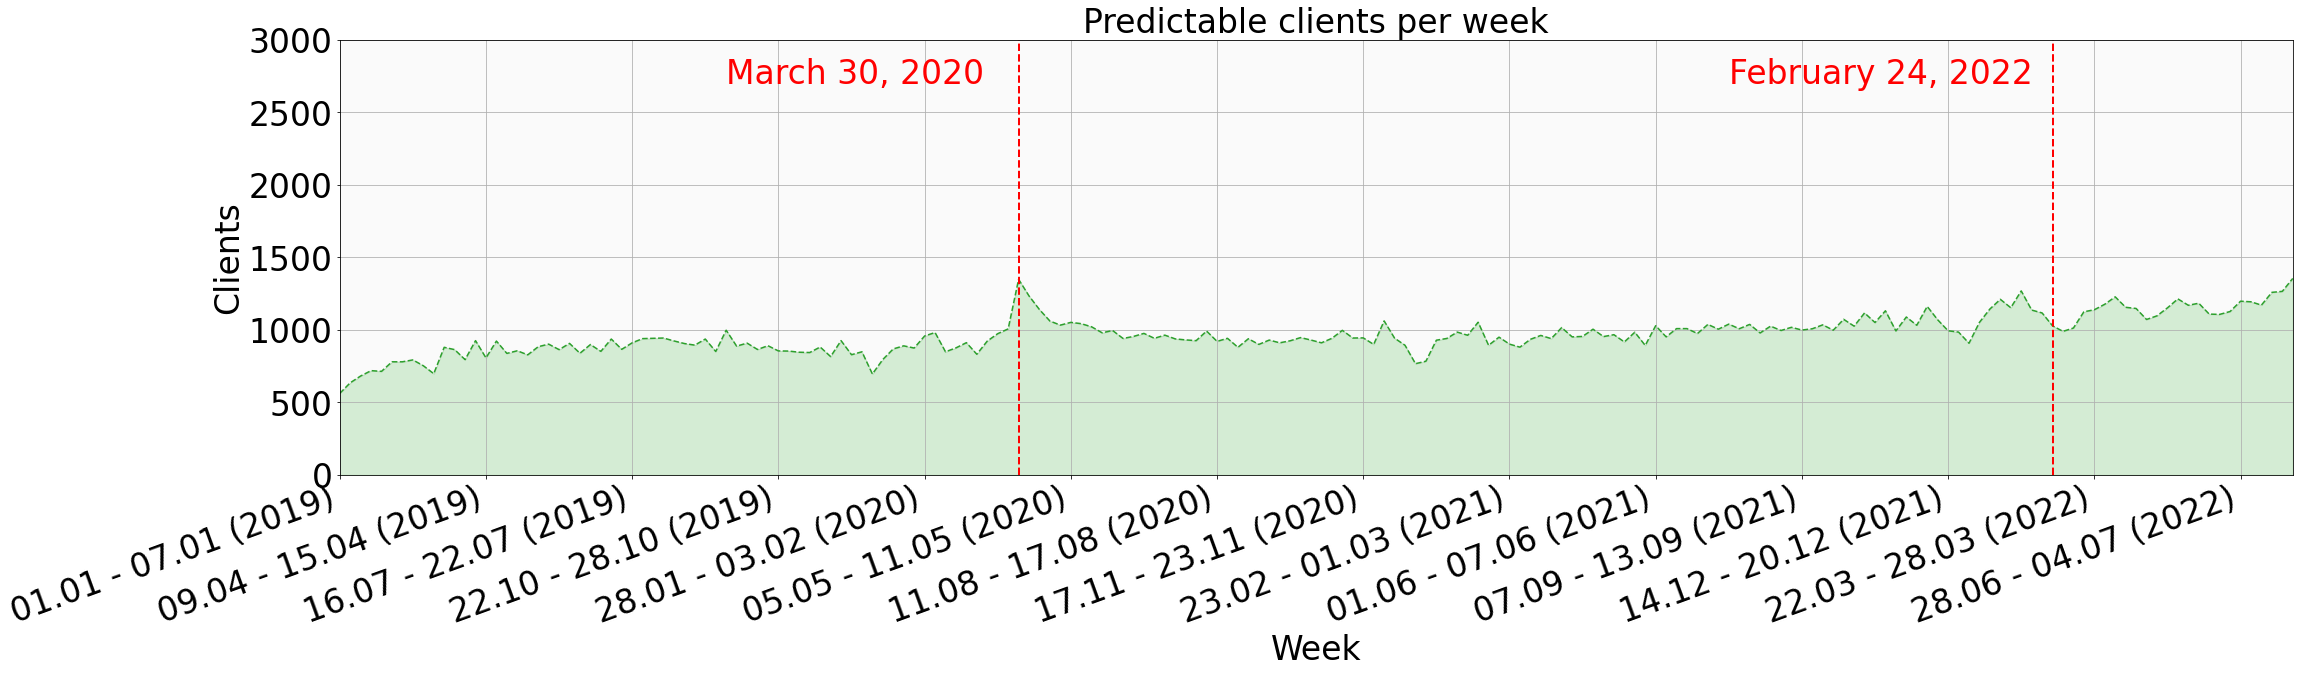

In [ ]:
plt.rcParams['figure.figsize'] = 35, 8
# Посчитаем кол-во хорошо-предсказуемых клиентов для каждой тестовой недели
threshold = 0.7
# если метрика на опр. неделю выше порога -- ставим 1.
bool_clients = np.array([[int(x_week>threshold) for x_week in user] for user in inc_with_metric_3in1])

plt.plot((a0+' - '+a1), bool_clients.sum(0),'--',color=cmap.colors[2])
plt.fill_between((a0+' - '+a1),bool_clients.sum(0), 0, color=cmap.colors[2], alpha=0.2)
plt.fill_between((a0+' - '+a1),3000, bool_clients.sum(0), color='gray', alpha=0.04)

plt.ylim(0,3000)
plt.margins(x=0)

plt.axvline(65, ls='--', lw=2, color='red')
plt.text(67-30,2700,'March 30, 2020',c='red')
plt.axvline(164, ls='--', lw=2, color='red')
plt.text(166-33,2700,'February 24, 2022',c='red')

plt.xticks((a0+' - '+a1)[::14], rotation=20, ha='right')

plt.title('Predictable clients per week')
plt.grid()
plt.ylabel('Clients')
plt.xlabel('Week');

In [ ]:
# Берем данные с реальными id
df_real_id = pd.read_pickle('1822_real_id_bin_money.pkl')
df_real_id.head()

bin_trans  \
2005  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,...   
2213  [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...   
3427  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
5044  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...   
5112  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                            money_trans  
2005  [[0, 8145, 0, 0, 0, 0, 0, 0, 0, 251, 0, 0, 632...  
2213  [[0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 0, 0...  
3427  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
5044  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1810,...  
5112  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...

### Переходы между неделями (Sankey)

In [ ]:
def between_weeks(from_week,to_week):
    good_clients_idx = np.where(bool_clients[:,from_week]==1)
    bad_clients_idx = np.where(bool_clients[:,from_week]==0)

    good_clients_idx2 = np.where(bool_clients[:,to_week]==1)
    bad_clients_idx2 = np.where(bool_clients[:,to_week]==0)

    good_good = np.intersect1d(good_clients_idx, good_clients_idx2).shape[0]
    good_bad = np.intersect1d(good_clients_idx, bad_clients_idx2).shape[0]
    bad_bad = np.intersect1d(bad_clients_idx, bad_clients_idx2).shape[0]
    bad_good = np.intersect1d(bad_clients_idx, good_clients_idx2).shape[0]

    return good_good,good_bad,bad_bad,bad_good

In [ ]:
import plotly.io as pio
pio.renderers.default = 'iframe'

In [ ]:
import plotly.graph_objects as go

In [ ]:
n_weeks = 188

In [ ]:
a1[0].split(' ')

['07.01', '(2019)']

In [ ]:
values = []
for i in range(n_weeks-1):
    values.extend(between_weeks(i,i+1))

targets = []
for i in range(2,n_weeks*2-1,2):
    targets.extend([i,i+1,i+1,i])

fig = go.Figure(data=[go.Sankey(
    orientation='h',
    arrangement ="freeform",
    node = dict(
       
      pad = 5,
      thickness = 2,
      line = dict(color = "black", width = 0.3),
      label = [f"{group}<br>{(a0+'<br>-<br>'+a1)[i]}" if i%2==0 else '' for i in range(n_weeks) for group in ['good','bad']], # ["good_0", "bad_0", "good_1", "bad_1",],
      color = ["rgba(122, 204, 155, 0.6)",'rgba(173,173,173, 0.5)']*n_weeks
      #x = np.repeat(np.linspace(0.001,0.999,25),2),  # не работает!    
      
    ),
    
    link = dict(
      source = [i for i in range(n_weeks*2-2) for _ in range(2)], # [0,0,1,1, 2,2,3,3, ...]
      target = targets, # [2,3,3,2, 4,5,5,4, ...]
      value = values,
      color = ["rgba(122, 204, 155, 0.3)","rgba(122, 204, 155, 0.3)",
               'rgba(173,173,173, 0.3)','rgba(173,173,173, 0.3)']*n_weeks
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", 
                  font_size=9, autosize=False,width=7500, height=500,margin=dict(l=20, r=150, t=20,b=50))
fig.show()

In [ ]:
jumps=[]

for i in range(3000):
    jumps.append(np.where(bool_clients[i,:-1] != bool_clients[i,1:])[0].shape[0])

# кол-во клиентов без переходов
np.where(np.array(jumps)==0)[0].shape

(0,)

In [ ]:
# id "постоянных" клиентов
np.where(np.array(jumps)==0)[0]

array([], dtype=int64)

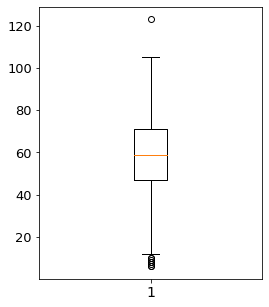

In [ ]:
plt.rcParams['figure.figsize'] = 4, 5

# в среднем 17 переходов у всех
plt.boxplot(pd.Series(jumps));

In [ ]:
np.median(jumps)

59.0

### Возвращаемся

In [ ]:
#14: понедельник, 1 апреля 2019 — воскресенье, 7 апреля 2019
#40: понедельник, 30 сентября 2019 — воскресенье, 6 октября 2019

nth_week=39

good_clients_id, good_rw, \
bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)

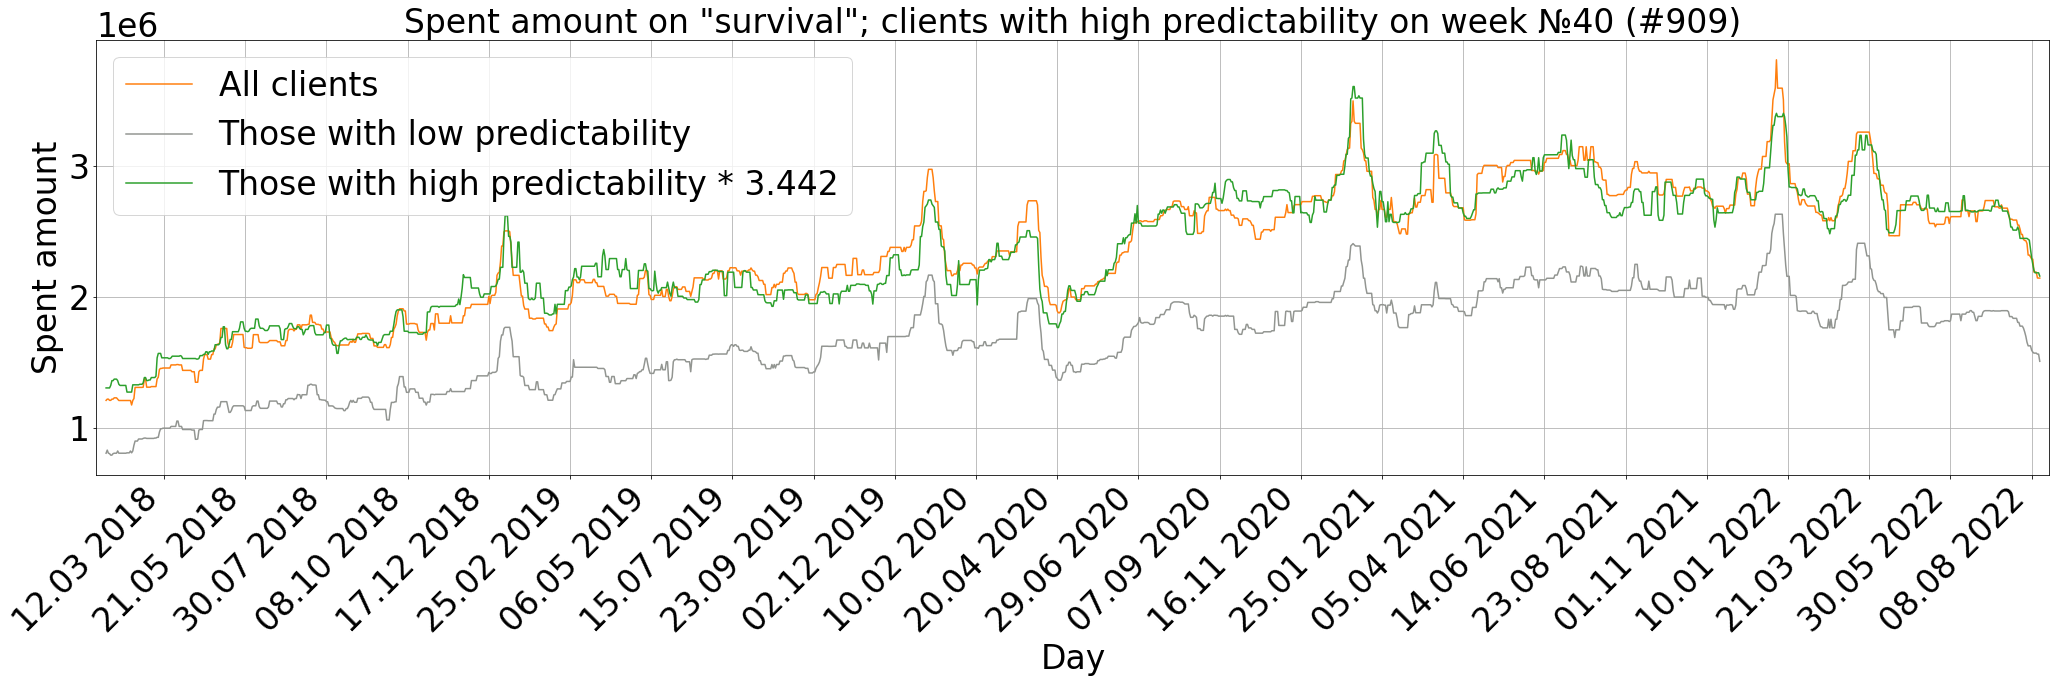

In [ ]:
# Посмотрим на суммы разных групп клиентов
dates = pd.Series(pd.date_range('2018-01-01','2022-08-15')).dt.strftime('%d.%m %Y')
fig = plt.figure(figsize=(35, 8))

plt.plot(dates, all_rw, '-', c=cmap.colors[1], label='All clients')
#plt.plot(dates, good_rw, '-', c='xkcd:seaweed',label=f'Хорошо предсказумые')
plt.plot(dates, bad_rw, '-', c='xkcd:gray',label='Those with low predictability')
coeff_good = all_rw.mean()/good_rw.mean()
plt.plot(dates, good_rw*coeff_good, '-',c=cmap.colors[2],label=f'Those with high predictability * {coeff_good:.3f}',lw=1.5)

plt.title(f'Spent amount on "survival"; clients with high predictability on week №{nth_week+1} (#{good_clients_id.shape[0]})')
plt.xlabel('Day')
plt.ylabel('Spent amount')

plt.grid()
plt.xticks(dates[::70], rotation=45, ha='right')
plt.margins(x=0.005)
plt.legend();

## Предсказания

Инкрементально предсказываются 7 дней от последнего дня недели, у которой считали хороших клиентов.

### Задаем нужные параметры

In [ ]:
good_clients_id, good_rw, \
bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,0,window_size=21)

In [ ]:
days_test2 = pd.date_range('2020-01-01','2022-08-09')
days_test2 = np.array(days_test2).reshape(-1,7).astype('datetime64[D]')

a0_md = pd.Series(days_test2[:,0]).dt.strftime('%m.%d')
a1_md = pd.Series(days_test2[:,-1]).dt.strftime('%m.%d')

a0_dm = pd.Series(days_test2[:,0]).dt.strftime('%d.%m.%Y')
a1_dm = pd.Series(days_test2[:,-1]).dt.strftime('%d.%m.%Y')

In [ ]:
# Задаем гиперпараметры модели
n_epochs_each_model = 20
n_batch_each_model = 1
lr_each_model = 0.000005
n_neurons_each_model = 60

days = pd.date_range('2018.01.01',f'2022.08.15')
days = pd.Series(days).dt.strftime('%d.%m.%Y')
last_day = days[days==f'{a1_dm[0]}'].index[0]
shift_days = good_rw.first_valid_index() # при скользящей медиане сдвинулись 
n_weeks=136

# Параметры для моделей
dim=28 #размерность вложения
mem=5 #глубина памяти для LSTM
split= days.shape[0]-last_day-1 #Разбиение ряда для обучения\прогноза (от конца)
fwd = 7 # На сколько дней предсказываем на тестовой

# для воспроизводимости рез-в
the_chosen_seed = 1108

reset_seeds(seed_value = the_chosen_seed)

In [ ]:
font_size = 20
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5])

plt.rc('font', size=font_size)          # controls default text sizes
plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels

plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size)    # legend fontsize
plt.rc('figure', titlesize=font_size)  # fontsize of the figure title

### Хорошо предсказуемые

0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

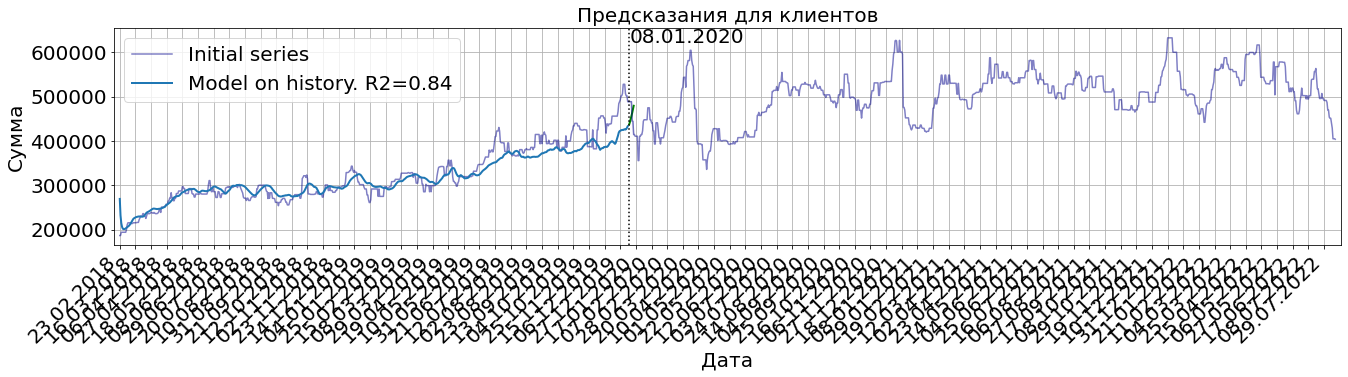

In [ ]:
# Найдем клиентов в группах предсказуемости на заданной неделе
nth_week = 0
good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)
# предобработка
scaler, x, y, dat = macro_help_functions.prepare_data(good_rw.iloc[shift_days:], split, dim, mem)
# обучаем модель
model, fwd_mapes, full_fwd_pred_tr, \
    full_fwd_true, y_pred_tr, y_true = macro_model_functions.make_model(scaler, x, y, dat, good_rw.iloc[shift_days:],
                                                                        dim, mem, split, fwd, \
                                                                        n_epochs_each_model, n_batch_each_model,
                                                                        n_neurons_each_model,lr_each_model)
# смотрим, как хорошо подстроилась под обучающую выборку
plt.rcParams['figure.figsize'] = 22, 4
r = macro_help_functions.plot_clients_pred(good_rw.iloc[shift_days:], full_fwd_pred_tr,full_fwd_true,y_true,y_pred_tr,
        dim, mem, split, fwd, days, tick_freq=21,shift_days=shift_days)
plt.margins(x=0.005)

In [ ]:
days.iloc[-split]

'08.01.2020'

  0%|          | 0/134 [00:00<?, ?it/s]

test MAPE median: 6.482%
test MAPE HP: 39.259%


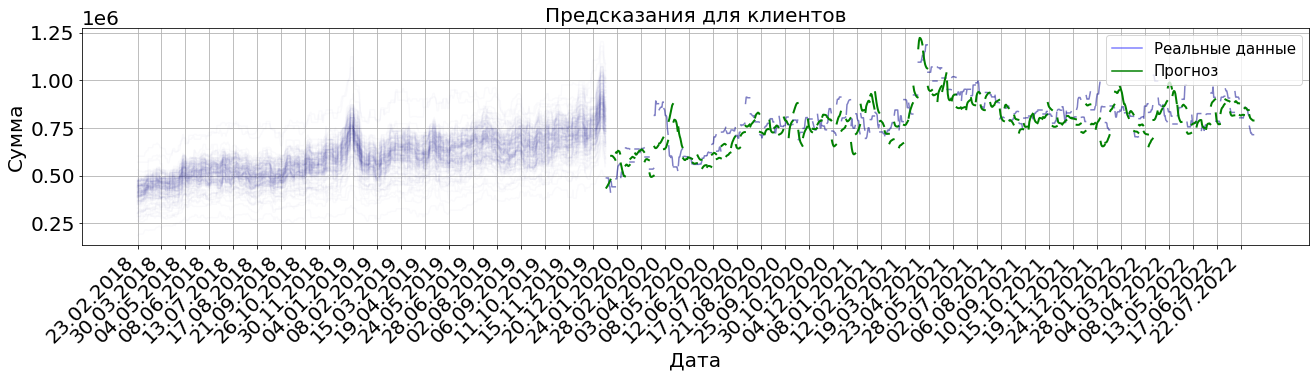

In [ ]:
next_fwd_mapes = fwd_mapes.copy()
next_full_fwd_pred_tr = full_fwd_pred_tr.copy()
next_full_fwd_true = full_fwd_true.copy()

# Для каждой недели
for nth_week in trange(1,n_weeks-1):
    # ищем группы клиентов
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)
    # считаем день, с которого начинаем предсказывать
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    # Предсказываем (без обучения)
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(next_good_rw.iloc[shift_days:], next_split, dim, mem, 0)
    next_fwd_mapes, next_full_fwd_pred_tr, next_full_fwd_true = macro_model_functions.make_pred_base_model(model, next_scaler, next_dat, next_good_rw,
                            dim, mem, next_split, fwd,
                            next_fwd_mapes, next_full_fwd_pred_tr, next_full_fwd_true)

# смотрим на результаты на тестовой выборке    
print(f'test MAPE median: {np.median(np.array(next_fwd_mapes)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes)<=0.05)[0].shape[0] / np.array(next_fwd_mapes).shape[0]) * 100 :.3f}%')    
r = macro_help_functions.plot_clients_pred_base('good',a1_dm,df_2models,df_real_id,bool_clients,
                                                next_full_fwd_pred_tr, next_full_fwd_true,split,
                                                dim, mem, fwd, days, tick_freq=35,n_weeks=n_weeks,shift_days=shift_days)

line1 = Line2D([0], [0], label='Реальные данные', color='blue', alpha=0.5)
line2 = Line2D([0], [0], label='Прогноз', color='green')
plt.legend(handles=[line1, line2], loc='upper right', fontsize=15);

In [ ]:

model.save("exp_data/good/model_good.h5")

np.save('exp_data/good/next_fwd_mapes', np.array(next_fwd_mapes))
np.save('exp_data/good/next_full_fwd_pred_tr', np.array(next_full_fwd_pred_tr))
np.save('exp_data/good/next_full_fwd_true', np.array(next_full_fwd_true))


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('exp_data/good/model_good.h5')
next_fwd_mapes = np.load('exp_data/good/next_fwd_mapes.npy')
next_full_fwd_pred_tr = np.load('exp_data/good/next_full_fwd_pred_tr.npy')
next_full_fwd_true = np.load('exp_data/good/next_full_fwd_true.npy')

print(f'test MAPE median: {np.median(np.array(next_fwd_mapes)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes)<=0.05)[0].shape[0] / np.array(next_fwd_mapes).shape[0]) * 100 :.3f}%') 

test MAPE median: 6.482%
test MAPE HP: 39.259%


HP(Hit Probability): процент ошибок меньше заданного интервала

#### Выделяя группы только 1 раз.

In [ ]:
good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,13,window_size=21)
print(good_clients_id.shape)
good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,39,window_size=21)
print(good_clients_id.shape)
good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,51,window_size=21)
print(good_clients_id.shape)

(926,)
(909,)
(696,)


0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

week №13
test MAPE median: 9.259%
test MAPE HP: 25.926%


0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

week №51
test MAPE median: 6.609%
test MAPE HP: 38.519%


0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

week №39
test MAPE median: 5.518%
test MAPE HP: 42.963%


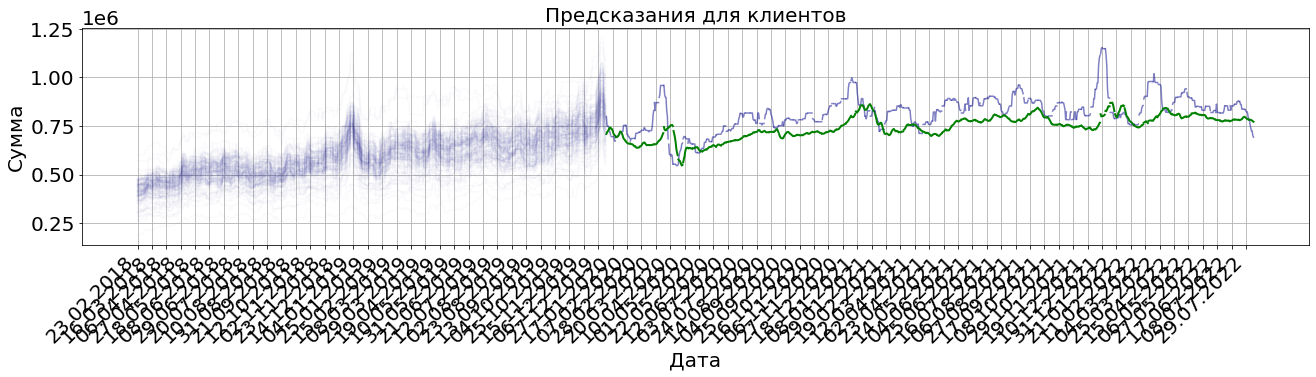

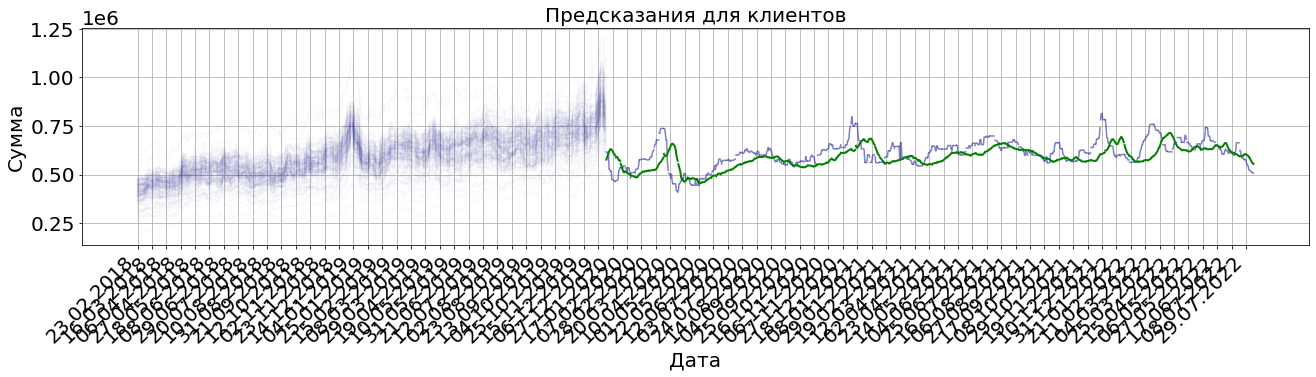

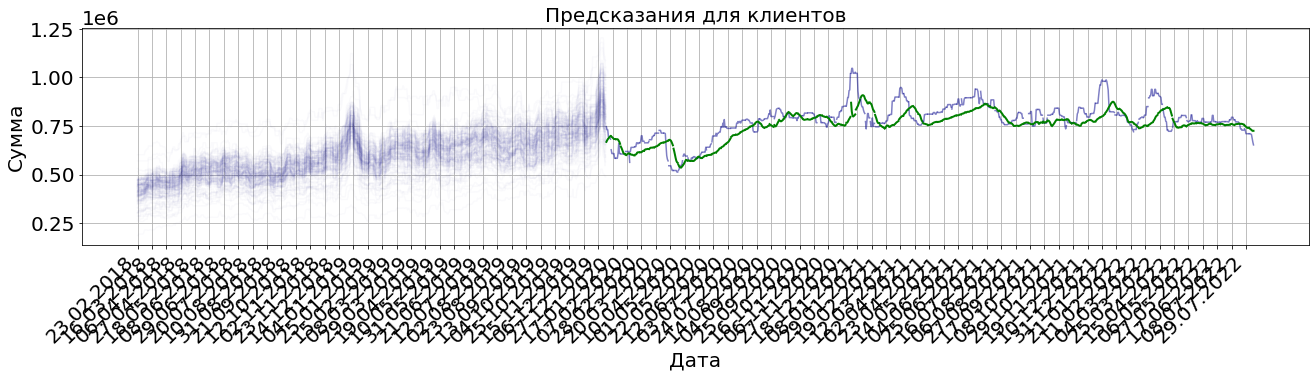

In [ ]:
plt.rcParams['figure.figsize'] = 22, 4
for_weeks_next_fwd_mapes_1t = []
for_weeks_next_full_fwd_pred_tr_1t = []
for_weeks_next_full_fwd_true_1t = []
models_14_52_40 = []

nth_week = 0
# для каждой заданной недели
for week_to_test in [13,51,39]:
    reset_seeds(seed_value = the_chosen_seed)
    
    good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,week_to_test,window_size=21)

    scaler, x, y, dat = macro_help_functions.prepare_data(good_rw.iloc[shift_days:], split, dim, mem)

    model_temp, fwd_mapes_temp, full_fwd_pred_tr_temp, \
        full_fwd_true_temp, y_pred_tr, y_true = macro_model_functions.make_model(scaler, x, y, dat, good_rw.iloc[shift_days:],
                                                                            dim, mem, split, fwd, \
                                                                            n_epochs_each_model, n_batch_each_model,
                                                                            n_neurons_each_model,lr_each_model) 
    next_fwd_mapes_1t = fwd_mapes_temp.copy()
    next_full_fwd_pred_tr_1t = full_fwd_pred_tr_temp.copy()
    next_full_fwd_true_1t = full_fwd_true_temp.copy()

    # Для каждой тестовой недели
    for nth_week in trange(1,n_weeks-1):
        # считаем день, с которого начинаем предсказывать
        last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
        next_split= days.shape[0]-last_day-1

        # Предсказываем (без обучения)
        next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(good_rw.iloc[shift_days:], next_split, dim, mem, 0)
        next_fwd_mapes_1t, next_full_fwd_pred_tr_1t, next_full_fwd_true_1t = macro_model_functions.make_pred_base_model(model_temp, next_scaler, next_dat, good_rw,
                                dim, mem, next_split, fwd,
                                next_fwd_mapes_1t, next_full_fwd_pred_tr_1t, next_full_fwd_true_1t)
    # запомним рез-ты
    for_weeks_next_fwd_mapes_1t.append(next_fwd_mapes_1t)
    for_weeks_next_full_fwd_pred_tr_1t.append(next_full_fwd_pred_tr_1t)
    for_weeks_next_full_fwd_true_1t.append(next_full_fwd_true_1t)
    models_14_52_40.append(model_temp)
        
    r = macro_help_functions.plot_clients_pred_base('good',a1_dm,df_2models,df_real_id,bool_clients,
                                                next_full_fwd_pred_tr_1t, next_full_fwd_true_1t,split,
                                                dim, mem, fwd, days, tick_freq=21, n_weeks=n_weeks,shift_days=shift_days)
    print(f'week №{week_to_test}')
    print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_1t)) *100 :.3f}%')
    print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_1t)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_1t).shape[0]) * 100 :.3f}%')
    
# запишем рез-ты в переменные для отд.недель
next_fwd_mapes_1t14, next_fwd_mapes_1t52, next_fwd_mapes_1t = for_weeks_next_fwd_mapes_1t
next_full_fwd_pred_tr_1t14, next_full_fwd_pred_tr_1t52, next_full_fwd_pred_tr_1t = for_weeks_next_full_fwd_pred_tr_1t
next_full_fwd_true_1t14, next_full_fwd_true_1t52, next_full_fwd_true_1t = for_weeks_next_full_fwd_true_1t
model_14, model_52, model_40 = models_14_52_40

In [ ]:
# SAVING

model_14.save("exp_data/good/model_14.h5")
model_52.save("exp_data/good/model_52.h5")
model_40.save("exp_data/good/model_40.h5")

np.save('exp_data/good/next_fwd_mapes_1t14', np.array(next_fwd_mapes_1t14))
np.save('exp_data/good/next_fwd_mapes_1t52', np.array(next_fwd_mapes_1t52))
np.save('exp_data/good/next_fwd_mapes_1t', np.array(next_fwd_mapes_1t))

np.save('exp_data/good/next_full_fwd_pred_tr_1t14', np.array(next_full_fwd_pred_tr_1t14))
np.save('exp_data/good/next_full_fwd_pred_tr_1t52', np.array(next_full_fwd_pred_tr_1t52))
np.save('exp_data/good/next_full_fwd_pred_tr_1t', np.array(next_full_fwd_pred_tr_1t))

np.save('exp_data/good/next_full_fwd_true_1t14', np.array(next_full_fwd_true_1t14))
np.save('exp_data/good/next_full_fwd_true_1t52', np.array(next_full_fwd_true_1t52))
np.save('exp_data/good/next_full_fwd_true_1t', np.array(next_full_fwd_true_1t))


In [ ]:
# LOADING
model_14 = load_model('exp_data/good/model_14.h5')
model_52 = load_model('exp_data/good/model_52.h5')
model_40 = load_model('exp_data/good/model_40.h5')

next_fwd_mapes_1t14 = np.load('exp_data/good/next_fwd_mapes_1t14.npy')
next_fwd_mapes_1t52 = np.load('exp_data/good/next_fwd_mapes_1t52.npy')
next_fwd_mapes_1t = np.load('exp_data/good/next_fwd_mapes_1t.npy')

next_full_fwd_pred_tr_1t14 = np.load('exp_data/good/next_full_fwd_pred_tr_1t14.npy')
next_full_fwd_pred_tr_1t52 = np.load('exp_data/good/next_full_fwd_pred_tr_1t52.npy')
next_full_fwd_pred_tr_1t = np.load('exp_data/good/next_full_fwd_pred_tr_1t.npy')

next_full_fwd_true_1t14 = np.load('exp_data/good/next_full_fwd_true_1t14.npy')
next_full_fwd_true_1t52 = np.load('exp_data/good/next_full_fwd_true_1t52.npy')
next_full_fwd_true_1t = np.load('exp_data/good/next_full_fwd_true_1t.npy')

print(f'week №14')
print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_1t14)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_1t14)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_1t14).shape[0]) * 100 :.3f}%')
print(f'week №52')    
print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_1t52)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_1t52)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_1t52).shape[0]) * 100 :.3f}%')
print(f'week №40')
print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_1t)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_1t)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_1t).shape[0]) * 100 :.3f}%')

week №14
test MAPE median: 9.259%
test MAPE HP: 25.926%
week №52
test MAPE median: 6.609%
test MAPE HP: 38.519%
week №40
test MAPE median: 5.518%
test MAPE HP: 42.963%


### Все клиенты

0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

test MAPE median: 12.835%
test MAPE HP: 18.519%


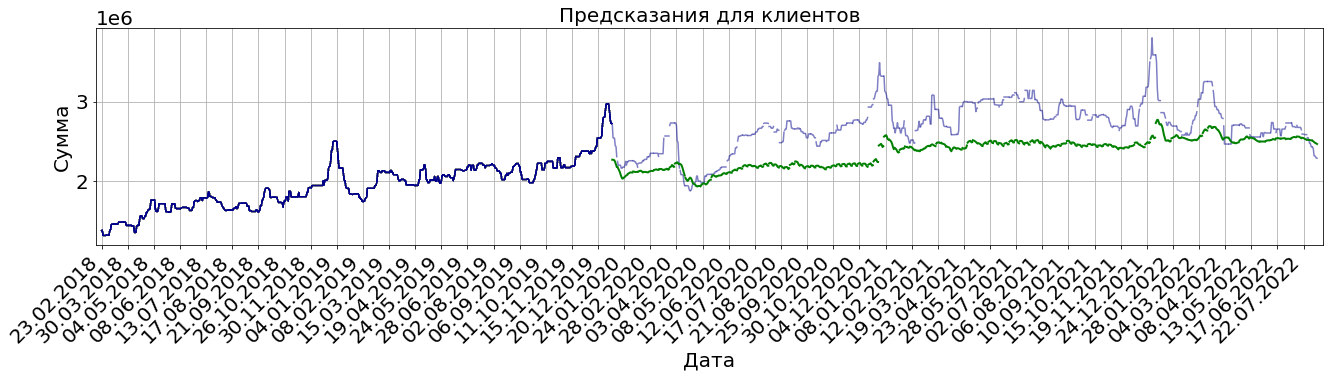

In [ ]:
nth_week = 0
good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)
scaler_all, x_all, y_all, dat_all = macro_help_functions.prepare_data(all_rw.iloc[shift_days:], split, dim, mem)

model_all, fwd_mapes_all, full_fwd_pred_tr_all, full_fwd_true_all, \
                    y_pred_tr_all, y_true_all = macro_model_functions.make_model(scaler_all, x_all, y_all, dat_all, all_rw.iloc[shift_days:],
                                                                                dim, mem, split, fwd, \
                                                                                n_epochs_each_model, n_batch_each_model,n_neurons_each_model,lr_each_model)
next_fwd_mapes_all = fwd_mapes_all.copy()
next_full_fwd_pred_tr_all = full_fwd_pred_tr_all.copy()
next_full_fwd_true_all = full_fwd_true_all.copy()

good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,0,window_size=21)

for nth_week in trange(1,n_weeks-1):
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(next_all_rw.iloc[shift_days:], next_split, dim, mem, 0)
    
    next_fwd_mapes_all, next_full_fwd_pred_tr_all, next_full_fwd_true_all = macro_model_functions.make_pred_base_model(model_all, next_scaler, next_dat, 
                            next_all_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            next_fwd_mapes_all, next_full_fwd_pred_tr_all, next_full_fwd_true_all)

print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_all)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_all)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_all).shape[0]) * 100 :.3f}%')
r = macro_help_functions.plot_clients_pred_base('all',a1_dm,df_2models,df_real_id,bool_clients,
                                                next_full_fwd_pred_tr_all, next_full_fwd_true_all,split,
                                                dim, mem, fwd, days, 35,n_weeks,shift_days)
plt.margins(x=0.005)

In [ ]:

model_all.save("exp_data/all/model_all.h5")

np.save('exp_data/all/next_fwd_mapes_all', np.array(next_fwd_mapes_all))
np.save('exp_data/all/next_full_fwd_pred_tr_all', np.array(next_full_fwd_pred_tr_all))
np.save('exp_data/all/next_full_fwd_true_all', np.array(next_full_fwd_true_all))


In [ ]:
model_all = load_model('exp_data/all/model_all.h5')
next_fwd_mapes_all = np.load('exp_data/all/next_fwd_mapes_all.npy')
next_full_fwd_pred_tr_all = np.load('exp_data/all/next_full_fwd_pred_tr_all.npy')
next_full_fwd_true_all = np.load('exp_data/all/next_full_fwd_true_all.npy')

print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_all)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_all)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_all).shape[0]) * 100 :.3f}%') 

test MAPE median: 12.835%
test MAPE HP: 18.519%


### Плохо предсказуемые

0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

test MAPE median: 12.342%
test MAPE HP: 14.815%


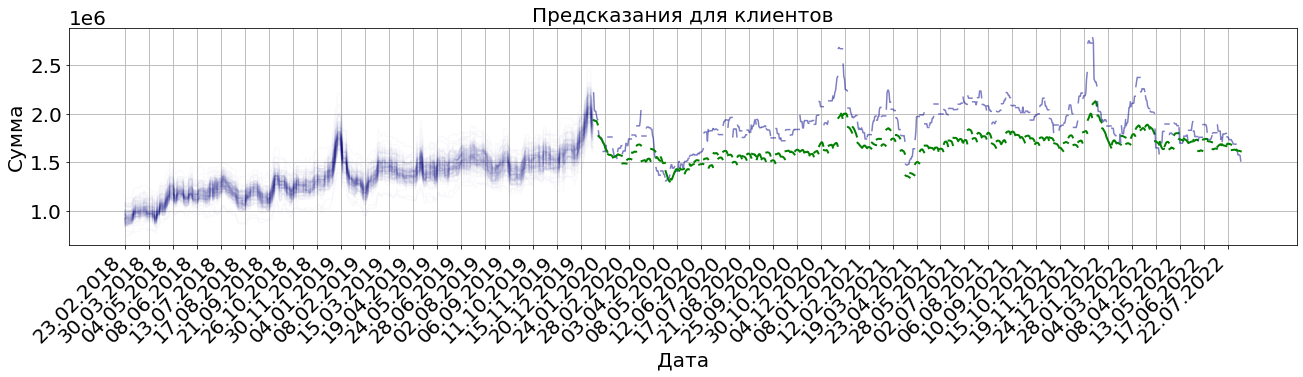

In [ ]:
nth_week = 0
good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)
scaler_bad, x_bad, y_bad, dat_bad = macro_help_functions.prepare_data(bad_rw.iloc[shift_days:], split, dim, mem)

model_bad, fwd_mapes_bad, full_fwd_pred_tr_bad, full_fwd_true_bad, \
                    y_pred_tr_bad, y_true_bad = macro_model_functions.make_model(scaler_bad, x_bad, y_bad, dat_bad, bad_rw.iloc[shift_days:],
                                                                                dim, mem, split, fwd, \
                                                                                n_epochs_each_model, n_batch_each_model,n_neurons_each_model,lr_each_model)
next_fwd_mapes_bad = fwd_mapes_bad.copy()
next_full_fwd_pred_tr_bad = full_fwd_pred_tr_bad.copy()
next_full_fwd_true_bad = full_fwd_true_bad.copy()

for nth_week in trange(1,n_weeks-1):
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)

    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(next_bad_rw.iloc[shift_days:], next_split, dim, mem, 0)
    
    next_fwd_mapes_bad, next_full_fwd_pred_tr_bad, next_full_fwd_true_bad = macro_model_functions.make_pred_base_model(model_bad, next_scaler, next_dat, 
                            next_bad_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            next_fwd_mapes_bad, next_full_fwd_pred_tr_bad, next_full_fwd_true_bad)
    
print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_bad)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_bad)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_bad).shape[0]) * 100 :.3f}%')
r = macro_help_functions.plot_clients_pred_base('bad',a1_dm,df_2models,df_real_id,bool_clients,
                                                next_full_fwd_pred_tr_bad, next_full_fwd_true_bad,split,
                                                dim, mem, fwd, days, 35, n_weeks,shift_days)

In [ ]:

model_bad.save("exp_data/bad/model_bad.h5")

np.save('exp_data/bad/next_fwd_mapes_bad', np.array(next_fwd_mapes_bad))
np.save('exp_data/bad/next_full_fwd_pred_tr_bad', np.array(next_full_fwd_pred_tr_bad))
np.save('exp_data/bad/next_full_fwd_true_bad', np.array(next_full_fwd_true_bad))


In [ ]:
model_bad = load_model('exp_data/bad/model_bad.h5')
next_fwd_mapes_bad = np.load('exp_data/bad/next_fwd_mapes_bad.npy')
next_full_fwd_pred_tr_bad = np.load('exp_data/bad/next_full_fwd_pred_tr_bad.npy')
next_full_fwd_true_bad = np.load('exp_data/bad/next_full_fwd_true_bad.npy')

print(f'test MAPE median: {np.median(next_fwd_mapes_bad) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(next_fwd_mapes_bad<=0.05)[0].shape[0] / next_fwd_mapes_bad.shape[0]) * 100 :.3f}%') 

test MAPE median: 12.342%
test MAPE HP: 14.815%


#### Выделяя 1 раз

0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

week №13
test MAPE median: 5.435%
test MAPE HP: 45.926%


0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

week №51
test MAPE median: 12.243%
test MAPE HP: 17.778%


0epoch [00:00, ?epoch/s]

Predict on train data:   0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

week №39
test MAPE median: 9.100%
test MAPE HP: 21.481%


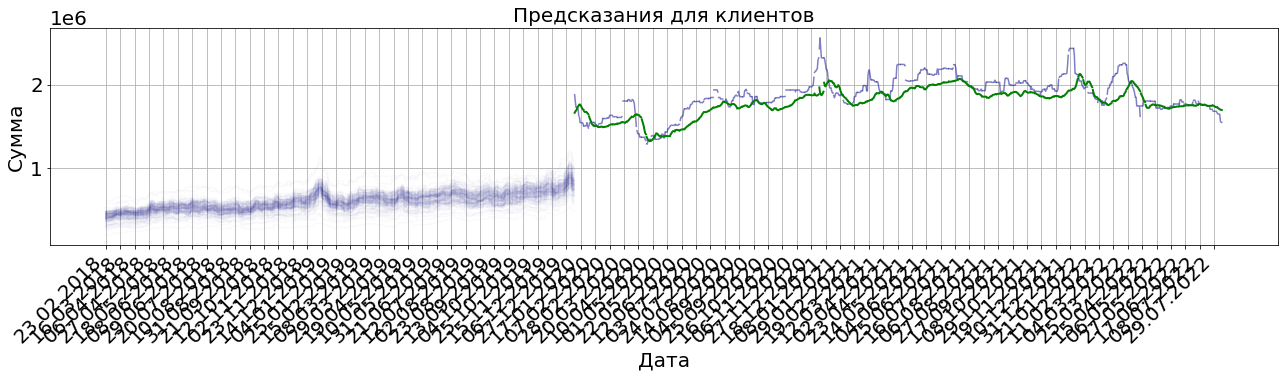

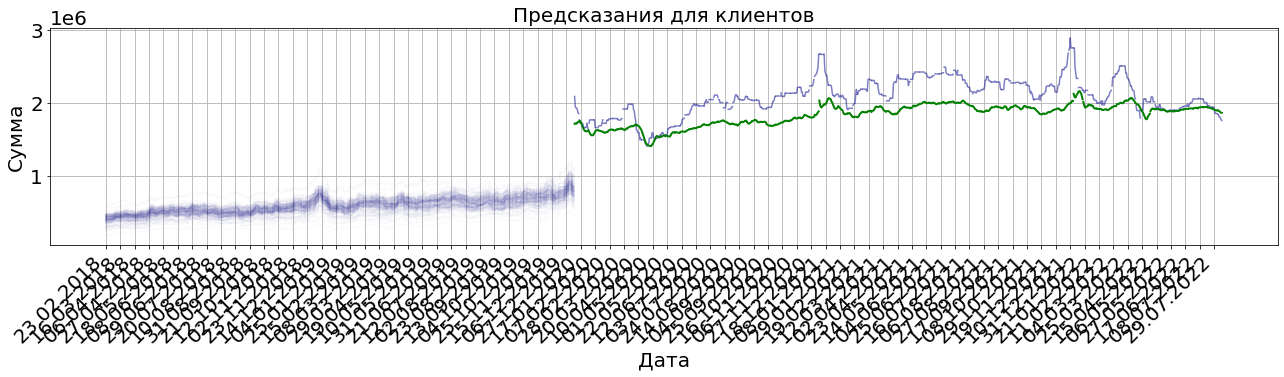

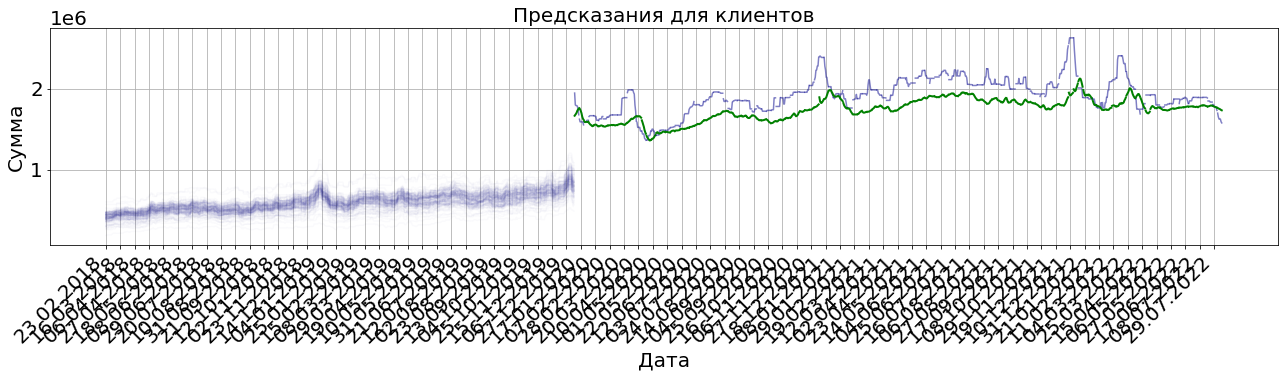

In [ ]:
plt.rcParams['figure.figsize'] = 22, 4
for_weeks_next_fwd_mapes_bad_1t = []
for_weeks_next_full_fwd_pred_tr_bad_1t = []
for_weeks_next_full_fwd_true_bad_1t = []
models_bad_14_52_40 = []

# для каждой заданной недели
for week_to_test in [13,51,39]:
    reset_seeds(seed_value = the_chosen_seed)
    
    good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,week_to_test,window_size=21)

    scaler, x, y, dat = macro_help_functions.prepare_data(bad_rw.iloc[shift_days:], split, dim, mem)

    model_bad_temp, fwd_mapes_bad_temp, full_fwd_pred_tr_bad_temp, \
        full_fwd_true_bad_temp, y_pred_tr_bad, y_true_bad = macro_model_functions.make_model(scaler, x, y, dat, bad_rw.iloc[shift_days:],
                                                                        dim, mem, split, fwd, \
                                                                        n_epochs_each_model, n_batch_each_model,
                                                                        n_neurons_each_model,lr_each_model)  
    next_fwd_mapes_bad_1t = fwd_mapes_bad_temp.copy()
    next_full_fwd_pred_tr_bad_1t = full_fwd_pred_tr_bad_temp.copy()
    next_full_fwd_true_bad_1t = full_fwd_true_bad_temp.copy()

    # Для каждой тестовой недели
    for nth_week in trange(1,n_weeks-1):
        # считаем день, с которого начинаем предсказывать
        last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
        next_split= days.shape[0]-last_day-1

        # Предсказываем (без обучения)
        next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(bad_rw.iloc[shift_days:], next_split, dim, mem, 0)
        next_fwd_mapes_bad_1t, next_full_fwd_pred_tr_bad_1t, next_full_fwd_true_bad_1t = macro_model_functions.make_pred_base_model(model_bad_temp, next_scaler, next_dat, 
                            bad_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            next_fwd_mapes_bad_1t, next_full_fwd_pred_tr_bad_1t, next_full_fwd_true_bad_1t)
    # запомним рез-ты
    for_weeks_next_fwd_mapes_bad_1t.append(next_fwd_mapes_bad_1t)
    for_weeks_next_full_fwd_pred_tr_bad_1t.append(next_full_fwd_pred_tr_bad_1t)
    for_weeks_next_full_fwd_true_bad_1t.append(next_full_fwd_true_bad_1t)
    models_bad_14_52_40.append(model_bad_temp)
        
    r = macro_help_functions.plot_clients_pred_base('good',a1_dm,df_2models,df_real_id,bool_clients,
                                                next_full_fwd_pred_tr_bad_1t, next_full_fwd_true_bad_1t,split,
                                                dim, mem, fwd, days, tick_freq=21, n_weeks=n_weeks,shift_days=shift_days)
    print(f'week №{week_to_test}')
    print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_bad_1t)) *100 :.3f}%')
    print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_bad_1t)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_bad_1t).shape[0]) * 100 :.3f}%')
    
# запишем рез-ты в переменные для отд.недель
next_fwd_mapes_bad_1t14, next_fwd_mapes_bad_1t52, next_fwd_mapes_bad_1t = for_weeks_next_fwd_mapes_bad_1t
next_full_fwd_pred_tr_bad_1t14, next_full_fwd_pred_tr_bad_1t52, next_full_fwd_pred_tr_bad_1t = for_weeks_next_full_fwd_pred_tr_bad_1t
next_full_fwd_true_bad_1t14, next_full_fwd_true_bad_1t52, next_full_fwd_true_bad_1t = for_weeks_next_full_fwd_true_bad_1t

model_bad_14, model_bad_52, model_bad_40 = models_bad_14_52_40

In [ ]:

model_bad_14.save("exp_data/bad/model_bad_14.h5")
model_bad_52.save("exp_data/bad/model_bad_52.h5")
model_bad_40.save("exp_data/bad/model_bad_40.h5")

np.save('exp_data/bad/next_fwd_mapes_bad_1t14', np.array(next_fwd_mapes_bad_1t14))
np.save('exp_data/bad/next_fwd_mapes_bad_1t52', np.array(next_fwd_mapes_bad_1t52))
np.save('exp_data/bad/next_fwd_mapes_bad_1t', np.array(next_fwd_mapes_bad_1t))

np.save('exp_data/bad/next_full_fwd_pred_tr_bad_1t14', np.array(next_full_fwd_pred_tr_bad_1t14))
np.save('exp_data/bad/next_full_fwd_pred_tr_bad_1t52', np.array(next_full_fwd_pred_tr_bad_1t52))
np.save('exp_data/bad/next_full_fwd_pred_tr_bad_1t', np.array(next_full_fwd_pred_tr_bad_1t))

np.save('exp_data/bad/next_full_fwd_true_bad_1t14', np.array(next_full_fwd_true_bad_1t14))
np.save('exp_data/bad/next_full_fwd_true_bad_1t52', np.array(next_full_fwd_true_bad_1t52))
np.save('exp_data/bad/next_full_fwd_true_bad_1t', np.array(next_full_fwd_true_bad_1t))


In [ ]:
# LOADING
model_bad_14 = load_model('exp_data/bad/model_bad_14.h5')
model_bad_52 = load_model('exp_data/bad/model_bad_52.h5')
model_bad_40 = load_model('exp_data/bad/model_bad_40.h5')

next_fwd_mapes_bad_1t14 = np.load('exp_data/bad/next_fwd_mapes_bad_1t14.npy')
next_fwd_mapes_bad_1t52 = np.load('exp_data/bad/next_fwd_mapes_bad_1t52.npy')
next_fwd_mapes_bad_1t = np.load('exp_data/bad/next_fwd_mapes_bad_1t.npy')

next_full_fwd_pred_tr_bad_1t14 = np.load('exp_data/bad/next_full_fwd_pred_tr_bad_1t14.npy')
next_full_fwd_pred_tr_bad_1t52 = np.load('exp_data/bad/next_full_fwd_pred_tr_bad_1t52.npy')
next_full_fwd_pred_tr_bad_1t = np.load('exp_data/bad/next_full_fwd_pred_tr_bad_1t.npy')

next_full_fwd_true_bad_1t14 = np.load('exp_data/bad/next_full_fwd_true_bad_1t14.npy')
next_full_fwd_true_bad_1t52 = np.load('exp_data/bad/next_full_fwd_true_bad_1t52.npy')
next_full_fwd_true_bad_1t = np.load('exp_data/bad/next_full_fwd_true_bad_1t.npy')

print(f'week №14')
print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_bad_1t14)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_bad_1t14)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_bad_1t14).shape[0]) * 100 :.3f}%')
print(f'week №52')    
print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_bad_1t52)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_bad_1t52)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_bad_1t52).shape[0]) * 100 :.3f}%')
print(f'week №40')
print(f'test MAPE median: {np.median(np.array(next_fwd_mapes_bad_1t)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(next_fwd_mapes_bad_1t)<=0.05)[0].shape[0] / np.array(next_fwd_mapes_bad_1t).shape[0]) * 100 :.3f}%')

week №14
test MAPE median: 5.435%
test MAPE HP: 45.926%
week №52
test MAPE median: 12.243%
test MAPE HP: 17.778%
week №40
test MAPE median: 9.100%
test MAPE HP: 21.481%


### Кол-во хороших клиентов, если выделяем 1 раз

In [ ]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18

font_size = 33
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5])

plt.rc('font', size=font_size)          # controls default text sizes
plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels

plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size)    # legend fontsize
plt.rc('figure', titlesize=font_size)  # fontsize of the figure title

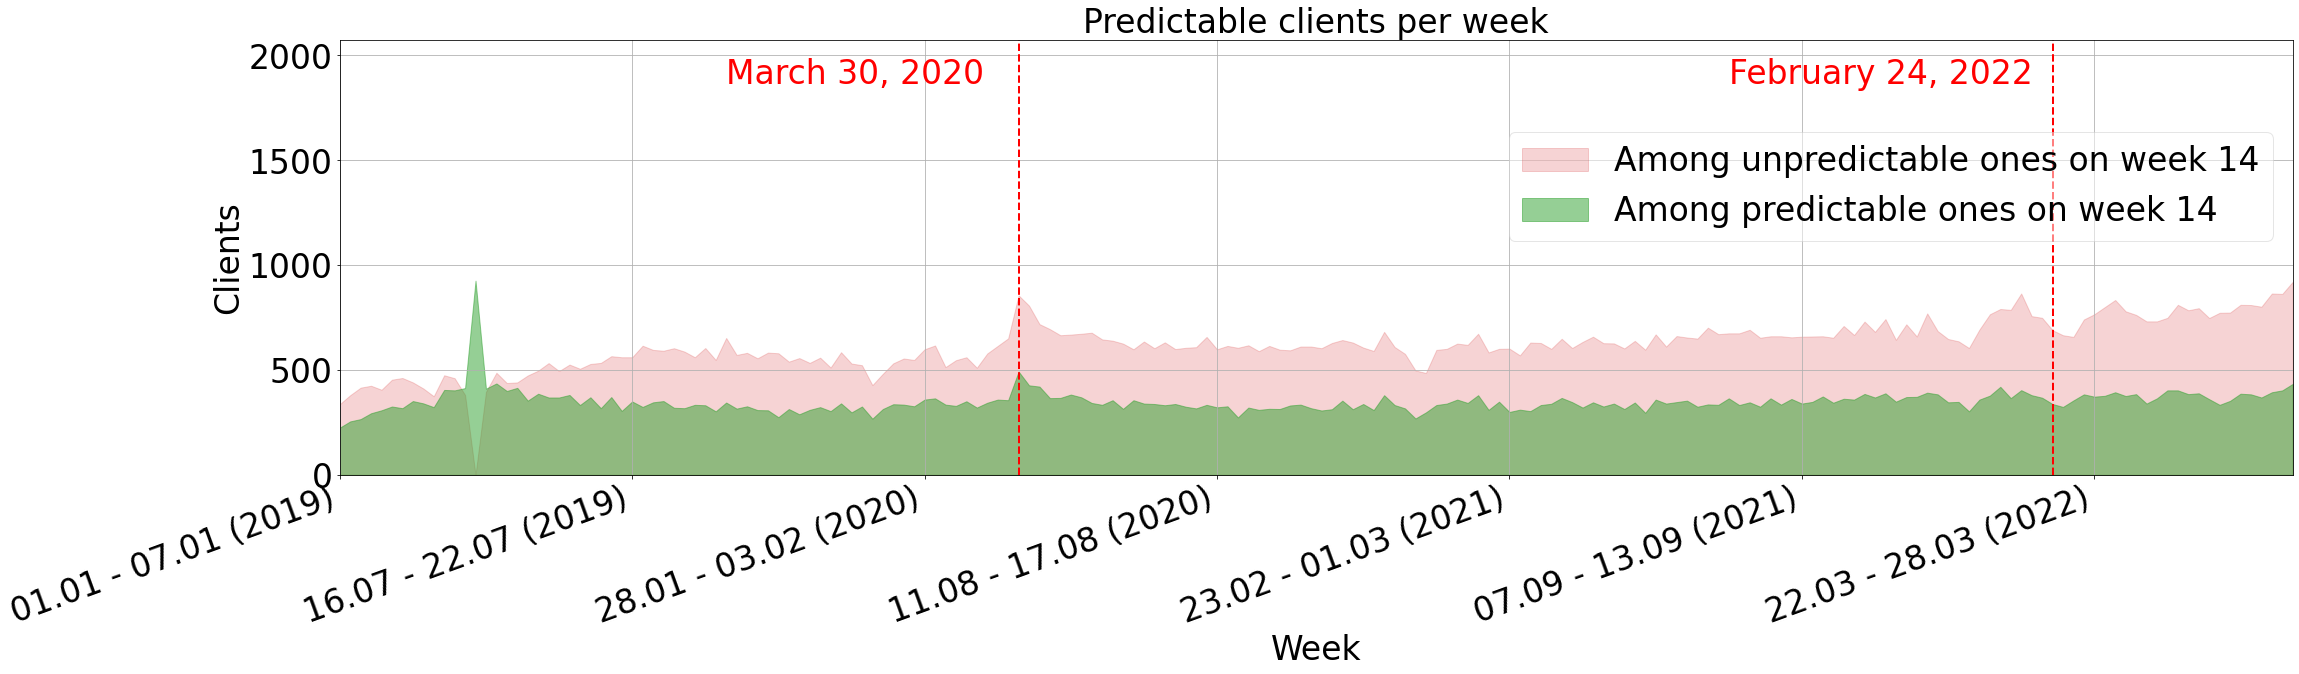

In [ ]:
plt.rcParams['figure.figsize'] = 35, 8

bad_clients_on_14 = np.where(bool_clients[:,13]==0)[0]
good_clients_on_14 = np.where(bool_clients[:,13]==1)[0]
good_clients_num = good_clients_on_14.shape[0]
bad_clients_num = bad_clients_on_14.shape[0]

#plt.fill_between((a0+' - '+a1), 0, bad_clients_num, color='gray', alpha=0.04)
plt.fill_between((a0+' - '+a1), bool_clients[bad_clients_on_14,:].sum(0), 0, 
                 color=cmap.colors[3], alpha=0.2, label='Among unpredictable ones on week 14')
plt.fill_between((a0+' - '+a1), bool_clients[good_clients_on_14,:].sum(0), 0, 
                 color=cmap.colors[2], alpha=0.5, label='Among predictable ones on week 14')

plt.axvline(65, ls='--', lw=2, color='red')
plt.text(67-30,bad_clients_num*0.9,'March 30, 2020',c='red')
plt.axvline(164, ls='--', lw=2, color='red')
plt.text(166-33,bad_clients_num*0.9,'February 24, 2022',c='red')

plt.xticks((a0+' - '+a1)[::28], rotation=20, ha='right')
plt.ylim(0,bad_clients_num)
plt.margins(x=0)
plt.grid()

# в каком углу легенды находится точка, указанная в bbox_to_anchor
plt.legend(loc='lower left', bbox_to_anchor=(0.59,0.5), framealpha=0.5)
plt.title('Predictable clients per week')
plt.ylabel('Clients')
plt.xlabel('Week');

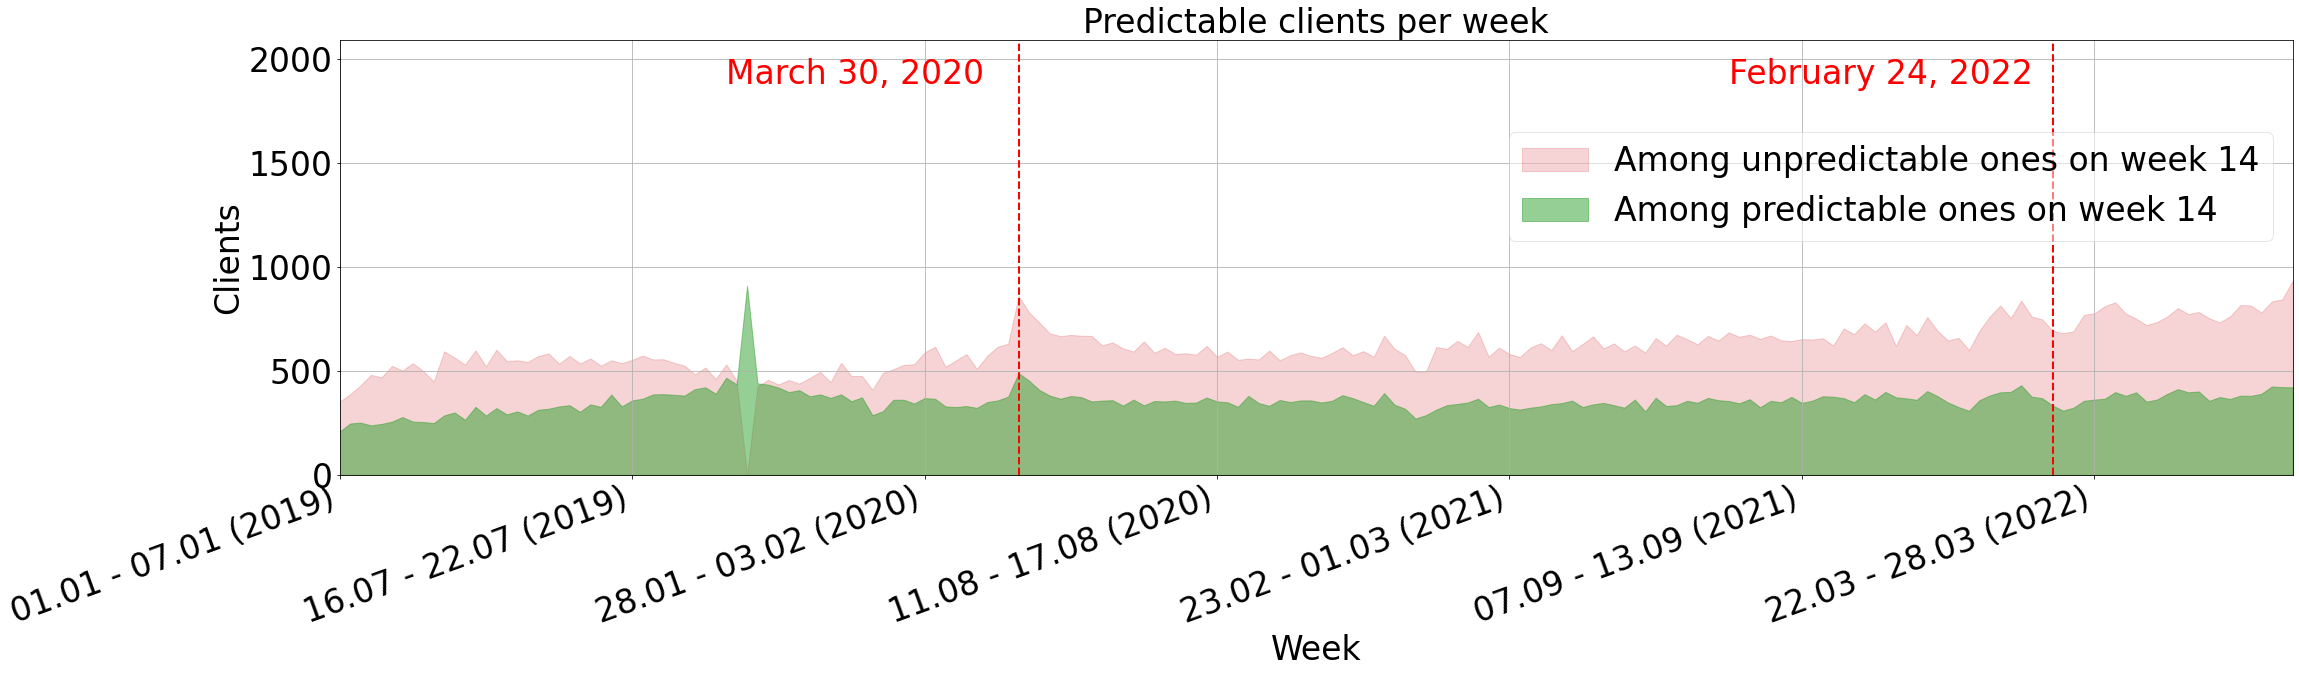

In [ ]:
plt.rcParams['figure.figsize'] = 35, 8

bad_clients_on_14 = np.where(bool_clients[:,39]==0)[0]
good_clients_on_14 = np.where(bool_clients[:,39]==1)[0]
good_clients_num = good_clients_on_14.shape[0]
bad_clients_num = bad_clients_on_14.shape[0]

#plt.fill_between((a0+' - '+a1), 0, bad_clients_num, color='gray', alpha=0.04)
plt.fill_between((a0+' - '+a1), bool_clients[bad_clients_on_14,:].sum(0), 0, 
                 color=cmap.colors[3], alpha=0.2, label='Among unpredictable ones on week 14')
plt.fill_between((a0+' - '+a1), bool_clients[good_clients_on_14,:].sum(0), 0, 
                 color=cmap.colors[2], alpha=0.5, label='Among predictable ones on week 14')

plt.axvline(65, ls='--', lw=2, color='red')
plt.text(67-30,bad_clients_num*0.9,'March 30, 2020',c='red')
plt.axvline(164, ls='--', lw=2, color='red')
plt.text(166-33,bad_clients_num*0.9,'February 24, 2022',c='red')

plt.xticks((a0+' - '+a1)[::28], rotation=20, ha='right')
plt.ylim(0,bad_clients_num)
plt.margins(x=0)
plt.grid()

# в каком углу легенды находится точка, указанная в bbox_to_anchor
plt.legend(loc='lower left', bbox_to_anchor=(0.59,0.5), framealpha=0.5)
plt.title('Predictable clients per week')
plt.ylabel('Clients')
plt.xlabel('Week');

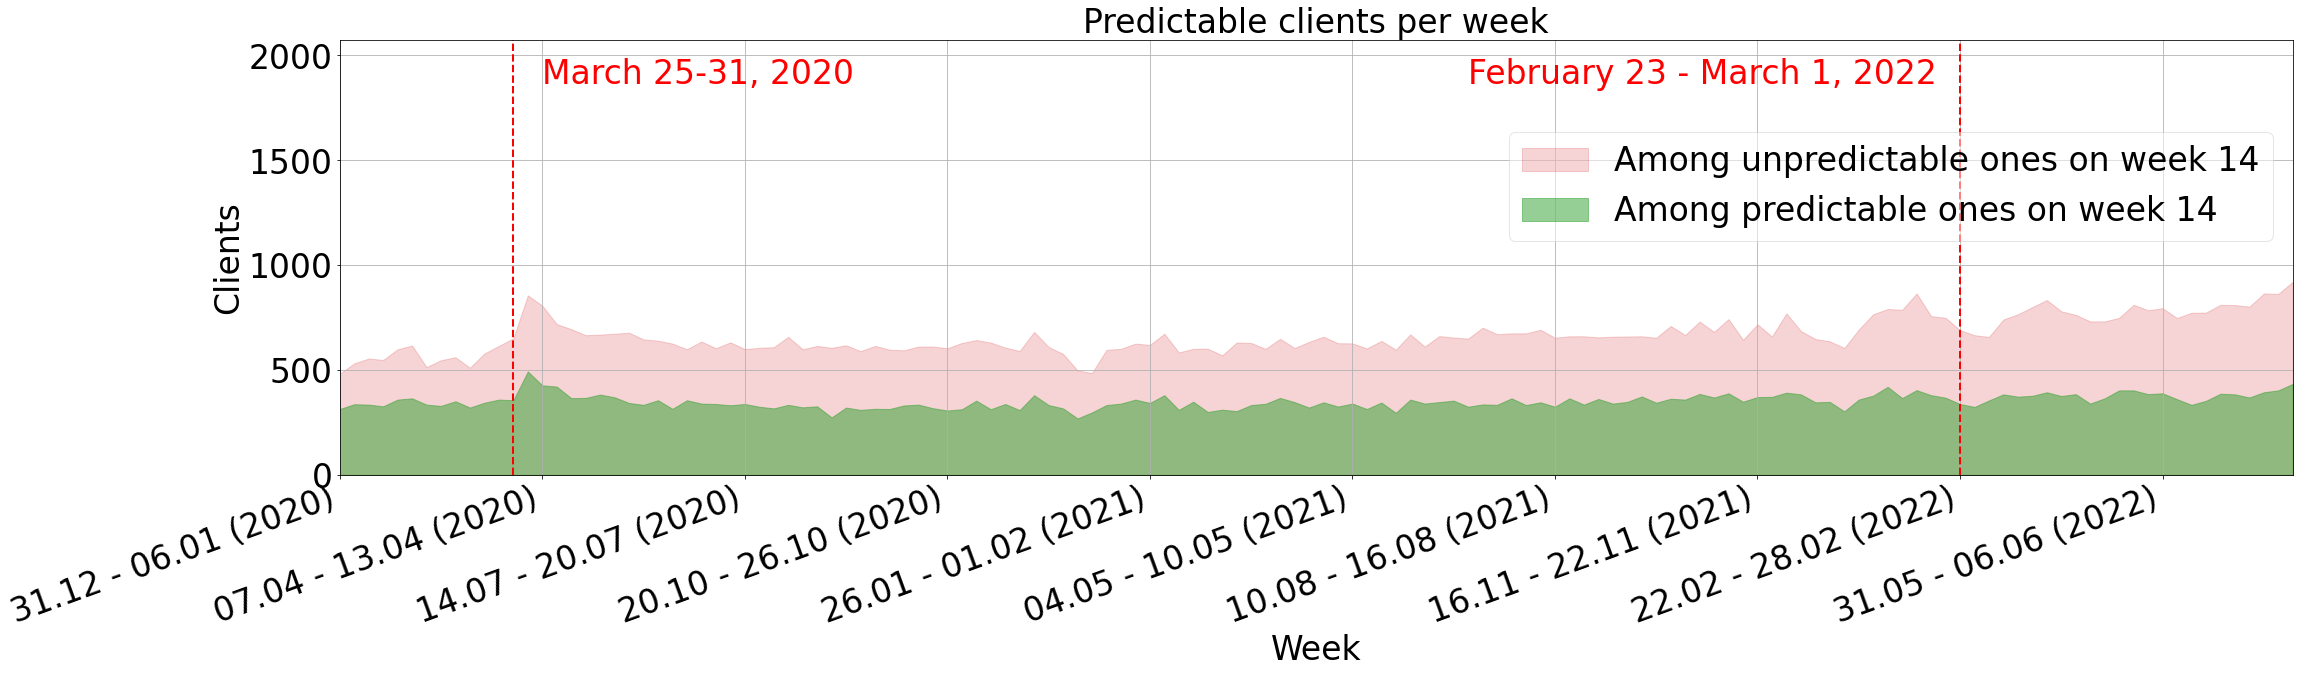

In [ ]:
plt.rcParams['figure.figsize'] = 35, 8

bad_clients_on_14 = np.where(bool_clients[:,13]==0)[0]
good_clients_on_14 = np.where(bool_clients[:,13]==1)[0]
good_clients_num = good_clients_on_14.shape[0]
bad_clients_num = bad_clients_on_14.shape[0]

#plt.fill_between((a0[-136:]+' - '+a1[-136:]), 0, bad_clients_num, color='gray', alpha=0.04)
plt.fill_between((a0[-136:]+' - '+a1[-136:]), bool_clients[bad_clients_on_14,-136:].sum(0), 0, 
                 color=cmap.colors[3], alpha=0.2, label='Among unpredictable ones on week 14')

#plt.fill_between((a0[-136:]+' - '+a1[-136:]), 0, good_clients_num, color='gray', alpha=0.2)
plt.fill_between((a0[-136:]+' - '+a1[-136:]), bool_clients[good_clients_on_14,-136:].sum(0), 0, 
                 color=cmap.colors[2], alpha=0.5, label='Among predictable ones on week 14')

critical_week_1_pos = np.where(days_test2[:,0]==pd.to_datetime('2020-03-25'))[0]
plt.axvline(critical_week_1_pos, ls='--', lw=2, color='red')
plt.text(critical_week_1_pos+2, bad_clients_num*0.9,'March 25-31, 2020',c='red')

critical_week_2_pos = np.where(days_test2[:,0]==pd.to_datetime('2022-02-23'))[0]
plt.axvline(critical_week_2_pos, ls='--', lw=2, color='red')
plt.text(critical_week_2_pos-34, bad_clients_num*0.9,'February 23 - March 1, 2022',c='red')

plt.xticks((a0[-136:]+' - '+a1[-136:])[::14], rotation=20, ha='right')
plt.ylim(0,bad_clients_num)
plt.margins(x=0)
plt.grid()

# в каком углу легенды находится точка, указанная в bbox_to_anchor
plt.legend(loc='lower left', bbox_to_anchor=(0.59,0.5), framealpha=0.5)
plt.title('Predictable clients per week')
plt.ylabel('Clients')
plt.xlabel('Week');

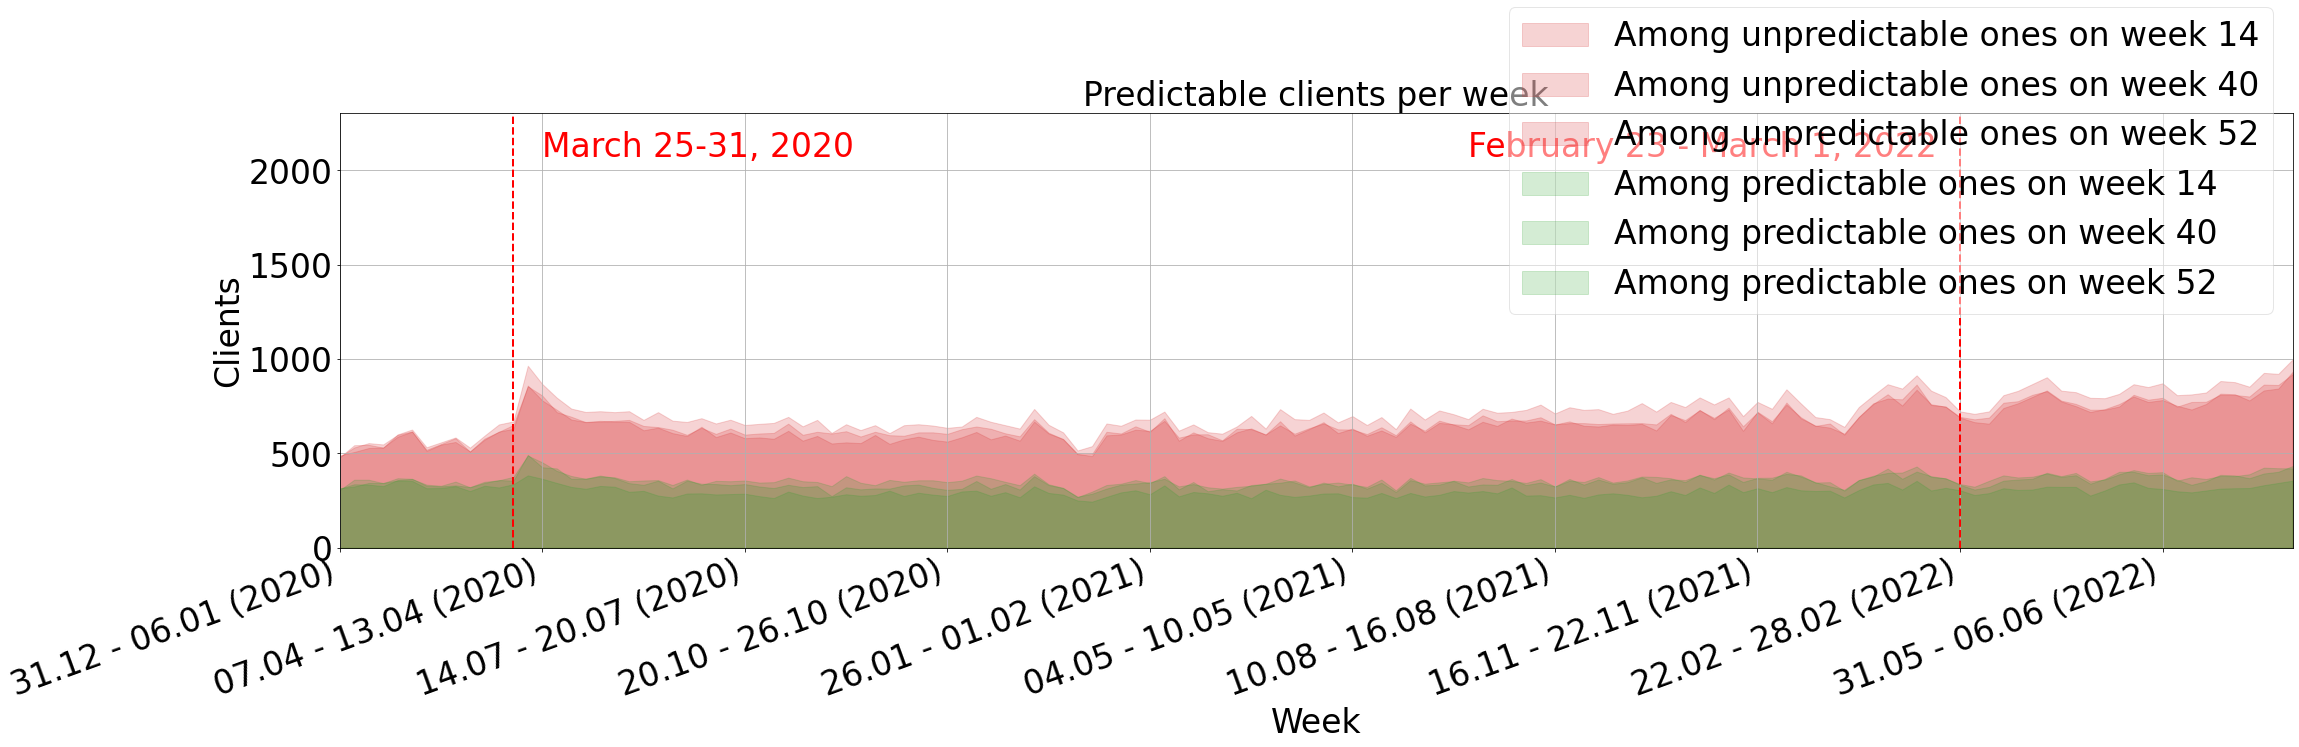

In [ ]:
plt.rcParams['figure.figsize'] = 35, 8
hatches = ['o', '++', 'x']

for i,the_week in enumerate([13,39,51]):
    bad_clients_on_week_n = np.where(bool_clients[:,the_week]==0)[0]
    bad_clients_num = bad_clients_on_week_n.shape[0]

    #plt.fill_between((a0[-136:]+' - '+a1[-136:]), 0, bad_clients_num, color='gray', alpha=0.04)
    plt.fill_between((a0[-136:]+' - '+a1[-136:]), bool_clients[bad_clients_on_week_n,-136:].sum(0), 0, 
                     color=cmap.colors[3],alpha=0.2,
                     #color='none', edgecolor=cmap.colors[3], hatch=hatches[i],
                     label=f'Among unpredictable ones on week {the_week+1}')

for i,the_week in enumerate([13,39,51]):
    good_clients_on_week_n = np.where(bool_clients[:,the_week]==1)[0]
    good_clients_num = good_clients_on_week_n.shape[0]

    #plt.fill_between((a0[-136:]+' - '+a1[-136:]), 0, good_clients_num, color='gray', alpha=0.2)
    plt.fill_between((a0[-136:]+' - '+a1[-136:]), bool_clients[good_clients_on_week_n,-136:].sum(0), 0, 
                     color=cmap.colors[2], alpha=0.2,
                     #color='white', edgecolor=cmap.colors[2], hatch=hatches[i],
                     label=f'Among predictable ones on week {the_week+1}')

    
critical_week_1_pos = np.where(days_test2[:,0]==pd.to_datetime('2020-03-25'))[0]
plt.axvline(critical_week_1_pos, ls='--', lw=2, color='red')
plt.text(critical_week_1_pos+2, bad_clients_num*0.9,'March 25-31, 2020',c='red')

critical_week_2_pos = np.where(days_test2[:,0]==pd.to_datetime('2022-02-23'))[0]
plt.axvline(critical_week_2_pos, ls='--', lw=2, color='red')
plt.text(critical_week_2_pos-34, bad_clients_num*0.9,'February 23 - March 1, 2022',c='red')

plt.xticks((a0[-136:]+' - '+a1[-136:])[::14], rotation=20, ha='right')
plt.ylim(0,bad_clients_num)
plt.margins(x=0)
plt.grid()

# в каком углу легенды находится точка, указанная в bbox_to_anchor
plt.legend(loc='lower left', bbox_to_anchor=(0.59,0.5), framealpha=0.5)
plt.title('Predictable clients per week')
plt.ylabel('Clients')
plt.xlabel('Week');

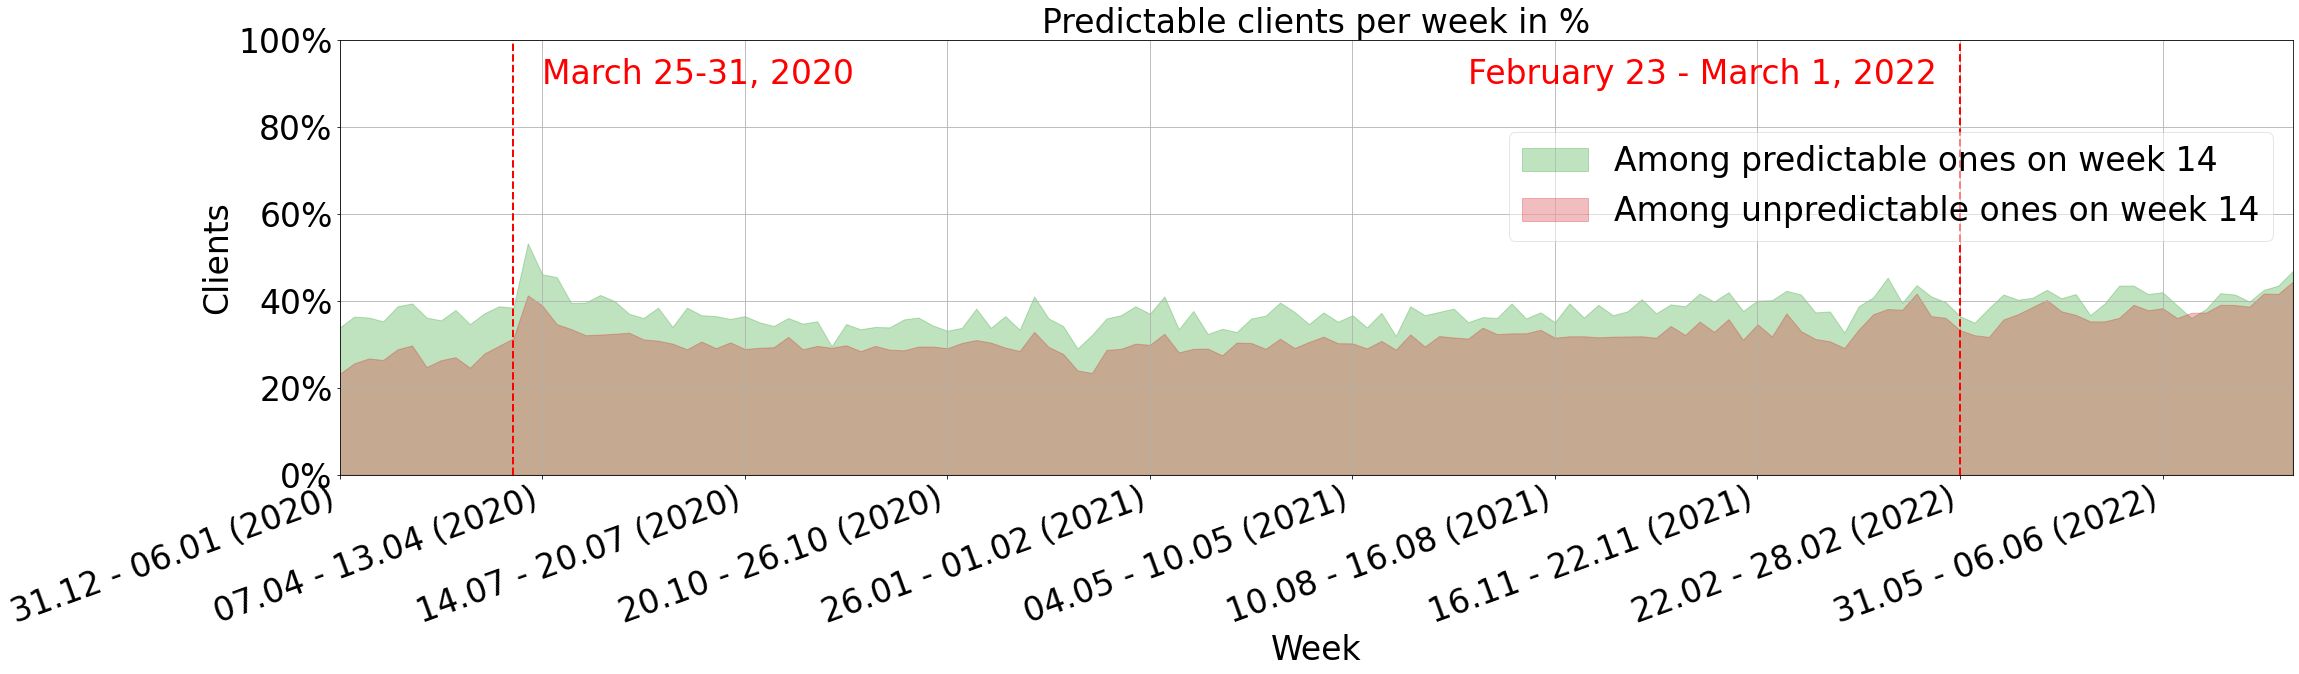

In [ ]:
plt.rcParams['figure.figsize'] = 35, 8
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

bad_clients_on_14 = np.where(bool_clients[:,13]==0)[0]
good_clients_on_14 = np.where(bool_clients[:,13]==1)[0]
good_clients_num = good_clients_on_14.shape[0]
bad_clients_num = bad_clients_on_14.shape[0]


#plt.fill_between((a0[-136:]+' - '+a1[-136:]), 0, 1, color='gray', alpha=0.04)


plt.fill_between((a0[-136:]+' - '+a1[-136:]), bool_clients[good_clients_on_14,-136:].sum(0)/good_clients_num, 0, 
                 color=cmap.colors[2], alpha=0.3, label='Among predictable ones on week 14')
plt.fill_between((a0[-136:]+' - '+a1[-136:]), bool_clients[bad_clients_on_14,-136:].sum(0)/bad_clients_num, 0, 
                 color=cmap.colors[3], alpha=0.3, label='Among unpredictable ones on week 14')

critical_week_1_pos = np.where(days_test2[:,0]==pd.to_datetime('2020-03-25'))[0]
plt.axvline(critical_week_1_pos, ls='--', lw=2, color='red')
plt.text(critical_week_1_pos+2, 0.9,'March 25-31, 2020',c='red')

critical_week_2_pos = np.where(days_test2[:,0]==pd.to_datetime('2022-02-23'))[0]
plt.axvline(critical_week_2_pos, ls='--', lw=2, color='red')
plt.text(critical_week_2_pos-34, 0.9,'February 23 - March 1, 2022',c='red')

plt.xticks((a0[-136:]+' - '+a1[-136:])[::14], rotation=20, ha='right')
plt.ylim(0,1)
plt.margins(x=0)
plt.grid()

# в каком углу легенды находится точка, указанная в bbox_to_anchor
plt.legend(loc='lower left', bbox_to_anchor=(0.59,0.5), framealpha=0.5)
plt.title('Predictable clients per week in %')
plt.ylabel('Clients')
plt.xlabel('Week');

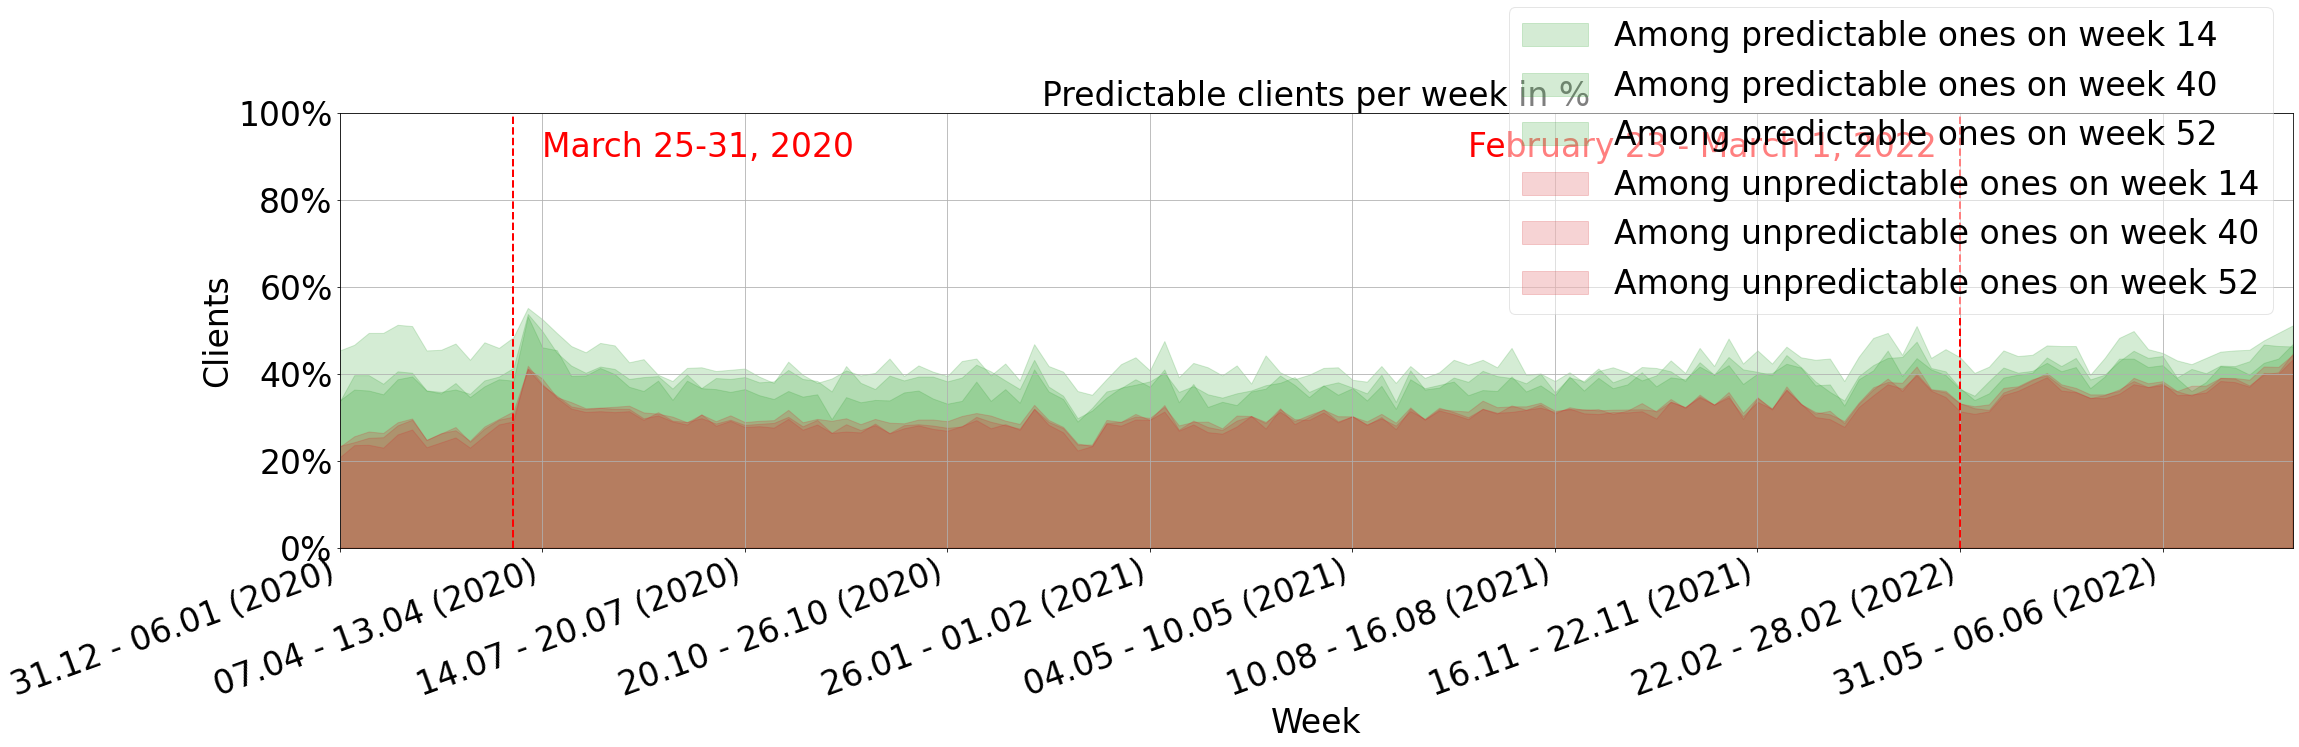

In [ ]:
plt.rcParams['figure.figsize'] = 35, 8
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

for i,the_week in enumerate([13,39,51]):
    good_clients_on_week_n = np.where(bool_clients[:,the_week]==1)[0]
    good_clients_num = good_clients_on_week_n.shape[0]

    #plt.fill_between((a0[-136:]+' - '+a1[-136:]), 0, good_clients_num, color='gray', alpha=0.2)
    plt.fill_between((a0[-136:]+' - '+a1[-136:]), bool_clients[good_clients_on_week_n,-136:].sum(0)/good_clients_num, 
                     0, color=cmap.colors[2], alpha=0.2,
                     #color='white', edgecolor=cmap.colors[2], hatch=hatches[i],
                     label=f'Among predictable ones on week {the_week+1}')

for i,the_week in enumerate([13,39,51]):
    bad_clients_on_week_n = np.where(bool_clients[:,the_week]==0)[0]
    bad_clients_num = bad_clients_on_week_n.shape[0]

    #plt.fill_between((a0[-136:]+' - '+a1[-136:]), 0, bad_clients_num, color='gray', alpha=0.04)
    plt.fill_between((a0[-136:]+' - '+a1[-136:]), bool_clients[bad_clients_on_week_n,-136:].sum(0)/bad_clients_num, 
                     0, color=cmap.colors[3],alpha=0.2,
                     #color='none', edgecolor=cmap.colors[3], hatch=hatches[i],
                     label=f'Among unpredictable ones on week {the_week+1}')
    
    
critical_week_1_pos = np.where(days_test2[:,0]==pd.to_datetime('2020-03-25'))[0]
plt.axvline(critical_week_1_pos, ls='--', lw=2, color='red')
plt.text(critical_week_1_pos+2, 0.9,'March 25-31, 2020',c='red')

critical_week_2_pos = np.where(days_test2[:,0]==pd.to_datetime('2022-02-23'))[0]
plt.axvline(critical_week_2_pos, ls='--', lw=2, color='red')
plt.text(critical_week_2_pos-34, 0.9,'February 23 - March 1, 2022',c='red')

plt.xticks((a0[-136:]+' - '+a1[-136:])[::14], rotation=20, ha='right')
plt.ylim(0,1)
plt.margins(x=0)
plt.grid()

# в каком углу легенды находится точка, указанная в bbox_to_anchor
plt.legend(loc='lower left', bbox_to_anchor=(0.59,0.5), framealpha=0.5)
plt.title('Predictable clients per week in %')
plt.ylabel('Clients')
plt.xlabel('Week');

### То же, но для инкрементальной

#### Хорошие

In [ ]:
reset_seeds(seed_value = the_chosen_seed)

lr_inc = 0.00005
n_ep_inc = 10

in1 = Input(batch_shape = (1, mem, dim))
out = LSTM(n_neurons_each_model, batch_input_shape=(1, mem, dim), 
                    stateful=True, return_sequences=False, activation='relu')(in1)
out = Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)
out = Dropout(0.1)(out)
x = Dense(1, activation='linear')(out)

model_inc = Model(inputs=[in1], outputs=x)
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_inc)
model_inc.compile(loss='mean_squared_error',metrics=['mape'], optimizer=optimizer,  run_eagerly=True)
model_inc.set_weights(model.get_weights())

In [ ]:
fwd_mapes,full_fwd_pred_tr,full_fwd_true = [next_fwd_mapes[0]],\
                                            [next_full_fwd_pred_tr[0]],\
                                            [next_full_fwd_true[0]]

  0%|          | 0/134 [00:00<?, ?it/s]

test MAPE median: 5.279%
test MAPE HP: 48.148%


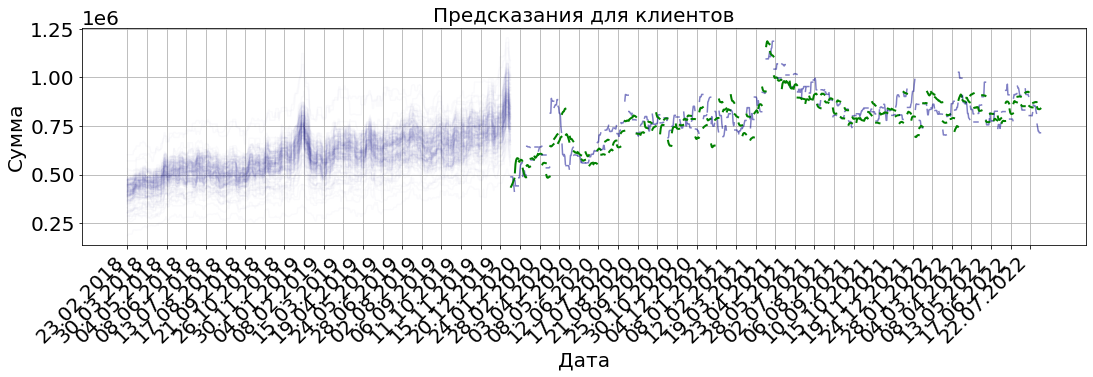

In [ ]:
inext_fwd_mapes = fwd_mapes.copy()
inext_full_fwd_pred_tr = full_fwd_pred_tr.copy()
inext_full_fwd_true = full_fwd_true.copy()

for nth_week in trange(1,n_weeks-1):
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)

    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(next_good_rw.iloc[shift_days:], next_split, dim, mem, 0)
    inext_fwd_mapes, inext_full_fwd_pred_tr, inext_full_fwd_true = macro_model_functions.use_inc_model(model_inc, next_scaler, next_dat, next_good_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            inext_fwd_mapes, inext_full_fwd_pred_tr, inext_full_fwd_true,n_ep_inc)
    
plt.rcParams['figure.figsize'] = 18, 4

print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes).shape[0]) * 100 :.3f}%')
r = macro_help_functions.plot_clients_pred_base('good',a1_dm,df_2models,df_real_id,bool_clients,
                                                inext_full_fwd_pred_tr, inext_full_fwd_true,split,
                                                dim, mem, fwd, days, 35, n_weeks,shift_days)

In [ ]:

model.save("exp_data/good/model_inc.h5")

np.save('exp_data/good/inext_fwd_mapes', np.array(inext_fwd_mapes))
np.save('exp_data/good/inext_full_fwd_pred_tr', np.array(inext_full_fwd_pred_tr))
np.save('exp_data/good/inext_full_fwd_true', np.array(inext_full_fwd_true))


In [ ]:
model_inc = load_model('exp_data/good/model_inc.h5')
inext_fwd_mapes = np.load('exp_data/good/inext_fwd_mapes.npy')
inext_full_fwd_pred_tr = np.load('exp_data/good/inext_full_fwd_pred_tr.npy')
inext_full_fwd_true = np.load('exp_data/good/inext_full_fwd_true.npy')

print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes).shape[0]) * 100 :.3f}%') 

test MAPE median: 5.279%
test MAPE HP: 48.148%


##### выделяя 1 раз

In [ ]:
plt.rcParams['figure.figsize'] = 22, 4
for_weeks_inext_fwd_mapes_1t = []
for_weeks_inext_full_fwd_pred_tr_1t = []
for_weeks_inext_full_fwd_true_1t = []
imodels_14_52_40 = []

# для каждой заданной недели
for week_to_test in [13,51,39]:
    reset_seeds(seed_value = the_chosen_seed)
    
    in1 = Input(batch_shape = (1, mem, dim))
    out = LSTM(n_neurons_each_model, batch_input_shape=(1, mem, dim), 
                        stateful=True, return_sequences=False, activation='relu')(in1)
    out = Dropout(0.1)(out)
    out = Dense(32, activation='relu')(out)
    out = Dropout(0.1)(out)
    x = Dense(1, activation='linear')(out)

    model_inc_temp = Model(inputs=[in1], outputs=x)
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_inc)
    model_inc_temp.compile(loss='mean_squared_error',metrics=['mape'], optimizer=optimizer,  run_eagerly=True)
    model_inc_temp.set_weights(model.get_weights())
    
    good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,week_to_test,window_size=21)
    
    inext_fwd_mapes_1t = fwd_mapes.copy()
    inext_full_fwd_pred_tr_1t = full_fwd_pred_tr.copy()
    inext_full_fwd_true_1t = full_fwd_true.copy()

    # Для каждой тестовой недели
    for nth_week in trange(1,n_weeks-1):
        # считаем день, с которого начинаем предсказывать
        last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
        next_split= days.shape[0]-last_day-1

        # Предсказываем (без обучения)
        next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(good_rw.iloc[shift_days:], next_split, dim, mem, 0)
        inext_fwd_mapes_1t, inext_full_fwd_pred_tr_1t, inext_full_fwd_true_1t = macro_model_functions.use_inc_model(model_inc_temp, next_scaler, next_dat, good_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            inext_fwd_mapes_1t, inext_full_fwd_pred_tr_1t, inext_full_fwd_true_1t,n_ep_inc)
    # запомним рез-ты
    for_weeks_inext_fwd_mapes_1t.append(inext_fwd_mapes_1t)
    for_weeks_inext_full_fwd_pred_tr_1t.append(inext_full_fwd_pred_tr_1t)
    for_weeks_inext_full_fwd_true_1t.append(inext_full_fwd_true_1t)
    imodels_14_52_40.append(model_inc_temp)
    
    print(f'week №{week_to_test}')
    print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_1t)) *100 :.3f}%')
    print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_1t)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_1t).shape[0]) * 100 :.3f}%')
    
# запишем рез-ты в переменные для отд.недель
inext_fwd_mapes_1t14, inext_fwd_mapes_1t52, inext_fwd_mapes_1t = for_weeks_inext_fwd_mapes_1t
inext_full_fwd_pred_tr_1t14, inext_full_fwd_pred_tr_1t52, inext_full_fwd_pred_tr_1t = for_weeks_inext_full_fwd_pred_tr_1t
inext_full_fwd_true_1t14, inext_full_fwd_true_1t52, inext_full_fwd_true_1t = for_weeks_inext_full_fwd_true_1t
imodel_14, imodel_52, imodel_40 = imodels_14_52_40

  0%|          | 0/134 [00:00<?, ?it/s]

week №13
test MAPE median: 5.357%
test MAPE HP: 45.185%


  0%|          | 0/134 [00:00<?, ?it/s]

week №51
test MAPE median: 5.827%
test MAPE HP: 40.741%


  0%|          | 0/134 [00:00<?, ?it/s]

week №39
test MAPE median: 5.147%
test MAPE HP: 47.407%


In [ ]:
# SAVING

imodel_14.save("exp_data/good/imodel_14.h5")
imodel_52.save("exp_data/good/imodel_52.h5")
imodel_40.save("exp_data/good/imodel_40.h5")

np.save('exp_data/good/inext_fwd_mapes_1t14', np.array(inext_fwd_mapes_1t14))
np.save('exp_data/good/inext_fwd_mapes_1t52', np.array(inext_fwd_mapes_1t52))
np.save('exp_data/good/inext_fwd_mapes_1t', np.array(inext_fwd_mapes_1t))

np.save('exp_data/good/inext_full_fwd_pred_tr_1t14', np.array(inext_full_fwd_pred_tr_1t14))
np.save('exp_data/good/inext_full_fwd_pred_tr_1t52', np.array(inext_full_fwd_pred_tr_1t52))
np.save('exp_data/good/inext_full_fwd_pred_tr_1t', np.array(inext_full_fwd_pred_tr_1t))

np.save('exp_data/good/inext_full_fwd_true_1t14', np.array(inext_full_fwd_true_1t14))
np.save('exp_data/good/inext_full_fwd_true_1t52', np.array(inext_full_fwd_true_1t52))
np.save('exp_data/good/inext_full_fwd_true_1t', np.array(inext_full_fwd_true_1t))


In [ ]:
# LOADING
imodel_14 = load_model('exp_data/good/imodel_14.h5')
imodel_52 = load_model('exp_data/good/imodel_52.h5')
imodel_40 = load_model('exp_data/good/imodel_40.h5')

inext_fwd_mapes_1t14 = np.load('exp_data/good/inext_fwd_mapes_1t14.npy')
inext_fwd_mapes_1t52 = np.load('exp_data/good/inext_fwd_mapes_1t52.npy')
inext_fwd_mapes_1t = np.load('exp_data/good/inext_fwd_mapes_1t.npy')

inext_full_fwd_pred_tr_1t14 = np.load('exp_data/good/inext_full_fwd_pred_tr_1t14.npy')
inext_full_fwd_pred_tr_1t52 = np.load('exp_data/good/inext_full_fwd_pred_tr_1t52.npy')
inext_full_fwd_pred_tr_1t = np.load('exp_data/good/inext_full_fwd_pred_tr_1t.npy')

inext_full_fwd_true_1t14 = np.load('exp_data/good/inext_full_fwd_true_1t14.npy')
inext_full_fwd_true_1t52 = np.load('exp_data/good/inext_full_fwd_true_1t52.npy')
inext_full_fwd_true_1t = np.load('exp_data/good/inext_full_fwd_true_1t.npy')

print(f'week №14')
print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_1t14)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_1t14)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_1t14).shape[0]) * 100 :.3f}%')
print(f'week №52')    
print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_1t52)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_1t52)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_1t52).shape[0]) * 100 :.3f}%')
print(f'week №40')
print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_1t)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_1t)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_1t).shape[0]) * 100 :.3f}%')

week №14
test MAPE median: 5.357%
test MAPE HP: 45.185%
week №52
test MAPE median: 5.827%
test MAPE HP: 40.741%
week №40
test MAPE median: 5.147%
test MAPE HP: 47.407%


#### Все

In [ ]:
in1 = Input(batch_shape = (1, mem, dim))
out = LSTM(n_neurons_each_model, batch_input_shape=(1, mem, dim), 
                    stateful=True, return_sequences=False, activation='relu')(in1)
out = Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)
out = Dropout(0.1)(out)
x = Dense(1, activation='linear')(out)

model_all_inc = Model(inputs=[in1], outputs=x)
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_inc)
model_all_inc.compile(loss='mean_squared_error',metrics=['mape'], optimizer=optimizer,  run_eagerly=True)
model_all_inc.set_weights(model_all.get_weights())

In [ ]:
fwd_mapes_all,full_fwd_pred_tr_all,full_fwd_true_all = [next_fwd_mapes_all[0]],\
                                                        [next_full_fwd_pred_tr_all[0]],\
                                                        [next_full_fwd_true_all[0]]

  0%|          | 0/134 [00:00<?, ?it/s]

test MAPE median: 4.995%
test MAPE HP: 50.370%


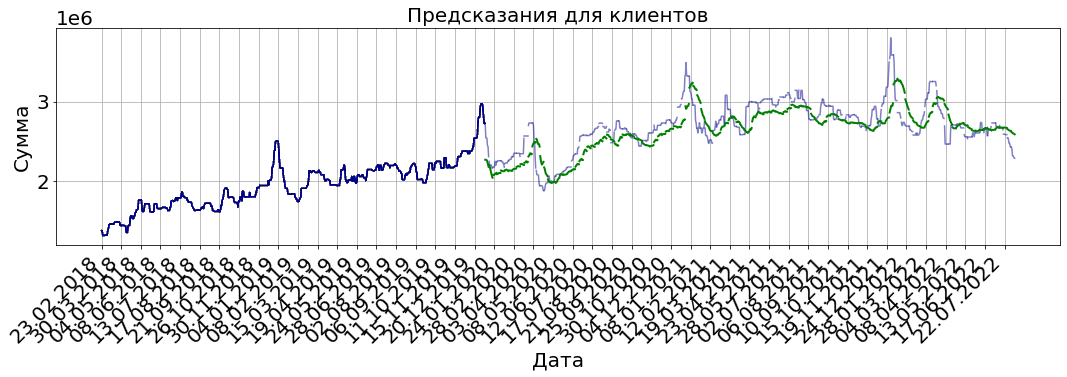

In [ ]:
inext_fwd_mapes_all = fwd_mapes_all.copy()
inext_full_fwd_pred_tr_all = full_fwd_pred_tr_all.copy()
inext_full_fwd_true_all = full_fwd_true_all.copy()

for nth_week in trange(1,n_weeks-1):
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)

    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(next_all_rw.iloc[shift_days:], next_split, dim, mem, 0)
    
    inext_fwd_mapes_all, inext_full_fwd_pred_tr_all, inext_full_fwd_true_all = macro_model_functions.use_inc_model(model_all_inc, next_scaler, next_dat, next_all_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            inext_fwd_mapes_all, inext_full_fwd_pred_tr_all, inext_full_fwd_true_all,
                            n_ep_inc)

plt.rcParams['figure.figsize'] = 18, 4
print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_all)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_all)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_all).shape[0]) * 100 :.3f}%')
r = macro_help_functions.plot_clients_pred_base('all',a1_dm,df_2models,df_real_id,bool_clients,
                                                inext_full_fwd_pred_tr_all, inext_full_fwd_true_all,split,
                                                dim, mem, fwd, days, 35, n_weeks,shift_days)

In [ ]:

model_all_inc.save("exp_data/all/model_all_inc.h5")

np.save('exp_data/all/inext_fwd_mapes_all', np.array(inext_fwd_mapes_all))
np.save('exp_data/all/inext_full_fwd_pred_tr_all', np.array(inext_full_fwd_pred_tr_all))
np.save('exp_data/all/inext_full_fwd_true_all', np.array(inext_full_fwd_true_all))

In [ ]:
model_all_inc = load_model('exp_data/all/model_all_inc.h5')
inext_fwd_mapes_all = np.load('exp_data/all/inext_fwd_mapes_all.npy')
inext_full_fwd_pred_tr_all = np.load('exp_data/all/inext_full_fwd_pred_tr_all.npy')
inext_full_fwd_true_all = np.load('exp_data/all/inext_full_fwd_true_all.npy')

print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_all)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_all)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_all).shape[0]) * 100 :.3f}%') 

test MAPE median: 4.995%
test MAPE HP: 50.370%


#### Плохие

In [ ]:
in1 = Input(batch_shape = (1, mem, dim))
out = LSTM(n_neurons_each_model, batch_input_shape=(1, mem, dim), 
                    stateful=True, return_sequences=False, activation='relu')(in1)
out = Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)
out = Dropout(0.1)(out)
x = Dense(1, activation='linear')(out)

model_bad_inc = Model(inputs=[in1], outputs=x)
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_inc)
model_bad_inc.compile(loss='mean_squared_error',metrics=['mape'], optimizer=optimizer,  run_eagerly=True)
model_bad_inc.set_weights(model_bad.get_weights())

In [ ]:
fwd_mapes_bad,full_fwd_pred_tr_bad,full_fwd_true_bad = [next_fwd_mapes_bad[0]],\
                                                        [next_full_fwd_pred_tr_bad[0]],\
                                                        [next_full_fwd_true_bad[0]]

  0%|          | 0/134 [00:00<?, ?it/s]

test MAPE median: 5.403%
test MAPE HP: 46.667%


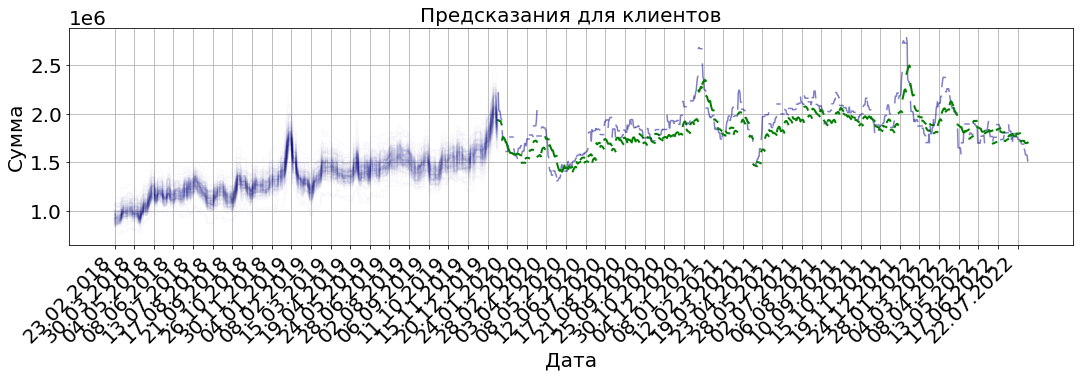

In [ ]:
inext_fwd_mapes_bad = fwd_mapes_bad.copy()
inext_full_fwd_pred_tr_bad = full_fwd_pred_tr_bad.copy()
inext_full_fwd_true_bad = full_fwd_true_bad.copy()

for nth_week in trange(1,n_weeks-1):
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)

    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(next_bad_rw.iloc[shift_days:], next_split, dim, mem, 0)
    
    inext_fwd_mapes_bad, inext_full_fwd_pred_tr_bad, inext_full_fwd_true_bad = macro_model_functions.use_inc_model(model_bad_inc, next_scaler, next_dat, next_bad_rw.iloc[shift_days:],
                            dim, mem, next_split, fwd,
                            inext_fwd_mapes_bad, inext_full_fwd_pred_tr_bad, inext_full_fwd_true_bad,n_ep_inc)
    
plt.rcParams['figure.figsize'] = 18, 4
print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_bad)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_bad)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_bad).shape[0]) * 100 :.3f}%')
r = macro_help_functions.plot_clients_pred_base('bad',a1_dm,df_2models,df_real_id,bool_clients,
                                                inext_full_fwd_pred_tr_bad, inext_full_fwd_true_bad,split,
                                                dim, mem, fwd, days, 35, n_weeks,shift_days)

In [ ]:

model_bad_inc.save("exp_data/bad/model_bad_inc.h5")

np.save('exp_data/bad/inext_fwd_mapes_bad', np.array(inext_fwd_mapes_bad))
np.save('exp_data/bad/inext_full_fwd_pred_tr_bad', np.array(inext_full_fwd_pred_tr_bad))
np.save('exp_data/bad/inext_full_fwd_true_bad', np.array(inext_full_fwd_true_bad))


In [ ]:
model_bad_inc = load_model('exp_data/bad/model_bad_inc.h5')
inext_fwd_mapes_bad = np.load('exp_data/bad/inext_fwd_mapes_bad.npy')
inext_full_fwd_pred_tr_bad = np.load('exp_data/bad/inext_full_fwd_pred_tr_bad.npy')
inext_full_fwd_true_bad = np.load('exp_data/bad/inext_full_fwd_true_bad.npy')

print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_bad)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_bad)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_bad).shape[0]) * 100 :.3f}%') 

test MAPE median: 5.403%
test MAPE HP: 46.667%


##### выделяя 1 раз

In [ ]:
plt.rcParams['figure.figsize'] = 22, 4
for_weeks_inext_fwd_mapes_bad_1t = []
for_weeks_inext_full_fwd_pred_tr_bad_1t = []
for_weeks_inext_full_fwd_true_bad_1t = []
imodels_bad_14_52_40 = []

# для каждой заданной недели
for week_to_test in [13,51,39]:
    reset_seeds(seed_value = the_chosen_seed)
    
    in1 = Input(batch_shape = (1, mem, dim))
    out = LSTM(n_neurons_each_model, batch_input_shape=(1, mem, dim), 
                        stateful=True, return_sequences=False, activation='relu')(in1)
    out = Dropout(0.1)(out)
    out = Dense(32, activation='relu')(out)
    out = Dropout(0.1)(out)
    x = Dense(1, activation='linear')(out)

    model_bad_inc_temp = Model(inputs=[in1], outputs=x)
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_inc)
    model_bad_inc_temp.compile(loss='mean_squared_error',metrics=['mape'], optimizer=optimizer,  run_eagerly=True)
    model_bad_inc_temp.set_weights(model_bad.get_weights())
    
    good_clients_id, good_rw, bad_rw, all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,week_to_test,window_size=21)
    
    inext_fwd_mapes_bad_1t = fwd_mapes_bad.copy()
    inext_full_fwd_pred_tr_bad_1t = full_fwd_pred_tr_bad.copy()
    inext_full_fwd_true_bad_1t = full_fwd_true_bad.copy()

    # Для каждой тестовой недели
    for nth_week in trange(1,n_weeks-1):
        # считаем день, с которого начинаем предсказывать
        last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
        next_split= days.shape[0]-last_day-1

        # Предсказываем (без обучения)
        next_scaler, next_x, next_y, next_dat = macro_help_functions.prepare_data(bad_rw.iloc[shift_days:], next_split, dim, mem, 0)
    
        inext_fwd_mapes_bad_1t, inext_full_fwd_pred_tr_bad_1t, \
        inext_full_fwd_true_bad_1t = macro_model_functions.use_inc_model(model_bad_inc_temp, next_scaler, next_dat, bad_rw.iloc[shift_days:],
                                dim, mem, next_split, fwd, inext_fwd_mapes_bad_1t, inext_full_fwd_pred_tr_bad_1t, inext_full_fwd_true_bad_1t,n_ep_inc)
    # запомним рез-ты
    for_weeks_inext_fwd_mapes_bad_1t.append(inext_fwd_mapes_bad_1t)
    for_weeks_inext_full_fwd_pred_tr_bad_1t.append(inext_full_fwd_pred_tr_bad_1t)
    for_weeks_inext_full_fwd_true_bad_1t.append(inext_full_fwd_true_bad_1t)
    imodels_bad_14_52_40.append(model_bad_inc_temp)
    
    print(f'week №{week_to_test}')
    print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_bad_1t)) *100 :.3f}%')
    print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_bad_1t)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_bad_1t).shape[0]) * 100 :.3f}%')
    
# запишем рез-ты в переменные для отд.недель
inext_fwd_mapes_bad_1t14, inext_fwd_mapes_bad_1t52, inext_fwd_mapes_bad_1t = for_weeks_inext_fwd_mapes_bad_1t
inext_full_fwd_pred_tr_bad_1t14, inext_full_fwd_pred_tr_bad_1t52, inext_full_fwd_pred_tr_bad_1t = for_weeks_inext_full_fwd_pred_tr_bad_1t
inext_full_fwd_true_bad_1t14, inext_full_fwd_true_bad_1t52, inext_full_fwd_true_bad_1t = for_weeks_inext_full_fwd_true_bad_1t
imodel_bad_14, imodel_bad_52, imodel_bad_40 = imodels_bad_14_52_40

  0%|          | 0/134 [00:00<?, ?it/s]

week №13
test MAPE median: 4.834%
test MAPE HP: 51.852%


  0%|          | 0/134 [00:00<?, ?it/s]

week №51
test MAPE median: 5.698%
test MAPE HP: 41.481%


  0%|          | 0/134 [00:00<?, ?it/s]

week №39
test MAPE median: 5.706%
test MAPE HP: 41.481%


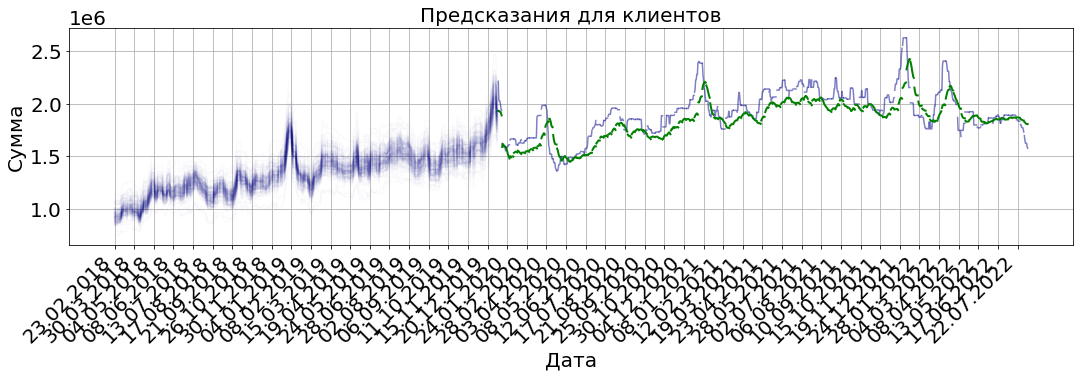

In [ ]:
# для последней рассмотренной недели
plt.rcParams['figure.figsize'] = 18, 4
r = macro_help_functions.plot_clients_pred_base('bad',a1_dm,df_2models,df_real_id,bool_clients,
                                                 inext_full_fwd_pred_tr_bad_1t, inext_full_fwd_true_bad_1t,split,
                                                dim, mem, fwd, days, 35, n_weeks,shift_days)

In [ ]:
# SAVING

imodel_bad_14.save("exp_data/bad/imodel_bad_14.h5")
imodel_bad_52.save("exp_data/bad/imodel_bad_52.h5")
imodel_bad_40.save("exp_data/bad/imodel_bad_40.h5")

np.save('exp_data/bad/inext_fwd_mapes_bad_1t14', np.array(inext_fwd_mapes_bad_1t14))
np.save('exp_data/bad/inext_fwd_mapes_bad_1t52', np.array(inext_fwd_mapes_bad_1t52))
np.save('exp_data/bad/inext_fwd_mapes_bad_1t', np.array(inext_fwd_mapes_bad_1t))

np.save('exp_data/bad/inext_full_fwd_pred_tr_bad_1t14', np.array(inext_full_fwd_pred_tr_bad_1t14))
np.save('exp_data/bad/inext_full_fwd_pred_tr_bad_1t52', np.array(inext_full_fwd_pred_tr_bad_1t52))
np.save('exp_data/bad/inext_full_fwd_pred_tr_bad_1t', np.array(inext_full_fwd_pred_tr_bad_1t))

np.save('exp_data/bad/inext_full_fwd_true_bad_1t14', np.array(inext_full_fwd_true_bad_1t14))
np.save('exp_data/bad/inext_full_fwd_true_bad_1t52', np.array(inext_full_fwd_true_bad_1t52))
np.save('exp_data/bad/inext_full_fwd_true_bad_1t', np.array(inext_full_fwd_true_bad_1t))


In [ ]:
# LOADING
imodel_bad_14 = load_model('exp_data/bad/imodel_bad_14.h5')
imodel_bad_52 = load_model('exp_data/bad/imodel_bad_52.h5')
imodel_bad_40 = load_model('exp_data/bad/imodel_bad_40.h5')

inext_fwd_mapes_bad_1t14 = np.load('exp_data/bad/inext_fwd_mapes_bad_1t14.npy')
inext_fwd_mapes_bad_1t52 = np.load('exp_data/bad/inext_fwd_mapes_bad_1t52.npy')
inext_fwd_mapes_bad_1t = np.load('exp_data/bad/inext_fwd_mapes_bad_1t.npy')

inext_full_fwd_pred_tr_bad_1t14 = np.load('exp_data/bad/inext_full_fwd_pred_tr_bad_1t14.npy')
inext_full_fwd_pred_tr_bad_1t52 = np.load('exp_data/bad/inext_full_fwd_pred_tr_bad_1t52.npy')
inext_full_fwd_pred_tr_bad_1t = np.load('exp_data/bad/inext_full_fwd_pred_tr_bad_1t.npy')

inext_full_fwd_true_bad_1t14 = np.load('exp_data/bad/inext_full_fwd_true_bad_1t14.npy')
inext_full_fwd_true_bad_1t52 = np.load('exp_data/bad/inext_full_fwd_true_bad_1t52.npy')
inext_full_fwd_true_bad_1t = np.load('exp_data/bad/inext_full_fwd_true_bad_1t.npy')

print(f'week №14')
print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_bad_1t14)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_bad_1t14)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_bad_1t14).shape[0]) * 100 :.3f}%')
print(f'week №52')    
print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_bad_1t52)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_bad_1t52)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_bad_1t52).shape[0]) * 100 :.3f}%')
print(f'week №40')
print(f'test MAPE median: {np.median(np.array(inext_fwd_mapes_bad_1t)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(inext_fwd_mapes_bad_1t)<=0.05)[0].shape[0] / np.array(inext_fwd_mapes_bad_1t).shape[0]) * 100 :.3f}%')

week №14
test MAPE median: 4.834%
test MAPE HP: 51.852%
week №52
test MAPE median: 5.698%
test MAPE HP: 41.481%
week №40
test MAPE median: 5.706%
test MAPE HP: 41.481%


####  Графики

In [ ]:
font_size = 20
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5])

plt.rc('font', size=font_size)          # controls default text sizes
plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels

plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size)    # legend fontsize
plt.rc('figure', titlesize=font_size)  # fontsize of the figure title

Text(0, 0.5, 'MAPE')

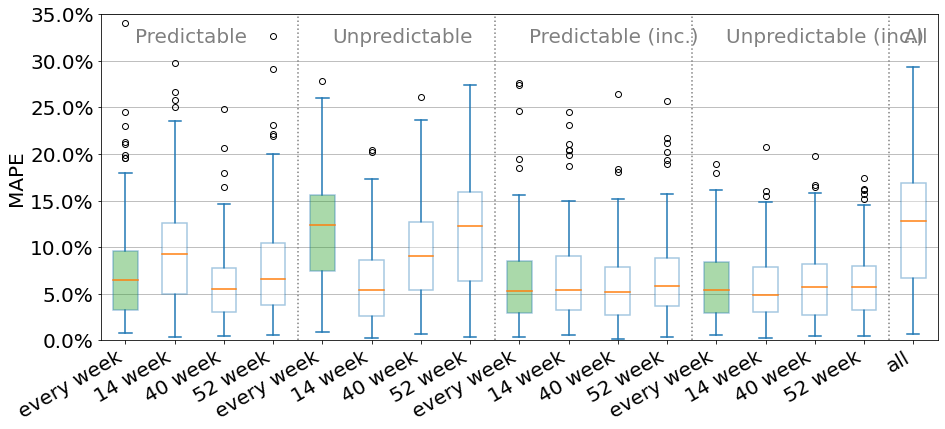

In [ ]:
# График
preds_each_week_all = pd.DataFrame({'High1':next_fwd_mapes,'High2':next_fwd_mapes_1t14,'High3':next_fwd_mapes_1t,'High4':next_fwd_mapes_1t52,
                                    'Low1':next_fwd_mapes_bad,'Low2':next_fwd_mapes_bad_1t14,'Low3':next_fwd_mapes_bad_1t,'Low4':next_fwd_mapes_bad_1t52,
                                    'iHigh1':inext_fwd_mapes,'iHigh2':inext_fwd_mapes_1t14,'iHigh3':inext_fwd_mapes_1t,'iHigh4':inext_fwd_mapes_1t52,
                                    'iLow1':inext_fwd_mapes_bad,'iLow2':inext_fwd_mapes_bad_1t14,'iLow3':inext_fwd_mapes_bad_1t,'iLow4':inext_fwd_mapes_bad_1t52,
                                   'All':next_fwd_mapes_all})

plt.rcParams['figure.figsize'] = 15, 6
style_for_all4 = dict(linewidth=1.5, color=cmap.colors[0])

bb = preds_each_week_all.plot(kind='box',return_type='both',
                             boxprops=dict(linewidth=1.5, color=cmap.colors[0]),
                             medianprops=dict(linewidth=1.5, color=cmap.colors[1]),
                             whiskerprops=style_for_all4,
                             capprops=style_for_all4,
                           patch_artist = True
                         )
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

height = 0.32
beginning = 1.2
plt.text(beginning, height, 'Predictable', color='gray')
plt.axvline(4.5, c='gray', ls=':')
plt.text(beginning+4, height, 'Unpredictable', color='gray')
plt.axvline(8.5, c='gray', ls=':')
plt.text(beginning+8, height, 'Predictable (inc.)', color='gray')
plt.axvline(12.5, c='gray', ls=':')
plt.text(beginning+12, height, 'Unpredictable (inc.)', color='gray')
plt.axvline(16.5, c='gray', ls=':')
plt.text(beginning+15.6, height, 'All', color='gray')

colors = [cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white',
         'white']

for i,box in enumerate(bb[1]['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(.4)

s = plt.xticks(range(1,18), ['every week','14 week','40 week','52 week']*4+['all'], rotation=30, ha='right')
plt.grid(axis='y')
plt.ylim(0,0.35)
plt.ylabel('MAPE')

In [ ]:
next_fwd_mapes.shape

(135,)

Text(0, 0.5, 'MAPE')

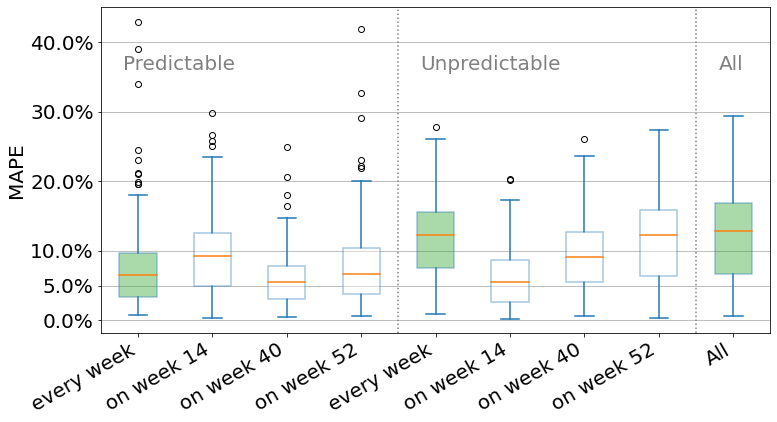

In [ ]:
# График
preds_each_week_all = pd.DataFrame({'High1':next_fwd_mapes,'High2':next_fwd_mapes_1t14,'High3':next_fwd_mapes_1t,'High4':next_fwd_mapes_1t52,
                                    'Low1':next_fwd_mapes_bad,'Low2':next_fwd_mapes_bad_1t14,'Low3':next_fwd_mapes_bad_1t,'Low4':next_fwd_mapes_bad_1t52,
                                   'All':next_fwd_mapes_all})
plt.rcParams['figure.figsize'] = 12, 6
style_for_all4 = dict(linewidth=1.5, color=cmap.colors[0])

bb = preds_each_week_all.plot(kind='box',return_type='both',
                             boxprops=dict(linewidth=1.5, color=cmap.colors[0]),
                             medianprops=dict(linewidth=1.5, color=cmap.colors[1]),
                             whiskerprops=style_for_all4,
                             capprops=style_for_all4,
                           patch_artist = True
                         )
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.text(0.8, 0.36, 'Predictable', color='gray')
plt.axvline(4.5, c='gray', ls=':')
plt.text(4.8, 0.36, 'Unpredictable', color='gray')
plt.axvline(8.5, c='gray', ls=':')
plt.text(8.8, 0.36, 'All', color='gray')

colors = [cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white'
         ]

for i,box in enumerate(bb[1]['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(.4)

s = plt.xticks(range(1,10), ['every week','on week 14','on week 40','on week 52']*2+['All'], rotation=30, ha='right')
plt.yticks([0,0.05,0.1,0.2,0.3,0.4])
plt.grid(axis='y')
#plt.ylim(0,0.3)
plt.ylabel('MAPE')

Text(0, 0.5, 'MAPE')

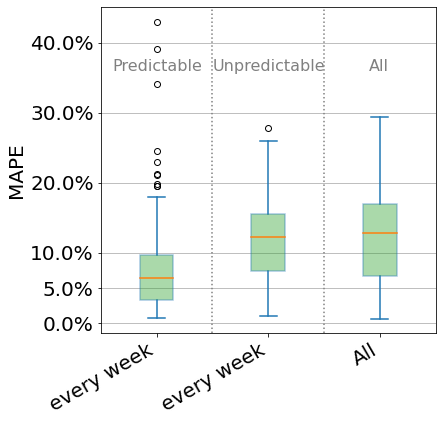

In [ ]:
# График
preds_each_week_all = pd.DataFrame({'High1':next_fwd_mapes,
                                    'Low1':next_fwd_mapes_bad,
                                   'All':next_fwd_mapes_all})
plt.rcParams['figure.figsize'] = 6, 6
style_for_all4 = dict(linewidth=1.5, color=cmap.colors[0])

bb = preds_each_week_all.plot(kind='box',return_type='both',
                             boxprops=dict(linewidth=1.5, color=cmap.colors[0]),
                             medianprops=dict(linewidth=1.5, color=cmap.colors[1]),
                             whiskerprops=style_for_all4,
                             capprops=style_for_all4,
                           patch_artist = True
                         )
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

fs = 16
plt.text(0.6, 0.36, 'Predictable', color='gray', fontsize=fs)
plt.axvline(1.5, c='gray', ls=':')
plt.text(1.5, 0.36, 'Unpredictable', color='gray', fontsize=fs)
plt.axvline(2.5, c='gray', ls=':')
plt.text(2.9, 0.36, 'All', color='gray', fontsize=fs)

colors = [cmap.colors[2],cmap.colors[2],cmap.colors[2]]

for i,box in enumerate(bb[1]['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(.4)

s = plt.xticks(range(1,4), ['every week']*2+['All'], rotation=30, ha='right')
plt.yticks([0,0.05,0.1,0.2,0.3,0.4])
plt.grid(axis='y')
#plt.ylim(0,0.3)
plt.ylabel('MAPE')

Text(0, 0.5, 'MAPE')

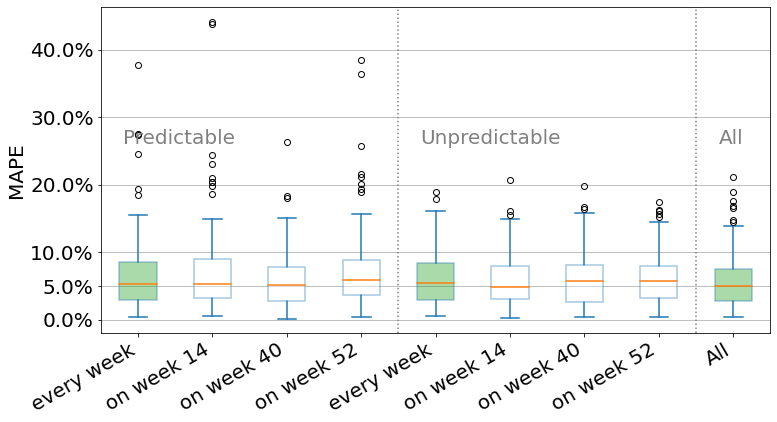

In [ ]:
# График
ipreds_each_week_all = pd.DataFrame({'High1':inext_fwd_mapes,'High2':inext_fwd_mapes_1t14,'High3':inext_fwd_mapes_1t,'High4':inext_fwd_mapes_1t52,
                                    'Low1':inext_fwd_mapes_bad,'Low2':inext_fwd_mapes_bad_1t14,'Low3':inext_fwd_mapes_bad_1t,'Low4':inext_fwd_mapes_bad_1t52,
                                   'All':inext_fwd_mapes_all})
plt.rcParams['figure.figsize'] = 12, 6
style_for_all4 = dict(linewidth=1.5, color=cmap.colors[0])

bb = ipreds_each_week_all.plot(kind='box',return_type='both',
                             boxprops=dict(linewidth=1.5, color=cmap.colors[0]),
                             medianprops=dict(linewidth=1.5, color=cmap.colors[1]),
                             whiskerprops=style_for_all4,
                             capprops=style_for_all4,
                           patch_artist = True
                         )
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.text(0.8, 0.26, 'Predictable', color='gray')
plt.axvline(4.5, c='gray', ls=':')
plt.text(4.8, 0.26, 'Unpredictable', color='gray')
plt.axvline(8.5, c='gray', ls=':')
plt.text(8.8, 0.26, 'All', color='gray')

colors = [cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white'
         ]

for i,box in enumerate(bb[1]['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(.4)

s = plt.xticks(range(1,10), ['every week','on week 14','on week 40','on week 52']*2+['All'], rotation=30, ha='right')
plt.yticks([0,0.05,0.1,0.2,0.3,0.4])
plt.grid(axis='y')
#plt.ylim(0,0.2)
plt.ylabel('MAPE')

Text(0, 0.5, 'MAPE')

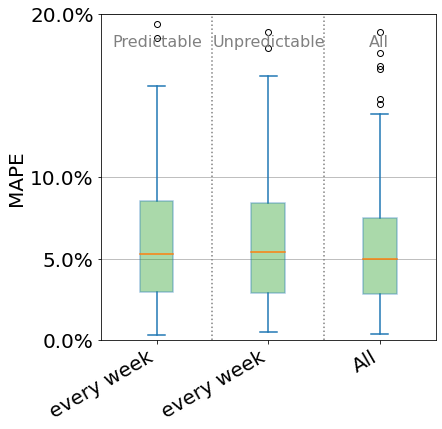

In [ ]:
# График
ipreds_each_week_all = pd.DataFrame({'High1':inext_fwd_mapes,
                                    'Low1':inext_fwd_mapes_bad,
                                   'All':inext_fwd_mapes_all})
plt.rcParams['figure.figsize'] = 6, 6
style_for_all4 = dict(linewidth=1.5, color=cmap.colors[0])

bb = ipreds_each_week_all.plot(kind='box',return_type='both',
                             boxprops=dict(linewidth=1.5, color=cmap.colors[0]),
                             medianprops=dict(linewidth=1.5, color=cmap.colors[1]),
                             whiskerprops=style_for_all4,
                             capprops=style_for_all4,
                           patch_artist = True
                         )
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

fs = 16
plt.text(0.6, 0.18, 'Predictable', color='gray', fontsize=fs)
plt.axvline(1.5, c='gray', ls=':')
plt.text(1.5, 0.18, 'Unpredictable', color='gray', fontsize=fs)
plt.axvline(2.5, c='gray', ls=':')
plt.text(2.9, 0.18, 'All', color='gray', fontsize=fs)

colors = [cmap.colors[2],cmap.colors[2],cmap.colors[2]]

for i,box in enumerate(bb[1]['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(.4)

s = plt.xticks(range(1,4), ['every week']*2+['All'], rotation=30, ha='right')

plt.yticks([0,0.05,0.1,0.2,0.3,0.4])
plt.grid(axis='y')
plt.ylim(0,0.2)
plt.ylabel('MAPE')

Text(0, 0.5, 'MAPE')

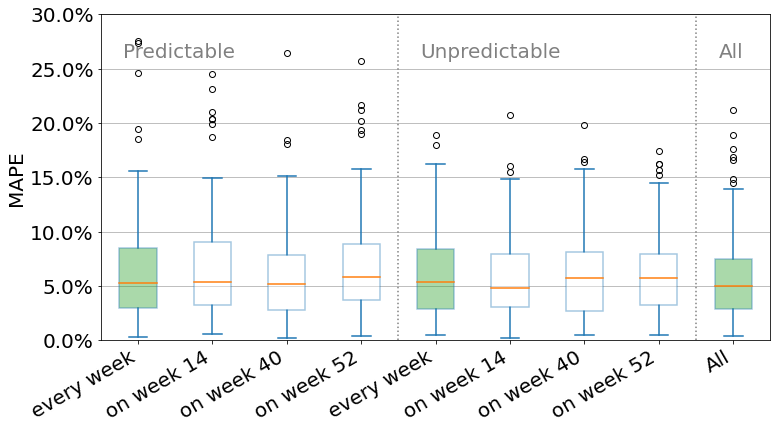

In [ ]:
# График
ipreds_each_week_all = pd.DataFrame({'High1':inext_fwd_mapes,'High2':inext_fwd_mapes_1t14,'High3':inext_fwd_mapes_1t,'High4':inext_fwd_mapes_1t52,
                                    'Low1':inext_fwd_mapes_bad,'Low2':inext_fwd_mapes_bad_1t14,'Low3':inext_fwd_mapes_bad_1t,'Low4':inext_fwd_mapes_bad_1t52,
                                   'All':inext_fwd_mapes_all})
plt.rcParams['figure.figsize'] = 12, 6
style_for_all4 = dict(linewidth=1.5, color=cmap.colors[0])

bb = ipreds_each_week_all.plot(kind='box',return_type='both',
                             boxprops=dict(linewidth=1.5, color=cmap.colors[0]),
                             medianprops=dict(linewidth=1.5, color=cmap.colors[1]),
                             whiskerprops=style_for_all4,
                             capprops=style_for_all4,
                           patch_artist = True
                         )
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.text(0.8, 0.26, 'Predictable', color='gray')
plt.axvline(4.5, c='gray', ls=':')
plt.text(4.8, 0.26, 'Unpredictable', color='gray')
plt.axvline(8.5, c='gray', ls=':')
plt.text(8.8, 0.26, 'All', color='gray')

colors = [cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white'
         ]

for i,box in enumerate(bb[1]['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(.4)

s = plt.xticks(range(1,10), ['every week','on week 14','on week 40','on week 52']*2+['All'], rotation=30, ha='right')
plt.grid(axis='y')
plt.ylim(0,0.3)
plt.ylabel('MAPE')

## Предсказания для хороших/плохих/всех сравниваем с реальными для всех клиентов

### По сумме

Найдем ошибки прогноза всех по сумме хороших и плохих

In [ ]:
for_weeks_next_fwd_mapes_1t = next_fwd_mapes_1t14, next_fwd_mapes_1t52, next_fwd_mapes_1t
for_weeks_next_full_fwd_pred_tr_1t = next_full_fwd_pred_tr_1t14, next_full_fwd_pred_tr_1t52, next_full_fwd_pred_tr_1t
for_weeks_next_full_fwd_true_1t = next_full_fwd_true_1t14, next_full_fwd_true_1t52, next_full_fwd_true_1t

for_weeks_next_fwd_mapes_bad_1t = next_fwd_mapes_bad_1t14, next_fwd_mapes_bad_1t52, next_fwd_mapes_bad_1t 
for_weeks_next_full_fwd_pred_tr_bad_1t = next_full_fwd_pred_tr_bad_1t14, next_full_fwd_pred_tr_bad_1t52, next_full_fwd_pred_tr_bad_1t
for_weeks_next_full_fwd_true_bad_1t = next_full_fwd_true_bad_1t14, next_full_fwd_true_bad_1t52, next_full_fwd_true_bad_1t

for_weeks_inext_fwd_mapes_1t = inext_fwd_mapes_1t14, inext_fwd_mapes_1t52, inext_fwd_mapes_1t
for_weeks_inext_full_fwd_pred_tr_1t = inext_full_fwd_pred_tr_1t14, inext_full_fwd_pred_tr_1t52, inext_full_fwd_pred_tr_1t
for_weeks_inext_full_fwd_true_1t = inext_full_fwd_true_1t14, inext_full_fwd_true_1t52, inext_full_fwd_true_1t

for_weeks_inext_fwd_mapes_bad_1t = inext_fwd_mapes_bad_1t14, inext_fwd_mapes_bad_1t52, inext_fwd_mapes_bad_1t
for_weeks_inext_full_fwd_pred_tr_bad_1t = inext_full_fwd_pred_tr_bad_1t14, inext_full_fwd_pred_tr_bad_1t52, inext_full_fwd_pred_tr_bad_1t
for_weeks_inext_full_fwd_true_bad_1t = inext_full_fwd_true_bad_1t14, inext_full_fwd_true_bad_1t52, inext_full_fwd_true_bad_1t

In [ ]:
# при поиске клиентов в классах каждую неделю
mape_all_sum = []
imape_all_sum = []

for nth_week in trange(0,n_weeks-1):
    # Считаем MAPE для предсказаний
    mape_all_sum.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                next_full_fwd_pred_tr[nth_week]+next_full_fwd_pred_tr_bad[nth_week]))
    imape_all_sum.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                inext_full_fwd_pred_tr[nth_week]+inext_full_fwd_pred_tr_bad[nth_week]))

# при поиске клиентов в классах только один раз
for_weeks_mape_all_sum_1t = []
for_weeks_imape_all_sum_1t = []
for week_to_test in range(len([14,52,40])):
    mape_all_sum_1t = []
    imape_all_sum_1t = []
    for nth_week in trange(0,n_weeks-1):
        mape_all_sum_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                          for_weeks_next_full_fwd_pred_tr_1t[week_to_test][nth_week] + \
                                                          for_weeks_next_full_fwd_pred_tr_bad_1t[week_to_test][nth_week]))
        imape_all_sum_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                           for_weeks_inext_full_fwd_pred_tr_1t[week_to_test][nth_week] + \
                                                          for_weeks_inext_full_fwd_pred_tr_bad_1t[week_to_test][nth_week]))
    for_weeks_mape_all_sum_1t.append(mape_all_sum_1t)
    for_weeks_imape_all_sum_1t.append(imape_all_sum_1t) 
    
mape_all_sum_1t14,mape_all_sum_1t52,mape_all_sum_1t = for_weeks_mape_all_sum_1t
imape_all_sum_1t14,imape_all_sum_1t52,imape_all_sum_1t = for_weeks_imape_all_sum_1t

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

Найдем ошибки прогноза всех по хорошим или по плохим с поиском клиентов 1 раз

Графики для сумм плохие+хорошие

In [ ]:
font_size = 15
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5])

plt.rc('font', size=font_size)          # controls default text sizes
plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels

plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size)    # legend fontsize
plt.rc('figure', titlesize=font_size)  # fontsize of the figure title

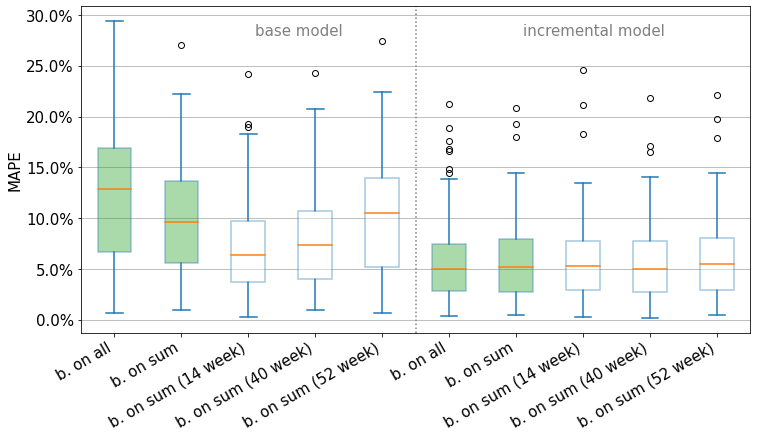

In [ ]:
plt.rcParams['figure.figsize'] = 12, 6
temp_sum = pd.DataFrame({'regular':next_fwd_mapes_all,'sum':mape_all_sum,
                        'sum_1t14':mape_all_sum_1t14,'sum_1t40':mape_all_sum_1t,'sum_1t52':mape_all_sum_1t52,
                        'inc_regular':inext_fwd_mapes_all,'sum_inc':imape_all_sum,
                        'sum_inc_1t14':imape_all_sum_1t14,'sum_inc_1t40':imape_all_sum_1t,'sum_inc_1t52':imape_all_sum_1t52})

boxes = temp_sum.plot(kind='box', return_type='both',
                             boxprops=dict(linewidth=1.5, color=cmap.colors[0]),
                             medianprops=dict(linewidth=1.5, color=cmap.colors[1]),
                             whiskerprops=dict(linewidth=1.5, color=cmap.colors[0]),
                             capprops=dict(linewidth=1.5, color=cmap.colors[0]),
                             patch_artist=True,
                         )
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xticks(range(1,11),
           ["b. on all","b. on sum",'b. on sum (14 week)','b. on sum (40 week)','b. on sum (52 week)']*2)

colors = [cmap.colors[2],cmap.colors[2],'white','white','white',
          cmap.colors[2],cmap.colors[2],'white','white','white']

for i,box in enumerate(boxes[1]['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(.4)
    
plt.text(3.1, 0.28, 'base model', color='gray')
plt.axvline(5.5, c='gray', ls=':')
plt.text(7.1, 0.28, 'incremental model', color='gray')

plt.grid(axis='y')
plt.ylabel('MAPE')
plt.xticks(rotation=30, ha='right');

In [ ]:
mape_hp = 0.05
print(f'14 sum_1t: test MAPE median: {np.median(np.array(mape_all_sum_1t14)) * 100 :.3f}%')
print(f'14 sum_1t: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_all_sum_1t14)<=mape_hp)[0].shape[0] / np.array(mape_all_sum_1t14).shape[0]) * 100 :.3f}%\n')
print(f'40 sum_1t: test MAPE median: {np.median(np.array(mape_all_sum_1t)) * 100 :.3f}%')
print(f'40 sum_1t: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_all_sum_1t)<=mape_hp)[0].shape[0] / np.array(mape_all_sum_1t).shape[0]) * 100 :.3f}%\n')
print(f'52 sum_1t: test MAPE median: {np.median(np.array(mape_all_sum_1t52)) * 100 :.3f}%')
print(f'52 sum_1t: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_all_sum_1t52)<=mape_hp)[0].shape[0] / np.array(mape_all_sum_1t52).shape[0]) * 100 :.3f}%\n')


print(f'14 sum_inc_1t: test MAPE median: {np.median(np.array(imape_all_sum_1t14)) * 100 :.3f}%')
print(f'14 sum_inc_1t: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_all_sum_1t14)<=mape_hp)[0].shape[0] / np.array(imape_all_sum_1t14).shape[0]) * 100 :.3f}%\n')
print(f'40 sum_inc_1t: test MAPE median: {np.median(np.array(imape_all_sum_1t)) * 100 :.3f}%')
print(f'40 sum_inc_1t: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_all_sum_1t)<=mape_hp)[0].shape[0] / np.array(imape_all_sum_1t).shape[0]) * 100 :.3f}%\n')
print(f'52 sum_inc_1t: test MAPE median: {np.median(np.array(imape_all_sum_1t52)) * 100 :.3f}%')
print(f'52 sum_inc_1t: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_all_sum_1t52)<=mape_hp)[0].shape[0] / np.array(imape_all_sum_1t52).shape[0]) * 100 :.3f}%\n')


14 sum_1t: test MAPE median: 6.391%
14 sum_1t: test MAPE HP (<=5.0%): 34.074%

40 sum_1t: test MAPE median: 7.367%
40 sum_1t: test MAPE HP (<=5.0%): 32.593%

52 sum_1t: test MAPE median: 10.517%
52 sum_1t: test MAPE HP (<=5.0%): 23.704%

14 sum_inc_1t: test MAPE median: 5.272%
14 sum_inc_1t: test MAPE HP (<=5.0%): 49.630%

40 sum_inc_1t: test MAPE median: 4.995%
40 sum_inc_1t: test MAPE HP (<=5.0%): 50.370%

52 sum_inc_1t: test MAPE median: 5.475%
52 sum_inc_1t: test MAPE HP (<=5.0%): 48.148%



In [ ]:
print(f'ALL vs ALL preds: test MAPE median: {np.median(np.array(next_fwd_mapes_all)) * 100 :.3f}%')
print(f'ALL vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(next_fwd_mapes_all)<=mape_hp)[0].shape[0] / np.array(next_fwd_mapes_all).shape[0]) * 100 :.3f}%\n')

print(f'inc ALL vs ALL preds: test MAPE median: {np.median(np.array(inext_fwd_mapes_all)) * 100 :.3f}%')
print(f'inc ALL vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(inext_fwd_mapes_all)<=mape_hp)[0].shape[0] / np.array(inext_fwd_mapes_all).shape[0]) * 100 :.3f}%\n')


print(f'sum: test MAPE median: {np.median(np.array(mape_all_sum)) * 100 :.3f}%')
print(f'sum: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_all_sum)<=mape_hp)[0].shape[0] / np.array(mape_all_sum).shape[0]) * 100 :.3f}%\n')

print(f'sum_inc: test MAPE median: {np.median(np.array(imape_all_sum)) * 100 :.3f}%')
print(f'sum_inc: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_all_sum)<=mape_hp)[0].shape[0] / np.array(imape_all_sum).shape[0]) * 100 :.3f}%\n')

ALL vs ALL preds: test MAPE median: 12.835%
ALL vs ALL preds: test MAPE HP (<=5.0%): 18.519%

inc ALL vs ALL preds: test MAPE median: 4.995%
inc ALL vs ALL preds: test MAPE HP (<=5.0%): 50.370%

sum: test MAPE median: 9.654%
sum: test MAPE HP (<=5.0%): 22.963%

sum_inc: test MAPE median: 5.231%
sum_inc: test MAPE HP (<=5.0%): 49.630%



### По отд. классу клиентов с выбором 1 раз

In [ ]:
split

951

In [ ]:
last_day = days[days==f'{a1_dm[2]}'].index[0]
next_split= days.shape[0]-last_day-1
next_all_rw[shift_days+mem+dim:-next_split]

53     1373448.0
54     1373448.0
55     1310807.0
56     1310807.0
57     1310807.0
         ...    
746    2198953.0
747    2198953.0
748    2198953.0
749    2160364.0
750    2160364.0
Length: 698, dtype: float64

In [ ]:
for_weeks_mape_good_pred_vs_all_1t = []
for_weeks_imape_good_pred_vs_all_1t = []
for_weeks_mape_bad_pred_vs_all_1t = []
for_weeks_imape_bad_pred_vs_all_1t = []



for week_to_test in [13,51,39]:
    good_clients_id, next_good_rw, next_bad_rw, \
        next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,
                                                                  bool_clients,week_to_test,
                                                                  window_size=21)
    coeff_good = np.median(next_all_rw[shift_days:-split].values.reshape(-1))/np.median(next_good_rw[shift_days:-split].values.reshape(-1))
    coeff_bad = np.median(next_all_rw[shift_days:-split].values.reshape(-1))/np.median(next_bad_rw[shift_days:-split].values.reshape(-1))
    
    mape_good_pred_vs_all_1t = []
    imape_good_pred_vs_all_1t = []
    mape_bad_pred_vs_all_1t = []
    imape_bad_pred_vs_all_1t = []
    
    for nth_week in trange(0,n_weeks-1):
        last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
        next_split= days.shape[0]-last_day-1

        # Считаем MAPE для предсказаний хороших клиентов, умноженных на коэфф.
        #(этот коефф же берет данные за сам период теста????? поэтому убираем)
        #coeff = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_good_rw[shift_days+mem+dim:-next_split].values.reshape(-1))
        
        mape_good_pred_vs_all_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                    next_full_fwd_pred_tr_1t[nth_week]*coeff_good))
        imape_good_pred_vs_all_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                    inext_full_fwd_pred_tr_1t[nth_week]*coeff_good))
        # Считаем MAPE для предсказаний плохих клиентов, умноженных на коэфф.
        #(этот коефф же берет данные за сам период теста????? поэтому убираем)
        #coeff_bad = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_bad_rw[shift_days+mem+dim:-next_split].values.reshape(-1))

        mape_bad_pred_vs_all_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                       next_full_fwd_pred_tr_bad_1t[nth_week]*coeff_bad))
        imape_bad_pred_vs_all_1t.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                       inext_full_fwd_pred_tr_bad_1t[nth_week]*coeff_bad))
        
    for_weeks_mape_good_pred_vs_all_1t.append(mape_good_pred_vs_all_1t)
    for_weeks_imape_good_pred_vs_all_1t.append(imape_good_pred_vs_all_1t)
    for_weeks_mape_bad_pred_vs_all_1t.append(mape_bad_pred_vs_all_1t)
    for_weeks_imape_bad_pred_vs_all_1t.append(imape_bad_pred_vs_all_1t)

mape_good_pred_vs_all_1t14,mape_good_pred_vs_all_1t52,mape_good_pred_vs_all_1t = for_weeks_mape_good_pred_vs_all_1t
imape_good_pred_vs_all_1t14,imape_good_pred_vs_all_1t52,imape_good_pred_vs_all_1t = for_weeks_imape_good_pred_vs_all_1t
mape_bad_pred_vs_all_1t14,mape_bad_pred_vs_all_1t52,mape_bad_pred_vs_all_1t = for_weeks_mape_bad_pred_vs_all_1t
imape_bad_pred_vs_all_1t14,imape_bad_pred_vs_all_1t52,imape_bad_pred_vs_all_1t = for_weeks_imape_bad_pred_vs_all_1t

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

In [ ]:
mape_hp = 0.05

print(f'14week good: test MAPE median: {np.median(np.array(mape_good_pred_vs_all_1t14)) * 100 :.3f}%')
print(f'14week good: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_good_pred_vs_all_1t14)<=mape_hp)[0].shape[0] / np.array(mape_good_pred_vs_all_1t14).shape[0]) * 100 :.3f}%\n')
print(f'40week good: test MAPE median: {np.median(np.array(mape_good_pred_vs_all_1t)) * 100 :.3f}%')
print(f'40week good: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_good_pred_vs_all_1t)<=mape_hp)[0].shape[0] / np.array(mape_good_pred_vs_all_1t).shape[0]) * 100 :.3f}%\n')
print(f'52week good: test MAPE median: {np.median(np.array(mape_good_pred_vs_all_1t52)) * 100 :.3f}%')
print(f'52week good: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_good_pred_vs_all_1t52)<=mape_hp)[0].shape[0] / np.array(mape_good_pred_vs_all_1t52).shape[0]) * 100 :.3f}%\n')

print(f'14week bad: test MAPE median: {np.median(np.array(mape_bad_pred_vs_all_1t14)) * 100 :.3f}%')
print(f'14week bad: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_bad_pred_vs_all_1t14)<=mape_hp)[0].shape[0] / np.array(mape_bad_pred_vs_all_1t14).shape[0]) * 100 :.3f}%\n')
print(f'40week bad: test MAPE median: {np.median(np.array(mape_bad_pred_vs_all_1t)) * 100 :.3f}%')
print(f'40week bad: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_bad_pred_vs_all_1t)<=mape_hp)[0].shape[0] / np.array(mape_bad_pred_vs_all_1t).shape[0]) * 100 :.3f}%\n')
print(f'52week bad: test MAPE median: {np.median(np.array(mape_bad_pred_vs_all_1t52)) * 100 :.3f}%')
print(f'52week bad: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_bad_pred_vs_all_1t52)<=mape_hp)[0].shape[0] / np.array(mape_bad_pred_vs_all_1t52).shape[0]) * 100 :.3f}%\n')


14week good: test MAPE median: 6.453%
14week good: test MAPE HP (<=5.0%): 35.556%

40week good: test MAPE median: 6.801%
40week good: test MAPE HP (<=5.0%): 32.593%

52week good: test MAPE median: 21.422%
52week good: test MAPE HP (<=5.0%): 1.481%

14week bad: test MAPE median: 6.962%
14week bad: test MAPE HP (<=5.0%): 37.778%

40week bad: test MAPE median: 8.207%
40week bad: test MAPE HP (<=5.0%): 31.111%

52week bad: test MAPE median: 15.574%
52week bad: test MAPE HP (<=5.0%): 3.704%



In [ ]:
print(f'i14week good: test MAPE median: {np.median(np.array(imape_good_pred_vs_all_1t14)) * 100 :.3f}%')
print(f'i14week good: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_good_pred_vs_all_1t14)<=mape_hp)[0].shape[0] / np.array(imape_good_pred_vs_all_1t14).shape[0]) * 100 :.3f}%\n')
print(f'i40week good: test MAPE median: {np.median(np.array(imape_good_pred_vs_all_1t)) * 100 :.3f}%')
print(f'i40week good: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_good_pred_vs_all_1t)<=mape_hp)[0].shape[0] / np.array(imape_good_pred_vs_all_1t).shape[0]) * 100 :.3f}%\n')
print(f'i52week good: test MAPE median: {np.median(np.array(imape_good_pred_vs_all_1t52)) * 100 :.3f}%')
print(f'i52week good: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_good_pred_vs_all_1t52)<=mape_hp)[0].shape[0] / np.array(imape_good_pred_vs_all_1t52).shape[0]) * 100 :.3f}%\n')

print(f'i14week bad: test MAPE median: {np.median(np.array(imape_bad_pred_vs_all_1t14)) * 100 :.3f}%')
print(f'i14week bad: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_bad_pred_vs_all_1t14)<=mape_hp)[0].shape[0] / np.array(imape_bad_pred_vs_all_1t14).shape[0]) * 100 :.3f}%\n')
print(f'i40week bad: test MAPE median: {np.median(np.array(imape_bad_pred_vs_all_1t)) * 100 :.3f}%')
print(f'i40week bad: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_bad_pred_vs_all_1t)<=mape_hp)[0].shape[0] / np.array(imape_bad_pred_vs_all_1t).shape[0]) * 100 :.3f}%\n')
print(f'i52week bad: test MAPE median: {np.median(np.array(imape_bad_pred_vs_all_1t52)) * 100 :.3f}%')
print(f'i52week bad: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_bad_pred_vs_all_1t52)<=mape_hp)[0].shape[0] / np.array(imape_bad_pred_vs_all_1t52).shape[0]) * 100 :.3f}%\n')


i14week good: test MAPE median: 6.030%
i14week good: test MAPE HP (<=5.0%): 36.296%

i40week good: test MAPE median: 6.550%
i40week good: test MAPE HP (<=5.0%): 35.556%

i52week good: test MAPE median: 24.177%
i52week good: test MAPE HP (<=5.0%): 0.741%

i14week bad: test MAPE median: 4.433%
i14week bad: test MAPE HP (<=5.0%): 56.296%

i40week bad: test MAPE median: 4.784%
i40week bad: test MAPE HP (<=5.0%): 53.333%

i52week bad: test MAPE median: 11.047%
i52week bad: test MAPE HP (<=5.0%): 10.370%



### По отд. классу клиентов с выбором каждую неделю

Найдем ошибки прогноза всех по хорошим или по плохим с поиском клиентов на каждой неделе

In [ ]:
mape_good_pred_vs_all = []
imape_good_pred_vs_all = []
mape_bad_pred_vs_all = []
imape_bad_pred_vs_all = []

for nth_week in trange(0,n_weeks-1):
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    # Считаем MAPE для предсказаний хороших клиентов, умноженных на коэфф.
    #coeff = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_good_rw[shift_days+mem+dim:-next_split].values.reshape(-1))
    coeff_good = np.median(next_all_rw[shift_days:-split].values.reshape(-1))/np.median(next_good_rw[shift_days:-split].values.reshape(-1))
        
    mape_good_pred_vs_all.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                next_full_fwd_pred_tr[nth_week]*coeff_good))
    imape_good_pred_vs_all.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                inext_full_fwd_pred_tr[nth_week]*coeff_good))
    # Считаем MAPE для предсказаний плохих клиентов, умноженных на коэфф.
    #coeff_bad = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_bad_rw[shift_days+mem+dim:-next_split].values.reshape(-1))
    coeff_bad = np.median(next_all_rw[shift_days:-split].values.reshape(-1))/np.median(next_bad_rw[shift_days:-split].values.reshape(-1))
    
    mape_bad_pred_vs_all.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                   next_full_fwd_pred_tr_bad[nth_week]*coeff_bad))
    imape_bad_pred_vs_all.append(mean_absolute_percentage_error(next_full_fwd_true_all[nth_week], 
                                                                   inext_full_fwd_pred_tr_bad[nth_week]*coeff_bad))

  0%|          | 0/135 [00:00<?, ?it/s]

Обычная модель

In [ ]:
mape_hp = 0.05

print(f'ALL vs ALL preds: test MAPE median: {np.median(np.array(next_fwd_mapes_all)) * 100 :.3f}%')
print(f'ALL vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(next_fwd_mapes_all)<=mape_hp)[0].shape[0] / np.array(next_fwd_mapes_all).shape[0]) * 100 :.3f}%\n')

print(f'GOOD vs ALL preds: test MAPE median: {np.median(np.array(mape_good_pred_vs_all)) * 100 :.3f}%')
print(f'GOOD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_good_pred_vs_all)<=mape_hp)[0].shape[0] / np.array(mape_good_pred_vs_all).shape[0]) * 100 :.3f}%\n')

print(f'BAD vs ALL preds: test MAPE median: {np.median(np.array(mape_bad_pred_vs_all)) * 100 :.3f}%')
print(f'BAD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_bad_pred_vs_all)<=mape_hp)[0].shape[0] / np.array(mape_bad_pred_vs_all).shape[0]) * 100 :.3f}%')

ALL vs ALL preds: test MAPE median: 12.835%
ALL vs ALL preds: test MAPE HP (<=5.0%): 18.519%

GOOD vs ALL preds: test MAPE median: 8.394%
GOOD vs ALL preds: test MAPE HP (<=5.0%): 30.370%

BAD vs ALL preds: test MAPE median: 10.244%
BAD vs ALL preds: test MAPE HP (<=5.0%): 22.222%


Инкрементально

In [ ]:
mape_hp = 0.05

print(f'ALL vs ALL preds: test MAPE median: {np.median(np.array(inext_fwd_mapes_all)) * 100 :.3f}%')
print(f'ALL vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(inext_fwd_mapes_all)<=mape_hp)[0].shape[0] / np.array(inext_fwd_mapes_all).shape[0]) * 100 :.3f}%\n')

print(f'GOOD vs ALL preds: test MAPE median: {np.median(np.array(imape_good_pred_vs_all)) * 100 :.3f}%')
print(f'GOOD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_good_pred_vs_all)<=mape_hp)[0].shape[0] / np.array(imape_good_pred_vs_all).shape[0]) * 100 :.3f}%\n')

print(f'BAD vs ALL preds: test MAPE median: {np.median(np.array(imape_bad_pred_vs_all)) * 100 :.3f}%')
print(f'BAD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(imape_bad_pred_vs_all)<=mape_hp)[0].shape[0] / np.array(imape_bad_pred_vs_all).shape[0]) * 100 :.3f}%')

ALL vs ALL preds: test MAPE median: 4.995%
ALL vs ALL preds: test MAPE HP (<=5.0%): 50.370%

GOOD vs ALL preds: test MAPE median: 6.441%
GOOD vs ALL preds: test MAPE HP (<=5.0%): 36.296%

BAD vs ALL preds: test MAPE median: 5.090%
BAD vs ALL preds: test MAPE HP (<=5.0%): 49.630%


  0%|          | 0/135 [00:00<?, ?it/s]

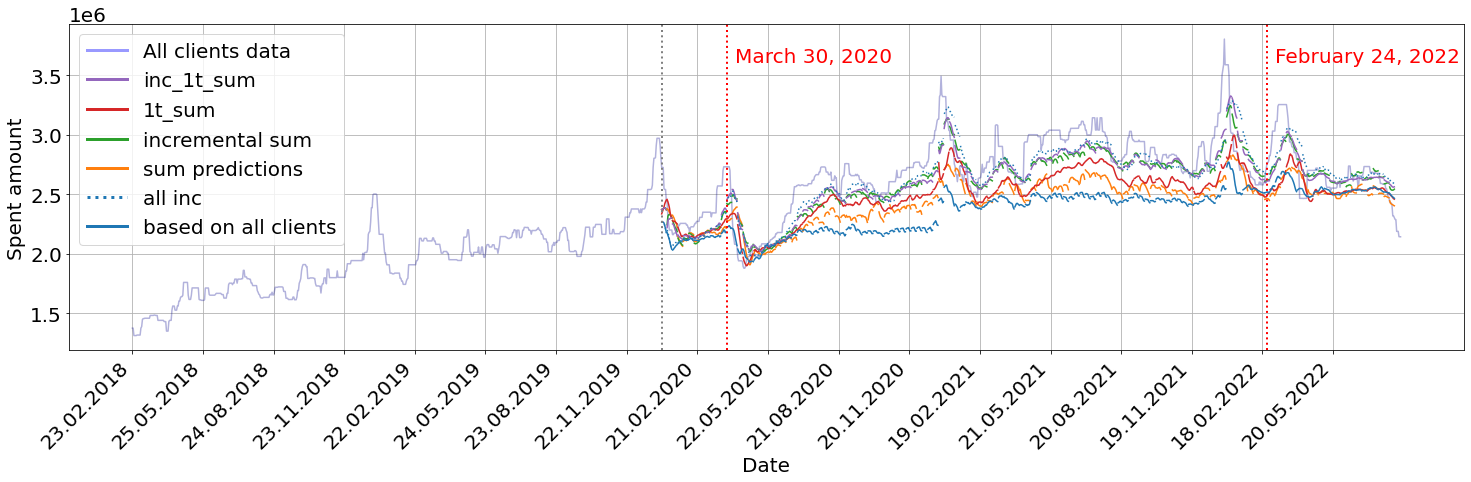

In [ ]:
plt.rcParams['figure.figsize'] = 25, 6
ytt = all_rw[shift_days+mem+dim:].values.reshape(-1)
plt.plot(ytt, c='darkblue', alpha=.3, label='All clients data')

for nth_week in trange(0,n_weeks-1):
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    
    x_coords = np.arange(len(ytt)-next_split-2,len(ytt)-next_split-2+fwd)
    
    plt.plot(x_coords, next_full_fwd_pred_tr[nth_week]+next_full_fwd_pred_tr_bad[nth_week], color=cmap.colors[1],linestyle='-')
    plt.plot(x_coords, inext_full_fwd_pred_tr[nth_week]+inext_full_fwd_pred_tr_bad[nth_week], color=cmap.colors[2],linestyle='-')
    
    plt.plot(x_coords, next_full_fwd_pred_tr_1t[nth_week]+next_full_fwd_pred_tr_bad_1t[nth_week], color=cmap.colors[3],linestyle='-')
    plt.plot(x_coords, inext_full_fwd_pred_tr_1t[nth_week]+inext_full_fwd_pred_tr_bad_1t[nth_week], color=cmap.colors[4],linestyle='-')
    
    plt.plot(x_coords, next_full_fwd_pred_tr_all[nth_week],'-', c=cmap.colors[0])
    plt.plot(x_coords, inext_full_fwd_pred_tr_all[nth_week], c=cmap.colors[0],linestyle=':')
    
ticks=days[shift_days+mem+dim:]
xt=np.arange(0, len(ticks), 13)
plt.xticks(xt[::7], ticks.iloc[xt][::7], rotation=45, ha='right')

lines = [Line2D([0], [0], color='blue', linewidth=3, linestyle='-', alpha=0.4),
         Line2D([0], [0], color=cmap.colors[4], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=cmap.colors[3], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=cmap.colors[2], linewidth=3, linestyle='-'),
        Line2D([0], [0], color=cmap.colors[1], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=cmap.colors[0], linewidth=3, linestyle=':'),
        Line2D([0], [0], color=cmap.colors[0], linewidth=3, linestyle='-')]
labels = ['All clients data','inc_1t_sum', '1t_sum','incremental sum',"sum predictions",'all inc','based on all clients']
plt.legend(lines, labels)

plt.axvline(len(ytt)-split-2,ls=':',c='gray',lw=2)

plt.axvline(766,ls=':',c='red',lw=2)
plt.text(776, ytt.max()*0.95,'March 30, 2020',c='red')

plt.axvline(1462,ls=':',c='red',lw=2)
plt.text(1472, ytt.max()*0.95,'February 24, 2022',c='red',)

plt.grid()
#plt.title('Предсказания клиентов относительно реальных данных всех клиентов')
plt.ylabel('Spent amount')
plt.xlabel('Date');

In [ ]:
font_size = 22
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5])

plt.rc('font', size=font_size)          # controls default text sizes
plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels

plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size)    # legend fontsize
plt.rc('figure', titlesize=font_size)  # fontsize of the figure title

  0%|          | 0/135 [00:00<?, ?it/s]

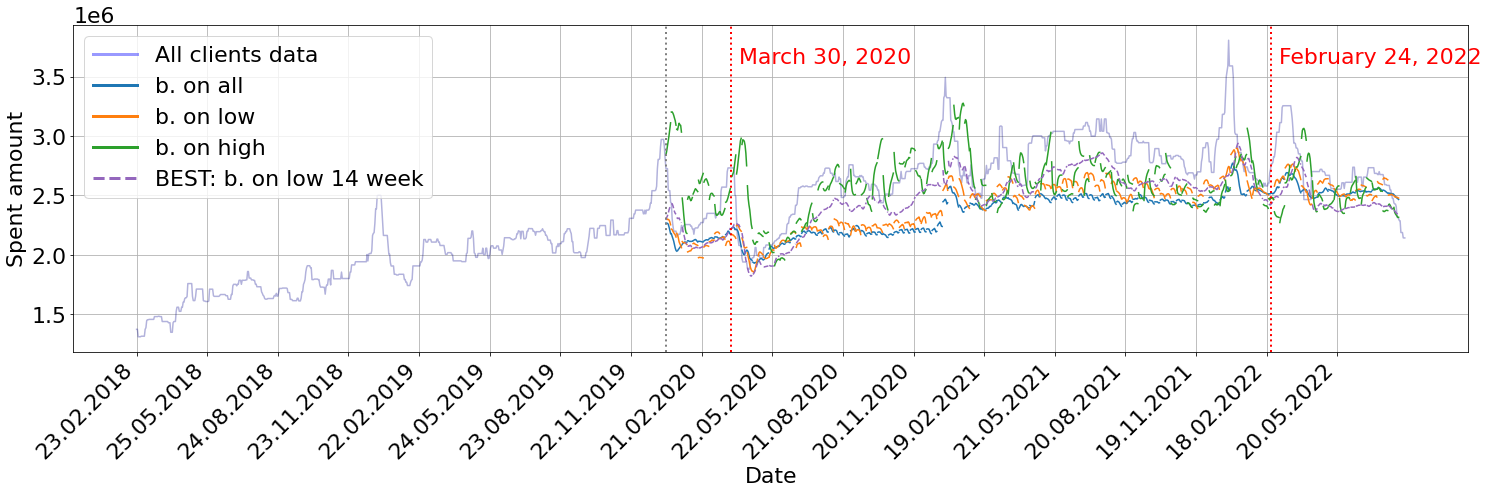

In [ ]:
plt.rcParams['figure.figsize'] = 25, 6
ytt = all_rw[shift_days+mem+dim:].values.reshape(-1)
plt.plot(ytt, c='darkblue', alpha=.3, label='All clients data')

good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,14,window_size=21)
coeff_14w = np.median(next_all_rw[shift_days:-split].values.reshape(-1))/np.median(next_bad_rw[shift_days:-split].values.reshape(-1))


for nth_week in trange(0,n_weeks-1):
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    x_coords = np.arange(len(ytt)-next_split-2,len(ytt)-next_split-2+fwd)
    
    # на основе всех клиентов
    plt.plot(x_coords, next_full_fwd_pred_tr_all[nth_week], 
             color=cmap.colors[0],linestyle='-')
    
    # сумма предсказаний хороших и плохих на 40 неделе
    #plt.plot(x_coords, for_weeks_next_full_fwd_pred_tr_1t[1][nth_week]+for_weeks_next_full_fwd_pred_tr_bad_1t[1][nth_week], 
             #color=cmap.colors[4],linestyle='-')
    
    # Считаем коэфф. для предсказаний плохих клиентов
    #coeff_bad = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_bad_rw[shift_days+mem+dim:-next_split].values.reshape(-1))
    coeff_bad = np.median(next_all_rw[shift_days:-split].values.reshape(-1))/np.median(next_bad_rw[shift_days:-split].values.reshape(-1))
    plt.plot(x_coords, next_full_fwd_pred_tr_bad[nth_week]*coeff_bad, 
             color=cmap.colors[1],linestyle='-')
    
    # Считаем коэфф. для предсказаний хороших клиентов
    #coeff_good = np.median(next_all_rw[shift_days+mem+dim:-next_split].values.reshape(-1))/np.median(next_good_rw[shift_days+mem+dim:-next_split].values.reshape(-1))
    coeff_good = np.median(next_all_rw[shift_days:-split].values.reshape(-1))/np.median(next_good_rw[shift_days:-split].values.reshape(-1))
    plt.plot(x_coords, next_full_fwd_pred_tr[nth_week]*coeff_good, 
             color=cmap.colors[2],linestyle='-')
    
    # на основе bad на 14 неделе 
    plt.plot(x_coords, for_weeks_next_full_fwd_pred_tr_bad_1t[0][nth_week]*coeff_14w, 
             color=cmap.colors[4],linestyle='--')
    
   
    
ticks=days[shift_days+mem+dim:]
xt=np.arange(0, len(ticks), 13)
plt.xticks(xt[::7], ticks.iloc[xt][::7], rotation=45, ha='right')

lines = [Line2D([0], [0], color='blue', linewidth=3, linestyle='-', alpha=0.4),
         Line2D([0], [0], color=cmap.colors[0], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=cmap.colors[1], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=cmap.colors[2], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=cmap.colors[4], linewidth=3, linestyle='--'),
        ]
labels = ['All clients data', 'b. on all', 'b. on low', 'b. on high', 'BEST: b. on low 14 week']
plt.legend(lines, labels)

plt.axvline(len(ytt)-split-2,ls=':',c='gray',lw=2)

plt.axvline(766,ls=':',c='red',lw=2)
plt.text(776, ytt.max()*0.95,'March 30, 2020',c='red')

plt.axvline(1462,ls=':',c='red',lw=2)
plt.text(1472, ytt.max()*0.95,'February 24, 2022',c='red',)

plt.grid()
#plt.title('Предсказания клиентов относительно реальных данных всех клиентов')
plt.ylabel('Spent amount')
plt.xlabel('Date');

In [ ]:
coeff_bad = np.median(next_all_rw[shift_days:-split].values.reshape(-1))/np.median(next_bad_rw[shift_days:-split].values.reshape(-1))
coeff_good = np.median(next_all_rw[shift_days:-split].values.reshape(-1))/np.median(next_good_rw[shift_days:-split].values.reshape(-1))
    

  0%|          | 0/135 [00:00<?, ?it/s]

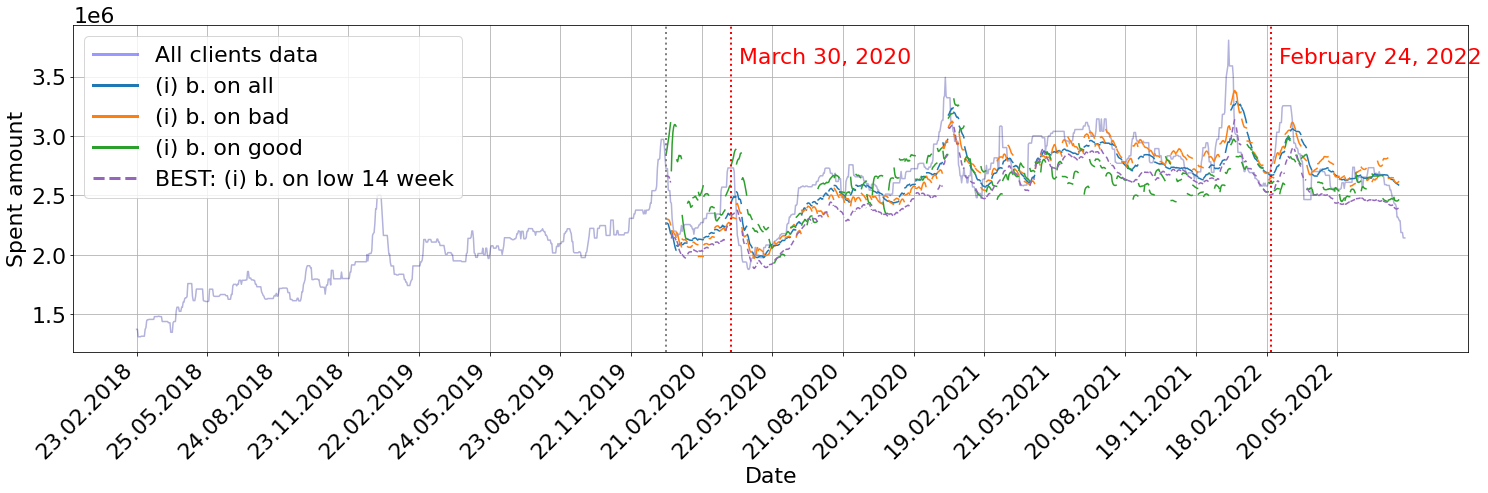

In [ ]:
plt.rcParams['figure.figsize'] = 25, 6
ytt = all_rw[shift_days+mem+dim:].values.reshape(-1)
plt.plot(ytt, c='darkblue', alpha=.3, label='All clients data')


for nth_week in trange(0,n_weeks-1):
    good_clients_id, next_good_rw, next_bad_rw, next_all_rw = macro_help_functions.client_groups_nth_week(df_2models,df_real_id,bool_clients,nth_week,window_size=21)
    last_day = days[days==f'{a1_dm[nth_week]}'].index[0]
    next_split= days.shape[0]-last_day-1
    x_coords = np.arange(len(ytt)-next_split-2,len(ytt)-next_split-2+fwd)
    
    # на основе всех клиентов
    plt.plot(x_coords, inext_full_fwd_pred_tr_all[nth_week], 
             color=cmap.colors[0],linestyle='-')
    
    # сумма предсказаний хороших и плохих на 40 неделе
    #plt.plot(x_coords, for_weeks_next_full_fwd_pred_tr_1t[1][nth_week]+for_weeks_next_full_fwd_pred_tr_bad_1t[1][nth_week], 
             #color=cmap.colors[4],linestyle='-')
    
     # Считаем коэфф. для предсказаний плохих клиентов
    coeff_bad = np.median(next_all_rw[shift_days:-split].values.reshape(-1))/np.median(next_bad_rw[shift_days:-split].values.reshape(-1))
    plt.plot(x_coords, inext_full_fwd_pred_tr_bad[nth_week]*coeff_bad, 
             color=cmap.colors[1],linestyle='-')
    
    # Считаем коэфф. для предсказаний хороших клиентов
    coeff_good = np.median(next_all_rw[shift_days:-split].values.reshape(-1))/np.median(next_good_rw[shift_days:-split].values.reshape(-1))
    plt.plot(x_coords, inext_full_fwd_pred_tr[nth_week]*coeff_good, 
             color=cmap.colors[2],linestyle='-')
    
    # на основе bad на 14 неделе 
    plt.plot(x_coords, for_weeks_inext_full_fwd_pred_tr_bad_1t[0][nth_week]*coeff_14w, 
             color=cmap.colors[4],linestyle='--')
    
ticks=days[shift_days+mem+dim:]
xt=np.arange(0, len(ticks), 13)
plt.xticks(xt[::7], ticks.iloc[xt][::7], rotation=45, ha='right')

lines = [Line2D([0], [0], color='blue', linewidth=3, linestyle='-', alpha=0.4),
         Line2D([0], [0], color=cmap.colors[0], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=cmap.colors[1], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=cmap.colors[2], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=cmap.colors[4], linewidth=3, linestyle='--'),
        ]
labels = ['All clients data', '(i) b. on all', '(i) b. on bad', 
          '(i) b. on good', 'BEST: (i) b. on low 14 week']
plt.legend(lines, labels)

plt.axvline(len(ytt)-split-2,ls=':',c='gray',lw=2)

plt.axvline(766,ls=':',c='red',lw=2)
plt.text(776, ytt.max()*0.95,'March 30, 2020',c='red')

plt.axvline(1462,ls=':',c='red',lw=2)
plt.text(1472, ytt.max()*0.95,'February 24, 2022',c='red',)

plt.grid()
#plt.title('Предсказания клиентов относительно реальных данных всех клиентов')
plt.ylabel('Spent amount')
plt.xlabel('Date');

In [ ]:
font_size = 23
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5])

plt.rc('font', size=font_size)          # controls default text sizes
plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels

plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size)    # legend fontsize
plt.rc('figure', titlesize=font_size)  # fontsize of the figure title

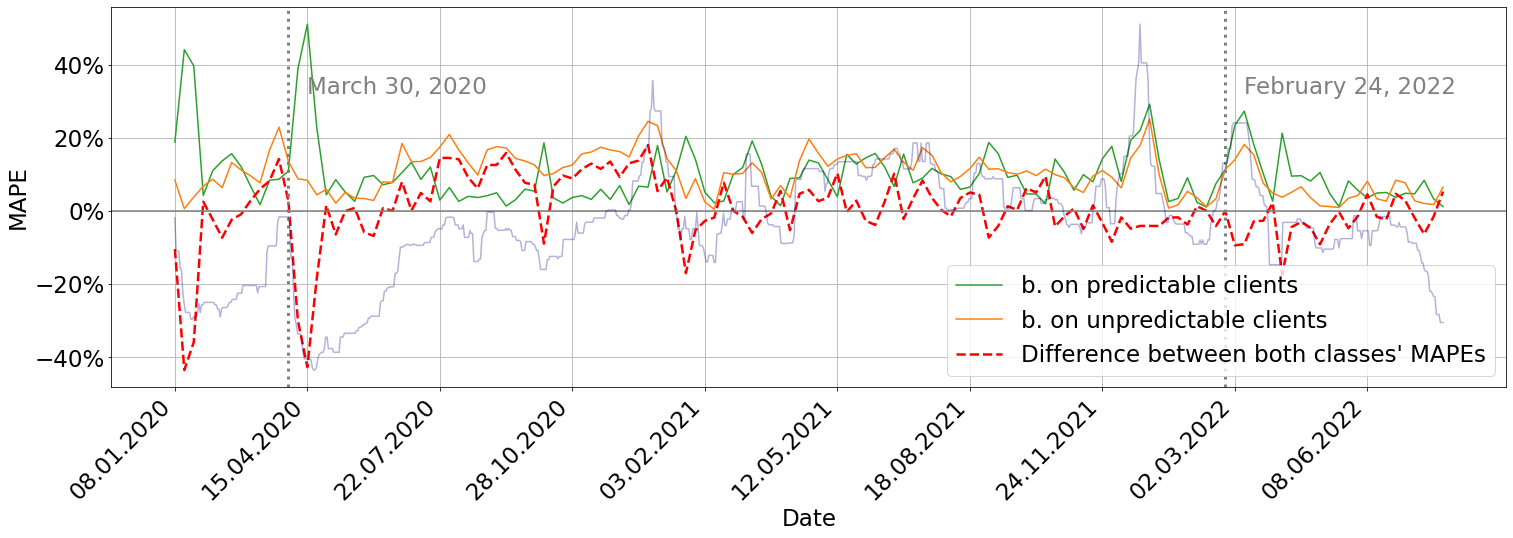

In [ ]:
# MAPE для каждого из 77 предсказаний
temp_vs_all = pd.DataFrame({'good':mape_good_pred_vs_all,'igood':imape_good_pred_vs_all,
                            'all': next_fwd_mapes_all, 'iall': inext_fwd_mapes_all,
                            'bad':mape_bad_pred_vs_all,'ibad':imape_bad_pred_vs_all})
plt.rcParams['figure.figsize'] = 25, 7

fig=plt.figure()

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax2.plot(days[-split:],ytt[-split:], c='darkblue', alpha=.3, label="All clients' data")
ax2.axis('off')

ax.plot(temp_vs_all['good'],'-',c=cmap.colors[2],label="b. on predictable clients")
#ax.plot(temp_vs_all['all'],'-',label='based on all clients', c=cmap.colors[0])
ax.plot(temp_vs_all['bad'],'-',label="b. on unpredictable clients",c=cmap.colors[1])
ax.plot((temp_vs_all['bad']-temp_vs_all['good']),'--',label="Difference between both classes' MAPEs",c='red',lw=2.5)

ax.set_xticks(np.arange(0, len(a0_dm[1:]),14))
ax.set_xticklabels(a0_dm[1::14],rotation=45, ha='right')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(0.,c='gray',ls='-')

ax.grid()
ax.legend(loc='lower right')

ax.axvline(12,ls=':',c='gray',lw=3)
ax.text(14,0.32,'March 30, 2020',c='gray')
ax.axvline(111,ls=':',c='gray',lw=3)
ax.text(113,0.32,'February 24, 2022',c='gray')

#plt.title('Ошибки предсказаний относительно реальных данных всех клиентов')
ax.set_ylabel('MAPE')
ax.set_xlabel('Date');


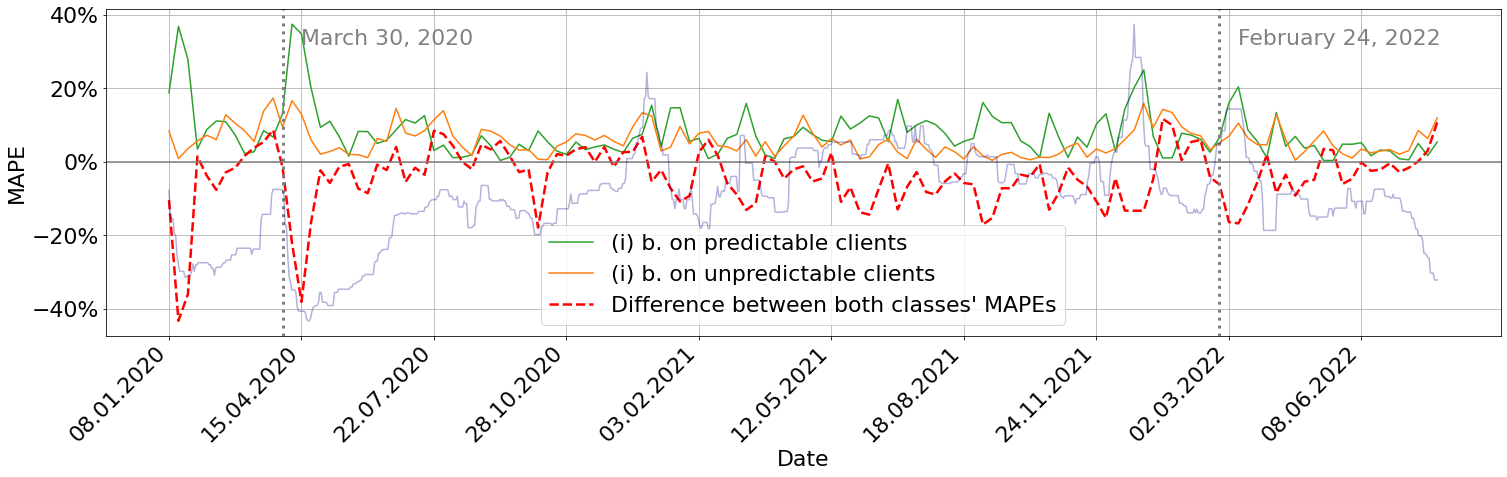

In [ ]:
plt.rcParams['figure.figsize'] = 25, 6

fig=plt.figure()

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax2.plot(days[-split:],ytt[-split:], c='darkblue', alpha=.3, label="All clients' data")
ax2.axis('off')

ax.plot(temp_vs_all['igood'],'-',c=cmap.colors[2],label="(i) b. on predictable clients")
#ax.plot(temp_vs_all['all'],'-',label='based on all clients', c=cmap.colors[0])
ax.plot(temp_vs_all['ibad'],'-',label="(i) b. on unpredictable clients",c=cmap.colors[1])
ax.plot((temp_vs_all['ibad']-temp_vs_all['good']),'--',label="Difference between both classes' MAPEs",c='red',lw=2.5)

ax.set_xticks(np.arange(0, len(a0_dm[1:]),14))
ax.set_xticklabels(a0_dm[1::14],rotation=45, ha='right')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(0.,c='gray',ls='-')

ax.grid()
ax.legend()

ax.axvline(12,ls=':',c='gray',lw=3)
ax.text(14,0.32,'March 30, 2020',c='gray')
ax.axvline(111,ls=':',c='gray',lw=3)
ax.text(113,0.32,'February 24, 2022',c='gray')

#plt.title('Ошибки предсказаний относительно реальных данных всех клиентов')
ax.set_ylabel('MAPE')
ax.set_xlabel('Date');

### Графики

In [ ]:
temp_sum = pd.DataFrame({'regular':next_fwd_mapes_all,'sum':mape_all_sum,
                        'sum_1t14':mape_all_sum_1t14,'sum_1t40':mape_all_sum_1t,'sum_1t52':mape_all_sum_1t52,
                        'inc_regular':inext_fwd_mapes_all,'sum_inc':imape_all_sum,
                        'sum_inc_1t14':imape_all_sum_1t14,'sum_inc_1t40':imape_all_sum_1t,'sum_inc_1t52':imape_all_sum_1t52})

Text(0, 0.5, 'MAPE')

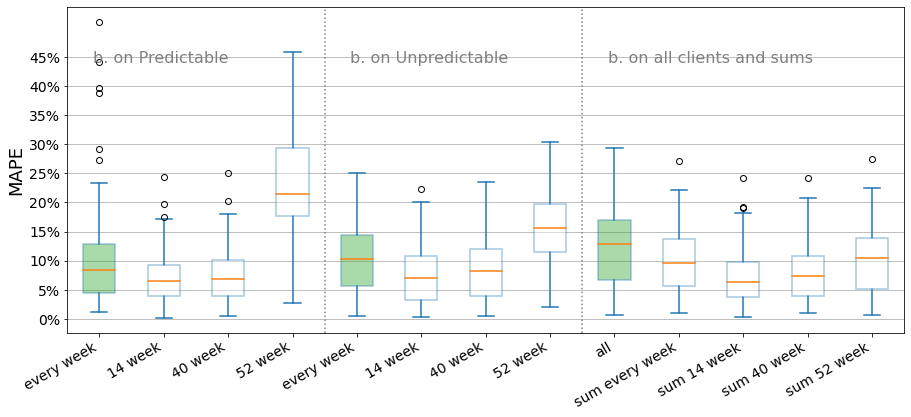

In [ ]:
# График
preds_each_week_all = pd.DataFrame({'High1':mape_good_pred_vs_all,'High2':mape_good_pred_vs_all_1t14,'High3':mape_good_pred_vs_all_1t,'High4':mape_good_pred_vs_all_1t52,
                                    'Low1':mape_bad_pred_vs_all,'Low2':mape_bad_pred_vs_all_1t14,'Low3':mape_bad_pred_vs_all_1t,'Low4':mape_bad_pred_vs_all_1t52,
                                   'All':next_fwd_mapes_all,'Sum_everyw':mape_all_sum, 'sum_1t14':mape_all_sum_1t14,'sum_1t40':mape_all_sum_1t,'sum_1t52':mape_all_sum_1t52})

plt.rcParams['figure.figsize'] = 15, 6
style_for_all4 = dict(linewidth=1.5, color=cmap.colors[0])

bb = preds_each_week_all.plot(kind='box',return_type='both',
                             boxprops=dict(linewidth=1.5, color=cmap.colors[0]),
                             medianprops=dict(linewidth=1.5, color=cmap.colors[1]),
                             whiskerprops=style_for_all4,
                             capprops=style_for_all4,
                           patch_artist = True
                         )
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

height = 0.44
beginning = 0.9
plt.text(beginning, height, 'b. on Predictable', color='gray')
plt.axvline(4.5, c='gray', ls=':')
plt.text(beginning+4, height, 'b. on Unpredictable', color='gray')
plt.axvline(8.5, c='gray', ls=':')
plt.text(beginning+8, height, 'b. on all clients and sums', color='gray')

colors = [cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white','white','white','white',
         'white' 
         ]

for i,box in enumerate(bb[1]['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(.4)

plt.xticks(range(1,14), ['every week','14 week','40 week','52 week']*2+['all','sum every week','sum 14 week','sum 40 week','sum 52 week'], rotation=30, ha='right')
plt.yticks(np.arange(0, 0.5, 0.05))
plt.grid(axis='y')
#plt.ylim(0,0.48)
plt.ylabel('MAPE')

#plt.title('Предсказания относительно той же группы');

Text(0, 0.5, 'MAPE')

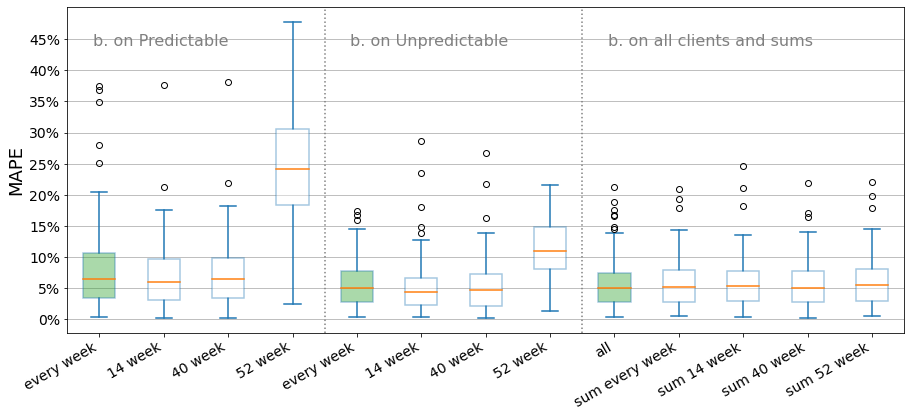

In [ ]:
# График
preds_each_week_all = pd.DataFrame({'High1':imape_good_pred_vs_all,'High2':imape_good_pred_vs_all_1t14,'High3':imape_good_pred_vs_all_1t,'High4':imape_good_pred_vs_all_1t52,
                                    'Low1':imape_bad_pred_vs_all,'Low2':imape_bad_pred_vs_all_1t14,'Low3':imape_bad_pred_vs_all_1t,'Low4':imape_bad_pred_vs_all_1t52,
                                   'All':inext_fwd_mapes_all,'Sum_everyw':imape_all_sum, 'sum_1t14':imape_all_sum_1t14,'sum_1t40':imape_all_sum_1t,'sum_1t52':imape_all_sum_1t52})

plt.rcParams['figure.figsize'] = 15, 6
style_for_all4 = dict(linewidth=1.5, color=cmap.colors[0])

bb = preds_each_week_all.plot(kind='box',return_type='both',
                             boxprops=dict(linewidth=1.5, color=cmap.colors[0]),
                             medianprops=dict(linewidth=1.5, color=cmap.colors[1]),
                             whiskerprops=style_for_all4,
                             capprops=style_for_all4,
                           patch_artist = True
                         )
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

height = 0.44
beginning = 0.9
plt.text(beginning, height, 'b. on Predictable', color='gray')
plt.axvline(4.5, c='gray', ls=':')
plt.text(beginning+4, height, 'b. on Unpredictable', color='gray')
plt.axvline(8.5, c='gray', ls=':')
plt.text(beginning+8, height, 'b. on all clients and sums', color='gray')

colors = [cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white',
         cmap.colors[2],'white','white','white','white','white','white',
         'white' 
         ]

for i,box in enumerate(bb[1]['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(.4)

plt.xticks(range(1,14), ['every week','14 week','40 week','52 week']*2+['all','sum every week','sum 14 week','sum 40 week','sum 52 week'], rotation=30, ha='right')
plt.yticks(np.arange(0, 0.5, 0.05))
plt.grid(axis='y')
#plt.ylim(0,0.48)
plt.ylabel('MAPE')

#plt.title('Предсказания относительно той же группы');